# Imports

In [1]:
# Remove duplicate imports and sort them alphabetically
import itertools
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
import pmdarima as pm
import seaborn as sns
import scipy.stats as stats
from scipy.stats import boxcox
import warnings

from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss
import statsmodels.api as sm
from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning

import xgboost as xgb

from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential

warnings.filterwarnings("ignore", category=ValueWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)


# Import Dataset

The Dataset with the following columns is imported

used variables:
- Total vehicles sold (Target)
    - Company car tax rate (%)
    - Google  Home charging (G)
    - Consumer confidence (E)
    - Gasoline (Euro95) - Average price (F)





In [2]:
# Load data
df = pd.read_csv(r"C:\Users\dylan\OneDrive - HvA\AAI Master\BLOK 3 afstuderen\Thesis\Eigenwerk\DATASET\Final.CSV")
df["Time Period (T)"] = pd.to_datetime(df["Time Period (T)"], format="%Y-%m-%d")
df = df.sort_values("Time Period (T)").reset_index(drop=True)
display(df.head())

Time Period (T)  Company car tax rate (%)  Home charging (G)  \
0      2007-01-01                        22                  0   
1      2007-02-01                        22                  0   
2      2007-03-01                        22                  0   
3      2007-04-01                        22                  0   
4      2007-05-01                        22                  0   

   Consumer confidence (E)  Gasoline (Euro95) - Average price (F)  \
0                     20.0                               1.303032   
1                     20.0                               1.325357   
2                     20.0                               1.379032   
3                     20.0                               1.426500   
4                     18.0                               1.466516   

   Total vehicles sold (Target)  
0                            31  
1                            39  
2                           123  
3                            62  
4                            84


> Following the steps for producing forcasts for time series data from Forecasting: Principles and Practice, the Pythonic Way, will be broken down into the following steps:

A structured process for producing forecasts:

1. Prepare the data (cleaning, formatting)

2. Visualize to identify patterns

3. Specify a model

4. Train the model

5. Evaluate performance

6. Generate forecasts

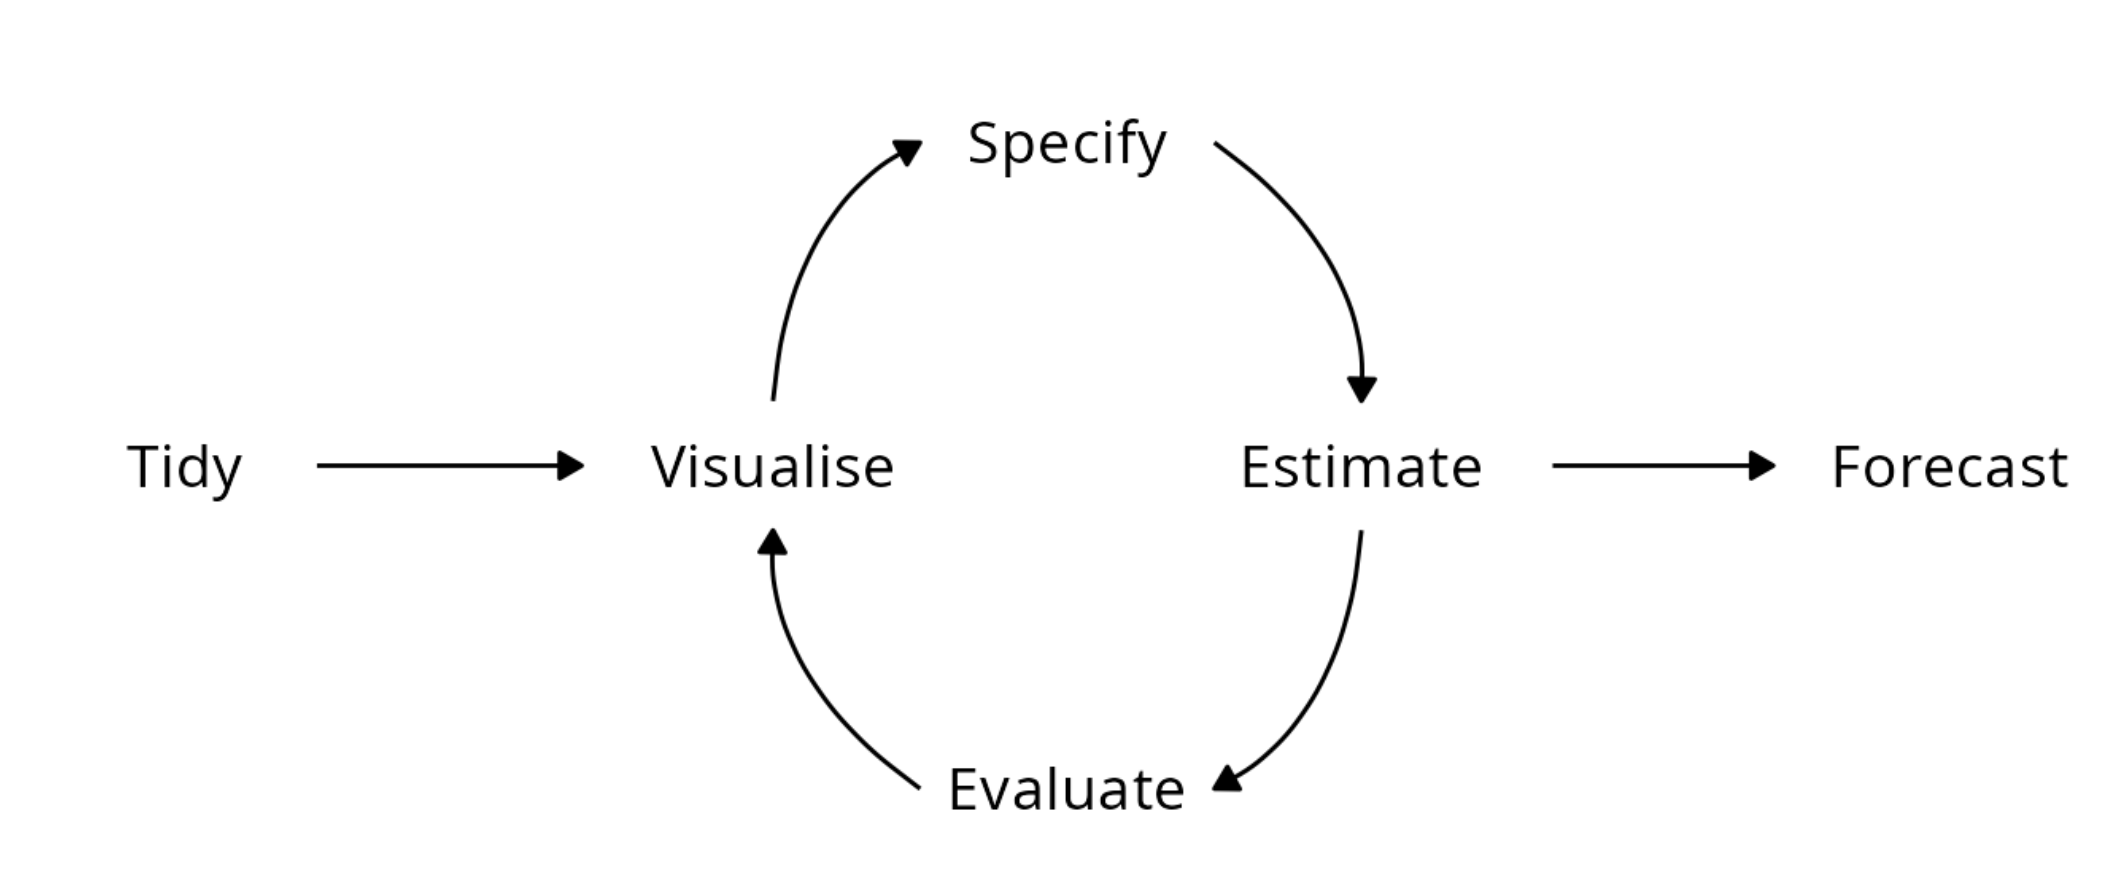



# 1. Prepare the data (cleaning, formatting) this was done in 
C:\Users\dylan\Trying hard\Tryhard\100%\Preprocessing.ipynb 

# 2. Visualize to identify patterns

to visualize and identify patterns in the data, we will use:
1. time series plots: here we can see 
these plots enable many features of the data to be visualised, including patterns, unusual observations, changes over time, and relationships between variables.
2. Scatterplot matrix:
    is used to explore relationships between time series.
3. Correlation matrix:
    is used to explore relationships between time series.

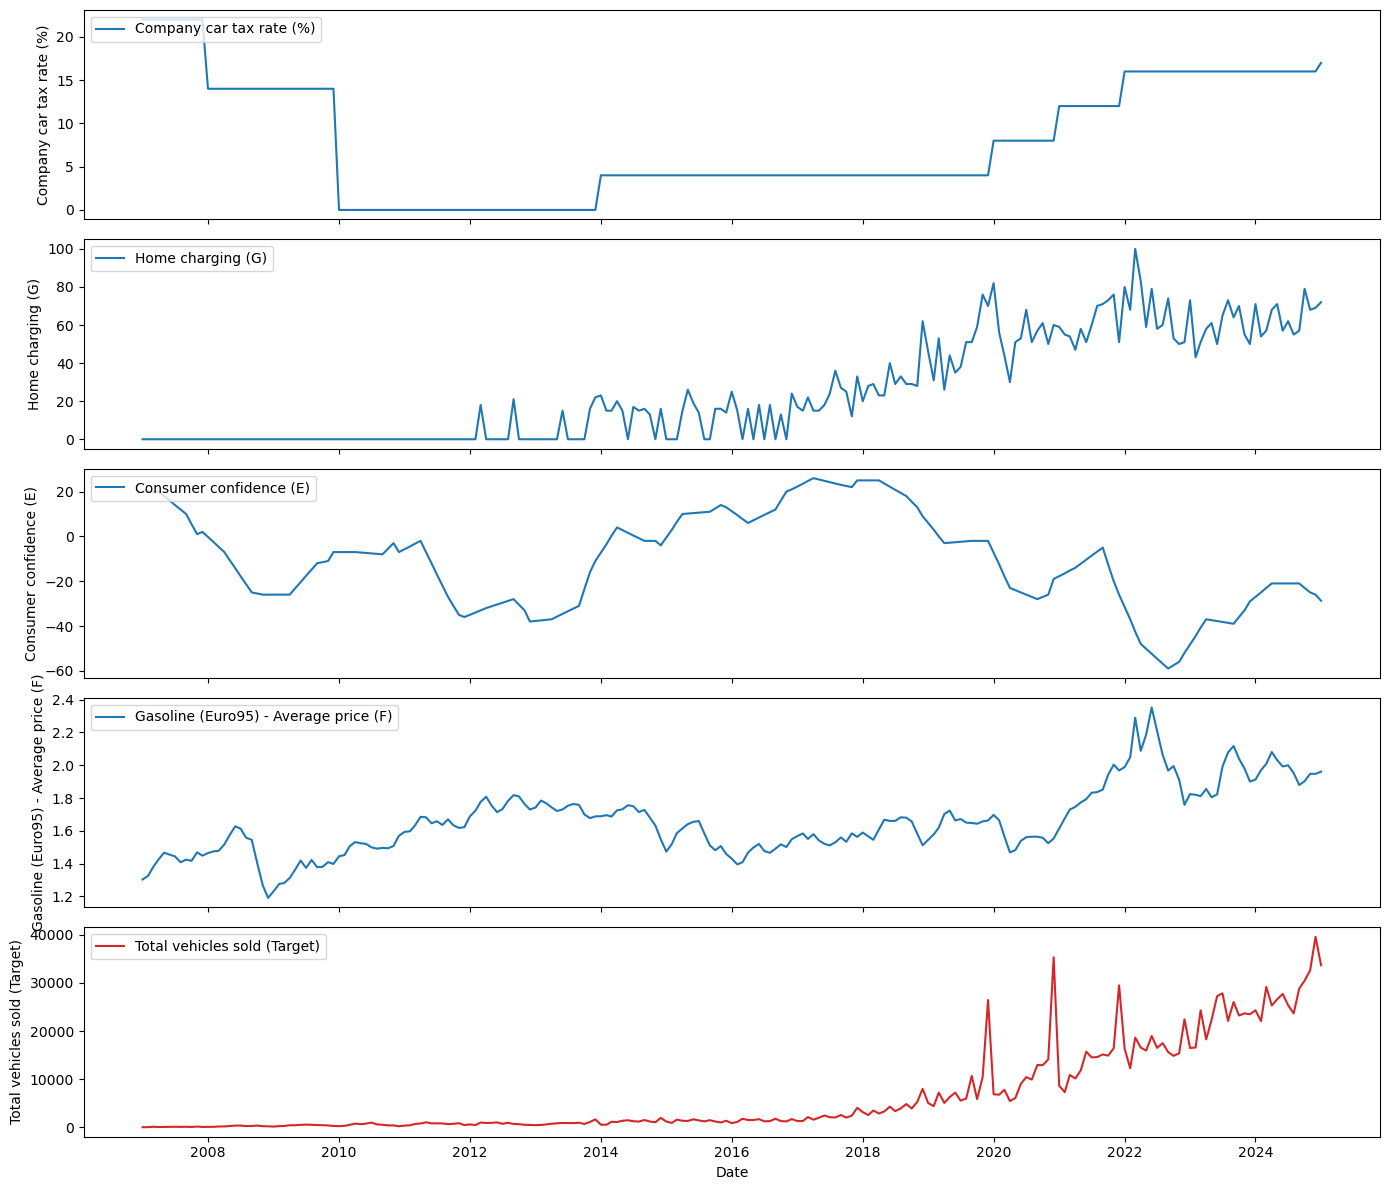

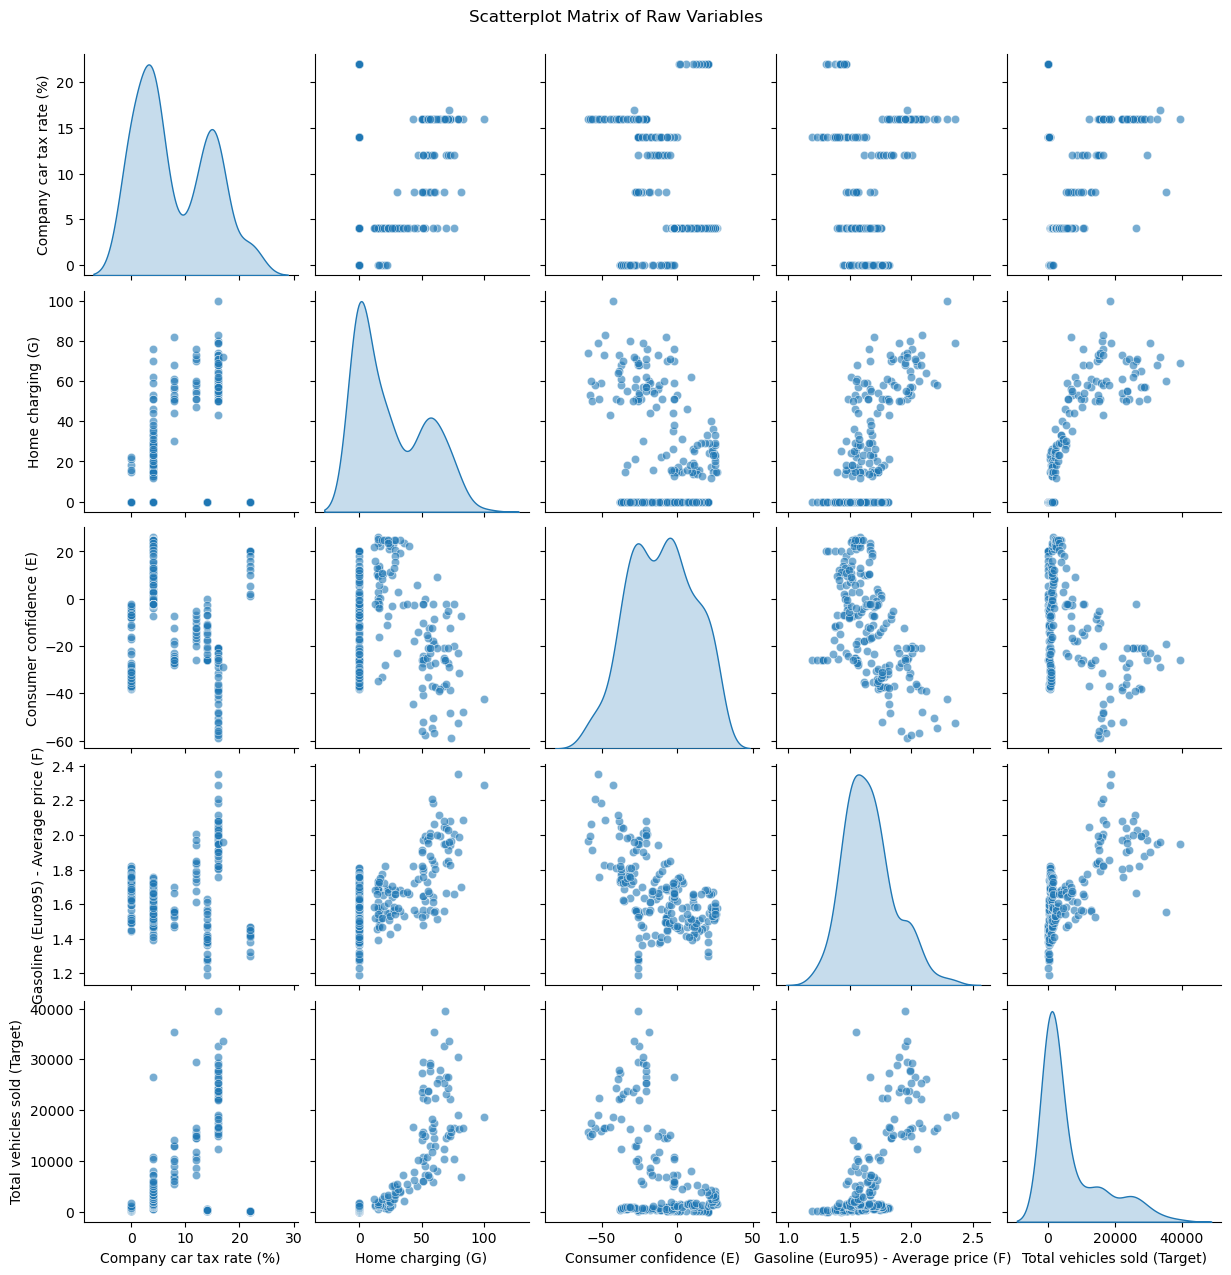

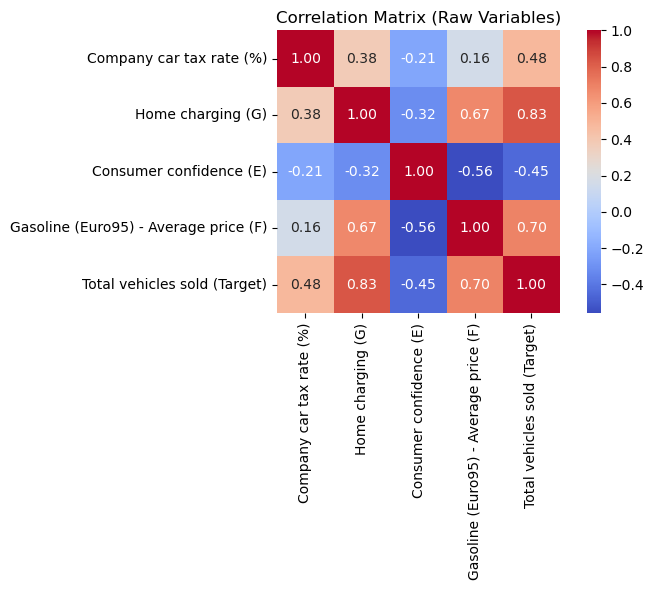

In [3]:
# Define features and target
features = ['Company car tax rate (%)', 'Home charging (G)', 'Consumer confidence (E)', 'Gasoline (Euro95) - Average price (F)']
target = 'Total vehicles sold (Target)'

fig, axs = plt.subplots(len(features) + 1, 1, figsize=(14, 12), sharex=True)

for i, col in enumerate(features):
    axs[i].plot(df["Time Period (T)"], df[col], label=col)
    axs[i].set_ylabel(col)
    axs[i].legend(loc="upper left")

axs[-1].plot(df["Time Period (T)"], df[target], label=target, color='tab:red')
axs[-1].set_ylabel(target)
axs[-1].set_xlabel("Date")
axs[-1].legend(loc="upper left")

plt.tight_layout()
plt.show()

# Scatterplot matrix (pairplot) for all features and target
sns.pairplot(df[features + [target]], diag_kind="kde", plot_kws={'alpha':0.6})
plt.suptitle("Scatterplot Matrix of Raw Variables", y=1.02)
plt.show()

# Correlation matrix for all features and target
corr_matrix = df[features + [target]].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix (Raw Variables)")
plt.tight_layout()
plt.show()


> Talk about Trends: upward or downward drift over years.

Seasonality: recurring cycles (e.g., year-end sales spike).

Structural breaks: sudden shifts or regime changes.

Outliers: one-off jumps or drops.

key observations from the scattorplot matrix:

- Home charging and gasoline price show a moderately positive association with total vehicles sold, as indicated by the upward trend in their scatterplots.

- Company car tax rate appears to have a non-linear relationship with total vehicles sold; vehicle sales tend to increase when tax rates are lower.

- Consumer confidence shows a weaker, noisier relationship with vehicle sales, though a vague upward trend is present.

- Home charging shows strong positive correlation with gasoline prices, potentially reflecting a structural shift in energy preference.

# 3. Model Specification (NOG Afmaken)



My baseline approach will be: .... and  will integrate exogenous drivers:
using Arima, 

# 4. Data Split & Transformations

## 4a Apply train/val/test split

In [4]:
# Define features and target (raw data)
features_raw = ['Company car tax rate (%)', 'Home charging (G)', 'Consumer confidence (E)', 'Gasoline (Euro95) - Average price (F)']
target_raw = 'Total vehicles sold (Target)'

# Calculate split indices
n = len(df)
train_end = int(n * 0.8)
val_end = int(n * 0.9)

# Split the target (raw)
y_raw = df[target_raw]
y_train_raw = y_raw.iloc[:train_end]
y_val_raw = y_raw.iloc[train_end:val_end]
y_test_raw = y_raw.iloc[val_end:]

# Split each feature separately (raw)
companytax_train_raw = df['Company car tax rate (%)'].iloc[:train_end]
companytax_val_raw = df['Company car tax rate (%)'].iloc[train_end:val_end]
companytax_test_raw = df['Company car tax rate (%)'].iloc[val_end:]

homechg_train_raw = df['Home charging (G)'].iloc[:train_end]
homechg_val_raw = df['Home charging (G)'].iloc[train_end:val_end]
homechg_test_raw = df['Home charging (G)'].iloc[val_end:]

conf_train_raw = df['Consumer confidence (E)'].iloc[:train_end]
conf_val_raw = df['Consumer confidence (E)'].iloc[train_end:val_end]
conf_test_raw = df['Consumer confidence (E)'].iloc[val_end:]

gas_train_raw = df['Gasoline (Euro95) - Average price (F)'].iloc[:train_end]
gas_val_raw = df['Gasoline (Euro95) - Average price (F)'].iloc[train_end:val_end]
gas_test_raw = df['Gasoline (Euro95) - Average price (F)'].iloc[val_end:]


# Print sizes
print(f"Train: {df['Time Period (T)'].iloc[y_train_raw.index[0]]} to {df['Time Period (T)'].iloc[y_train_raw.index[-1]]} | {len(y_train_raw)/n:.1%} of data")
print(f"Val:   {df['Time Period (T)'].iloc[y_val_raw.index[0]]} to {df['Time Period (T)'].iloc[y_val_raw.index[-1]]} | {len(y_val_raw)/n:.1%} of data")
print(f"Test:  {df['Time Period (T)'].iloc[y_test_raw.index[0]]} to {df['Time Period (T)'].iloc[y_test_raw.index[-1]]} | {len(y_test_raw)/n:.1%} of data")
print(f"Train size: {len(y_train_raw)}, Val size: {len(y_val_raw)}, Test size: {len(y_test_raw)}")




Train: 2007-01-01 00:00:00 to 2021-05-01 00:00:00 | 79.7% of data
Val:   2021-06-01 00:00:00 to 2023-03-01 00:00:00 | 10.1% of data
Test:  2023-04-01 00:00:00 to 2025-01-01 00:00:00 | 10.1% of data
Train size: 173, Val size: 22, Test size: 22


#### Deze plot zou ook weggelaten kunnen worden 

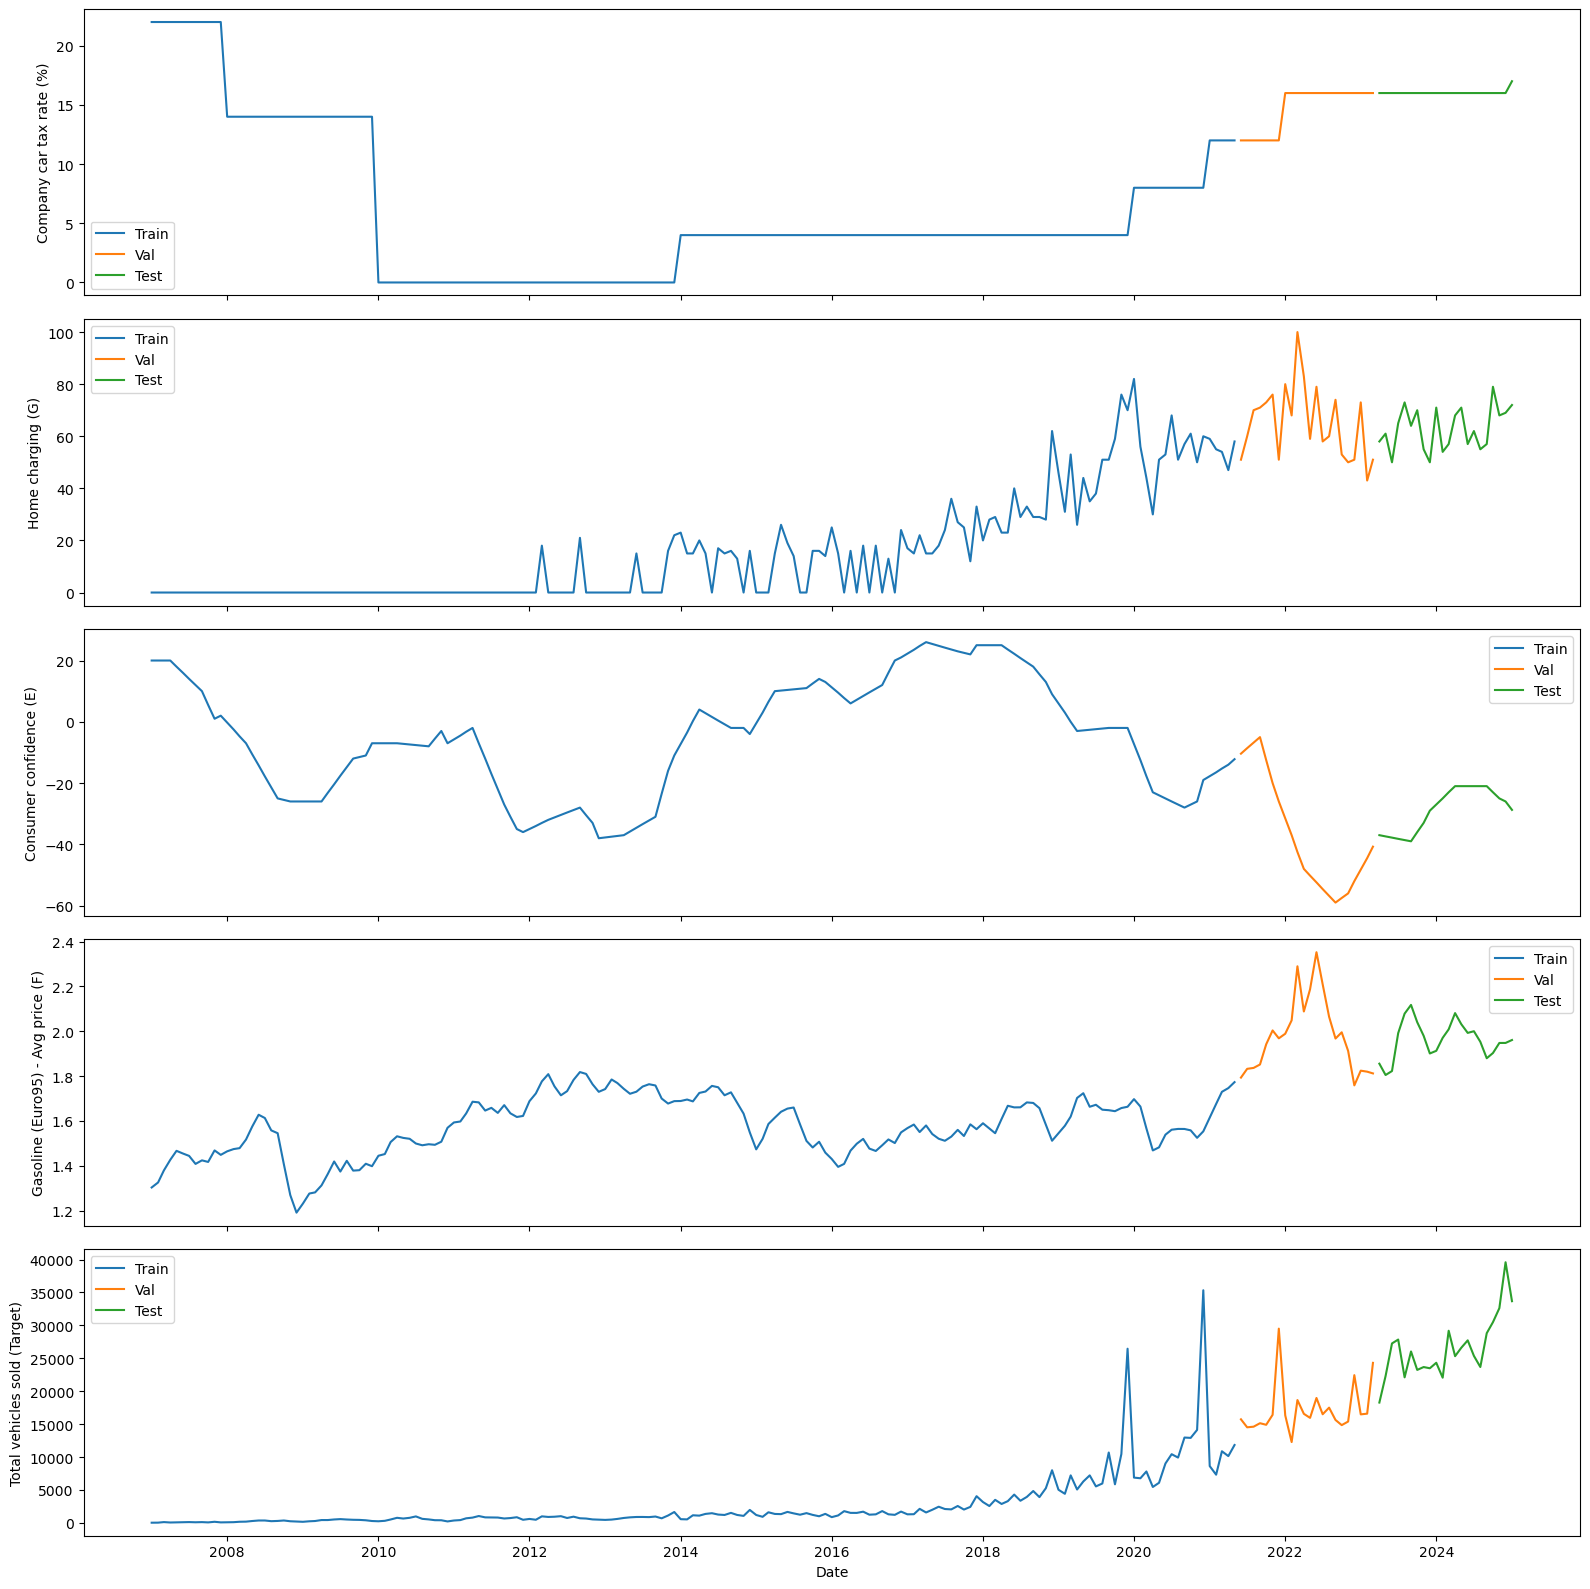

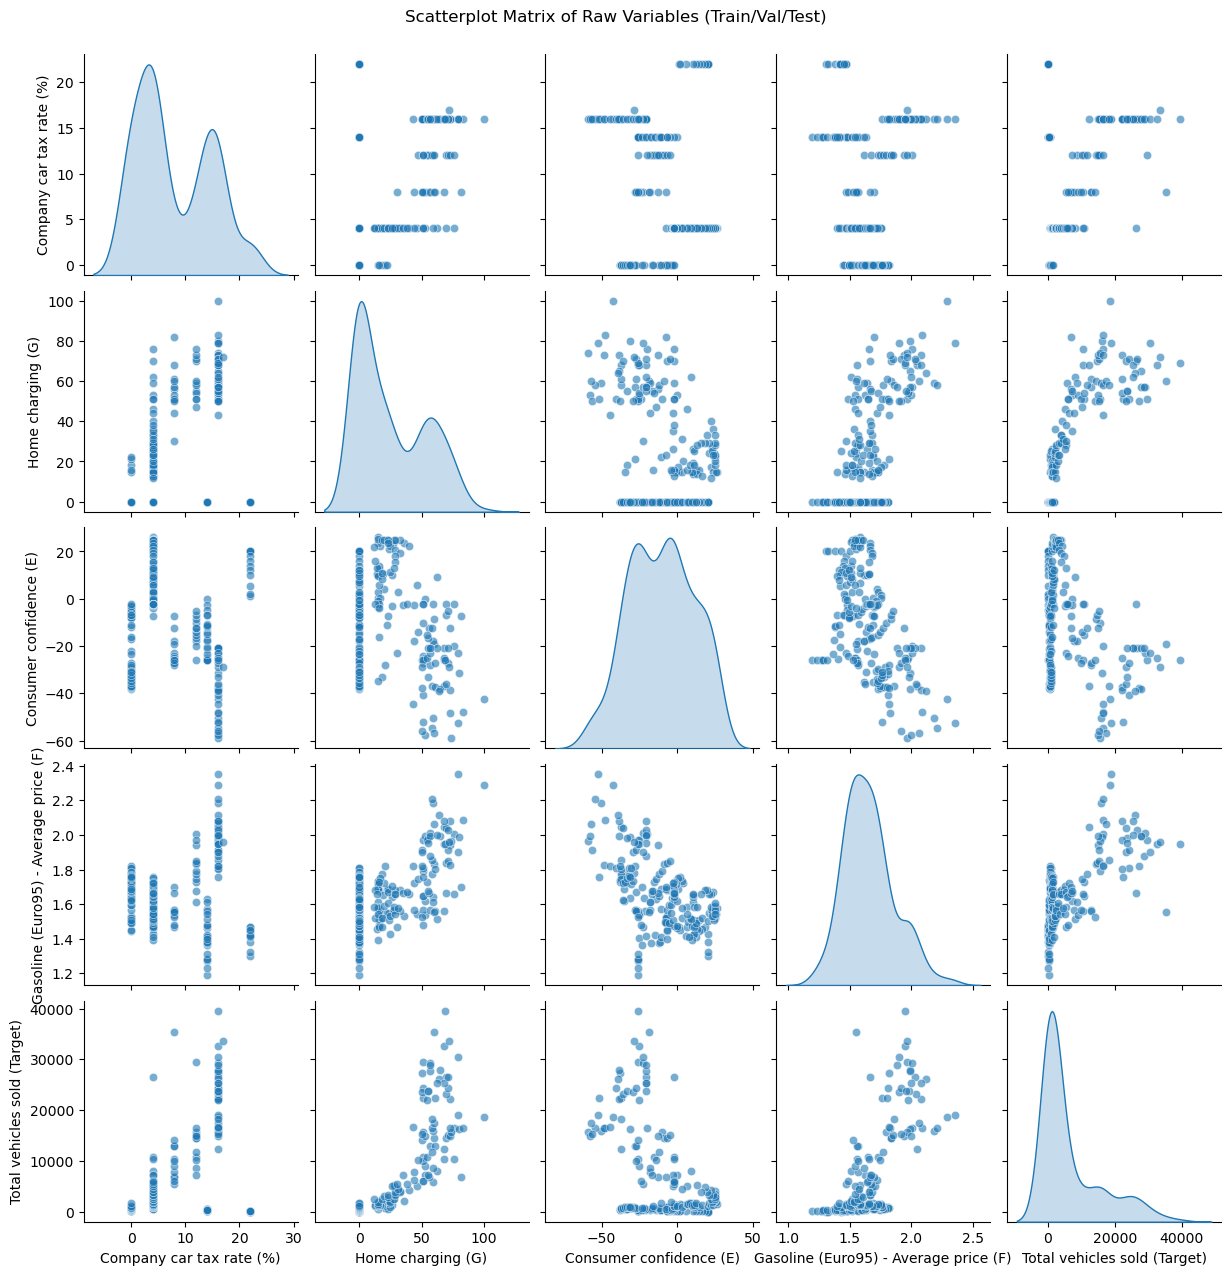

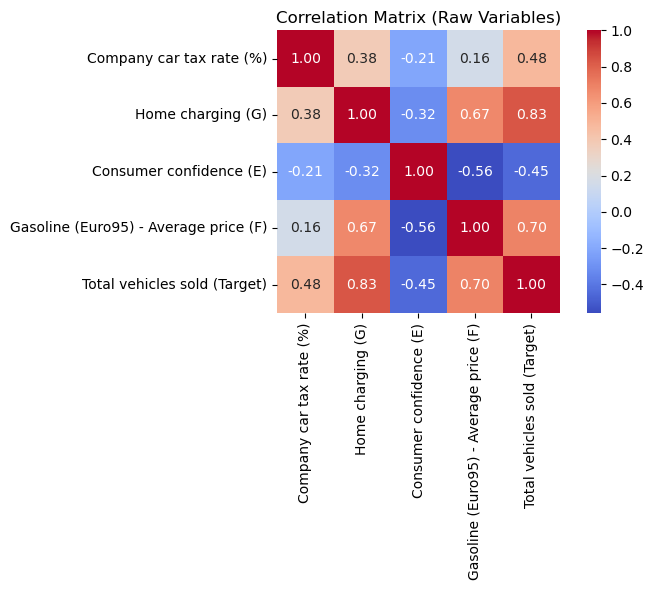

In [5]:
import seaborn as sns


fig, axs = plt.subplots(5, 1, figsize=(16, 16), sharex=True)

# 1. Company car tax rate (%)
axs[0].plot(df['Time Period (T)'].iloc[:train_end], companytax_train_raw, label='Train')
axs[0].plot(df['Time Period (T)'].iloc[train_end:val_end], companytax_val_raw, label='Val')
axs[0].plot(df['Time Period (T)'].iloc[val_end:], companytax_test_raw, label='Test')
axs[0].set_ylabel('Company car tax rate (%)')
axs[0].legend()

# 2. Home charging (G)
axs[1].plot(df['Time Period (T)'].iloc[:train_end], homechg_train_raw, label='Train')
axs[1].plot(df['Time Period (T)'].iloc[train_end:val_end], homechg_val_raw, label='Val')
axs[1].plot(df['Time Period (T)'].iloc[val_end:], homechg_test_raw, label='Test')
axs[1].set_ylabel('Home charging (G)')
axs[1].legend()

# 3. Consumer confidence (E)
axs[2].plot(df['Time Period (T)'].iloc[:train_end], conf_train_raw, label='Train')
axs[2].plot(df['Time Period (T)'].iloc[train_end:val_end], conf_val_raw, label='Val')
axs[2].plot(df['Time Period (T)'].iloc[val_end:], conf_test_raw, label='Test')
axs[2].set_ylabel('Consumer confidence (E)')
axs[2].legend()

# 4. Gasoline (Euro95) - Average price (F)
axs[3].plot(df['Time Period (T)'].iloc[:train_end], gas_train_raw, label='Train')
axs[3].plot(df['Time Period (T)'].iloc[train_end:val_end], gas_val_raw, label='Val')
axs[3].plot(df['Time Period (T)'].iloc[val_end:], gas_test_raw, label='Test')
axs[3].set_ylabel('Gasoline (Euro95) - Avg price (F)')
axs[3].legend()

# 5. Total vehicles sold (Target)
axs[4].plot(df['Time Period (T)'].iloc[:train_end], y_train_raw, label='Train')
axs[4].plot(df['Time Period (T)'].iloc[train_end:val_end], y_val_raw, label='Val')
axs[4].plot(df['Time Period (T)'].iloc[val_end:], y_test_raw, label='Test')
axs[4].set_ylabel('Total vehicles sold (Target)')
axs[4].set_xlabel('Date')
axs[4].legend()

plt.tight_layout()
plt.show()

# Scatter plot matrix (pairplot) for all features and target (raw splits)

sns.pairplot(df[features_raw + [target_raw]], diag_kind="kde", plot_kws={'alpha':0.6})
plt.suptitle("Scatterplot Matrix of Raw Variables (Train/Val/Test)", y=1.02)
plt.show()

# Correlation matrix for all features and target (raw splits)
corr_matrix = df[features_raw + [target_raw]].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix (Raw Variables)")
plt.tight_layout()
plt.show()


> Since there is alot of varience i will add boxcox transformation to the data, this will help to stabilize the variance and make the data more suitable for modeling.

## 4b Yeo–Johnson transformation 

Yeo–Johnson (like Box–Cox) primarily targets skewness—it finds a power transform that makes the distribution more symmetric and stabilizes variance globally. But time‐series variance often shifts because of:

Trends or level changes

Seasonal effects (e.g. summer peaks vs. winter troughs)

Structural breaks or exogenous shocks

In [10]:
# 1. Fit Yeo–Johnson on train, transform all
from sklearn.preprocessing import PowerTransformer


features_yj = features_raw.copy()
target_yj = target_raw

yeojohnson_all = {}
yeojohnson_lambdas_all = {}

for col in features_yj + [target_yj]:
    train_series = df[col].iloc[:train_end].values.reshape(-1, 1)
    pt = PowerTransformer(method='yeo-johnson', standardize=False)
    pt.fit(train_series)
    yeojohnson_lambdas_all[col] = pt.lambdas_[0]
    full_series = df[col].values.reshape(-1, 1)
    transformed_full = pt.transform(full_series).flatten()
    yeojohnson_all[col] = transformed_full

# 2. Make transformed DataFrame
yj_df = pd.DataFrame({col: yeojohnson_all[col] for col in features_yj + [target_yj]})

# 3. Define split indices for YJ (same logic as raw)
n_yj = len(yj_df)
train_end_yj = int(n_yj * 0.8)
val_end_yj   = int(n_yj * 0.9)
test_end_yj  = n_yj  # for completeness

# 4. Split Yeo–Johnson-transformed data (with _yj suffix)
y_train_yj = yj_df[target_yj].iloc[:train_end_yj]
y_val_yj   = yj_df[target_yj].iloc[train_end_yj:val_end_yj]
y_test_yj  = yj_df[target_yj].iloc[val_end_yj:]

companytax_train_yj = yj_df['Company car tax rate (%)'].iloc[:train_end_yj]
companytax_val_yj   = yj_df['Company car tax rate (%)'].iloc[train_end_yj:val_end_yj]
companytax_test_yj  = yj_df['Company car tax rate (%)'].iloc[val_end_yj:]

homechg_train_yj = yj_df['Home charging (G)'].iloc[:train_end_yj]
homechg_val_yj   = yj_df['Home charging (G)'].iloc[train_end_yj:val_end_yj]
homechg_test_yj  = yj_df['Home charging (G)'].iloc[val_end_yj:]

conf_train_yj = yj_df['Consumer confidence (E)'].iloc[:train_end_yj]
conf_val_yj   = yj_df['Consumer confidence (E)'].iloc[train_end_yj:val_end_yj]
conf_test_yj  = yj_df['Consumer confidence (E)'].iloc[val_end_yj:]

gas_train_yj = yj_df['Gasoline (Euro95) - Average price (F)'].iloc[:train_end_yj]
gas_val_yj   = yj_df['Gasoline (Euro95) - Average price (F)'].iloc[train_end_yj:val_end_yj]
gas_test_yj  = yj_df['Gasoline (Euro95) - Average price (F)'].iloc[val_end_yj:]

# Print split info for YJ
print(f"YJ Train: {train_end_yj} rows | {train_end_yj/n_yj:.1%} of data")
print(f"YJ Val:   {val_end_yj-train_end_yj} rows | {(val_end_yj-train_end_yj)/n_yj:.1%} of data")
print(f"YJ Test:  {test_end_yj-val_end_yj} rows | {(test_end_yj-val_end_yj)/n_yj:.1%} of data")

for col, lam in yeojohnson_lambdas_all.items():
    print(f"{col:40s}  λ = {lam:.4f}")


YJ Train: 173 rows | 79.7% of data
YJ Val:   22 rows | 10.1% of data
YJ Test:  22 rows | 10.1% of data
Company car tax rate (%)                  λ = 0.1486
Home charging (G)                         λ = -0.1635
Consumer confidence (E)                   λ = 1.0165
Gasoline (Euro95) - Average price (F)     λ = 3.9445
Total vehicles sold (Target)              λ = -0.0036


In [12]:
import pandas as pd

comparison = []
for col in features_yj + [target_yj]:
    raw = df[col]
    yj  = yj_df[col]
    comparison.append({
        "variable": col,
        "skew_raw": raw.skew(),
        "skew_yj":  yj.skew(),
        "λ":         yeojohnson_lambdas_all[col]
    })
pd.DataFrame(comparison).round(3)
print(pd.DataFrame(comparison).round(3))

                                variable  skew_raw  skew_yj      λ
0               Company car tax rate (%)     0.458   -0.408  0.149
1                      Home charging (G)     0.645   -0.236 -0.164
2                Consumer confidence (E)    -0.061    0.014  1.017
3  Gasoline (Euro95) - Average price (F)     0.661    1.354  3.945
4           Total vehicles sold (Target)     1.561    0.001 -0.004


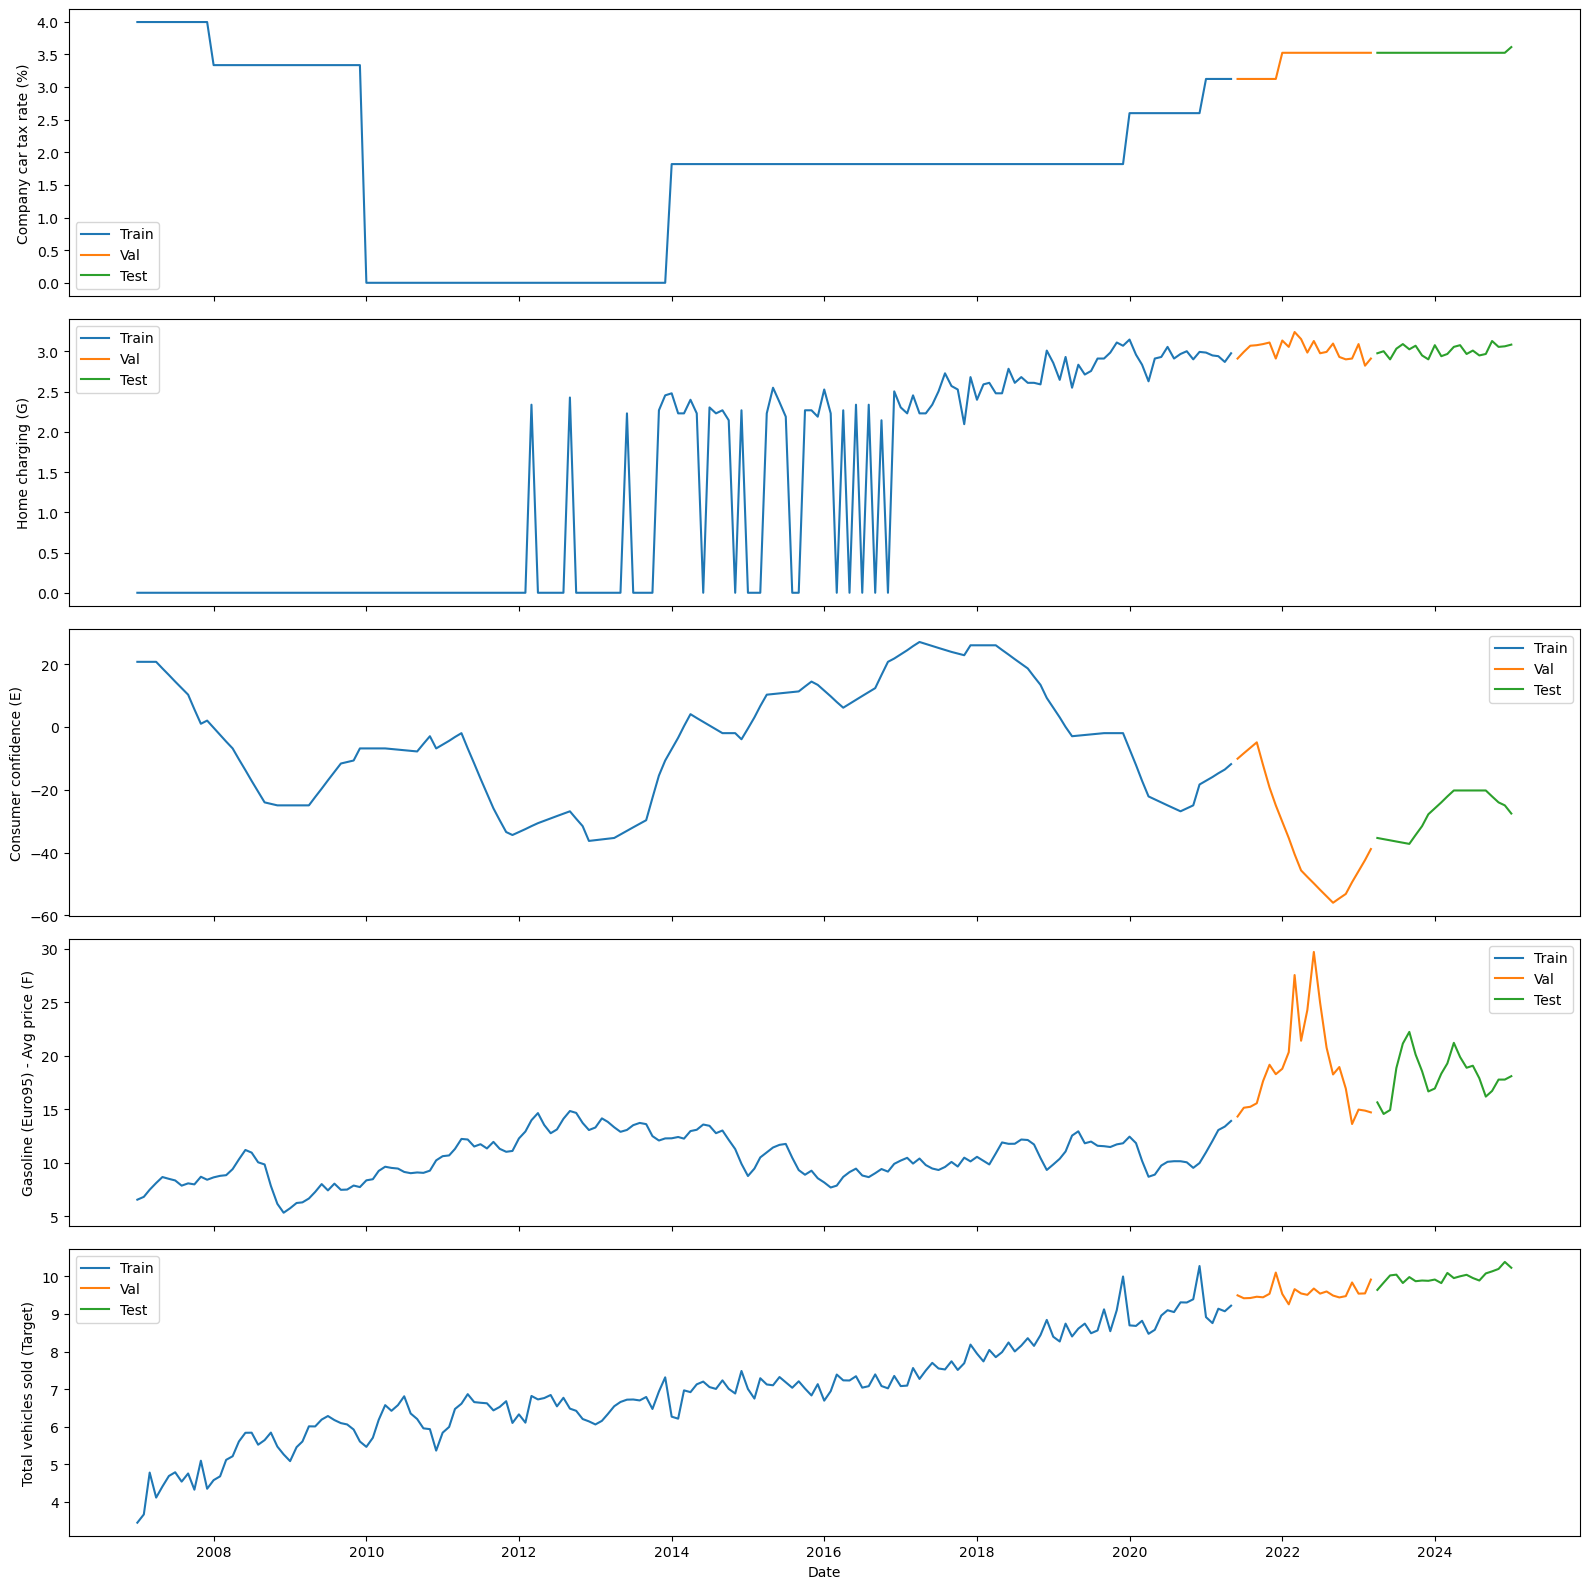

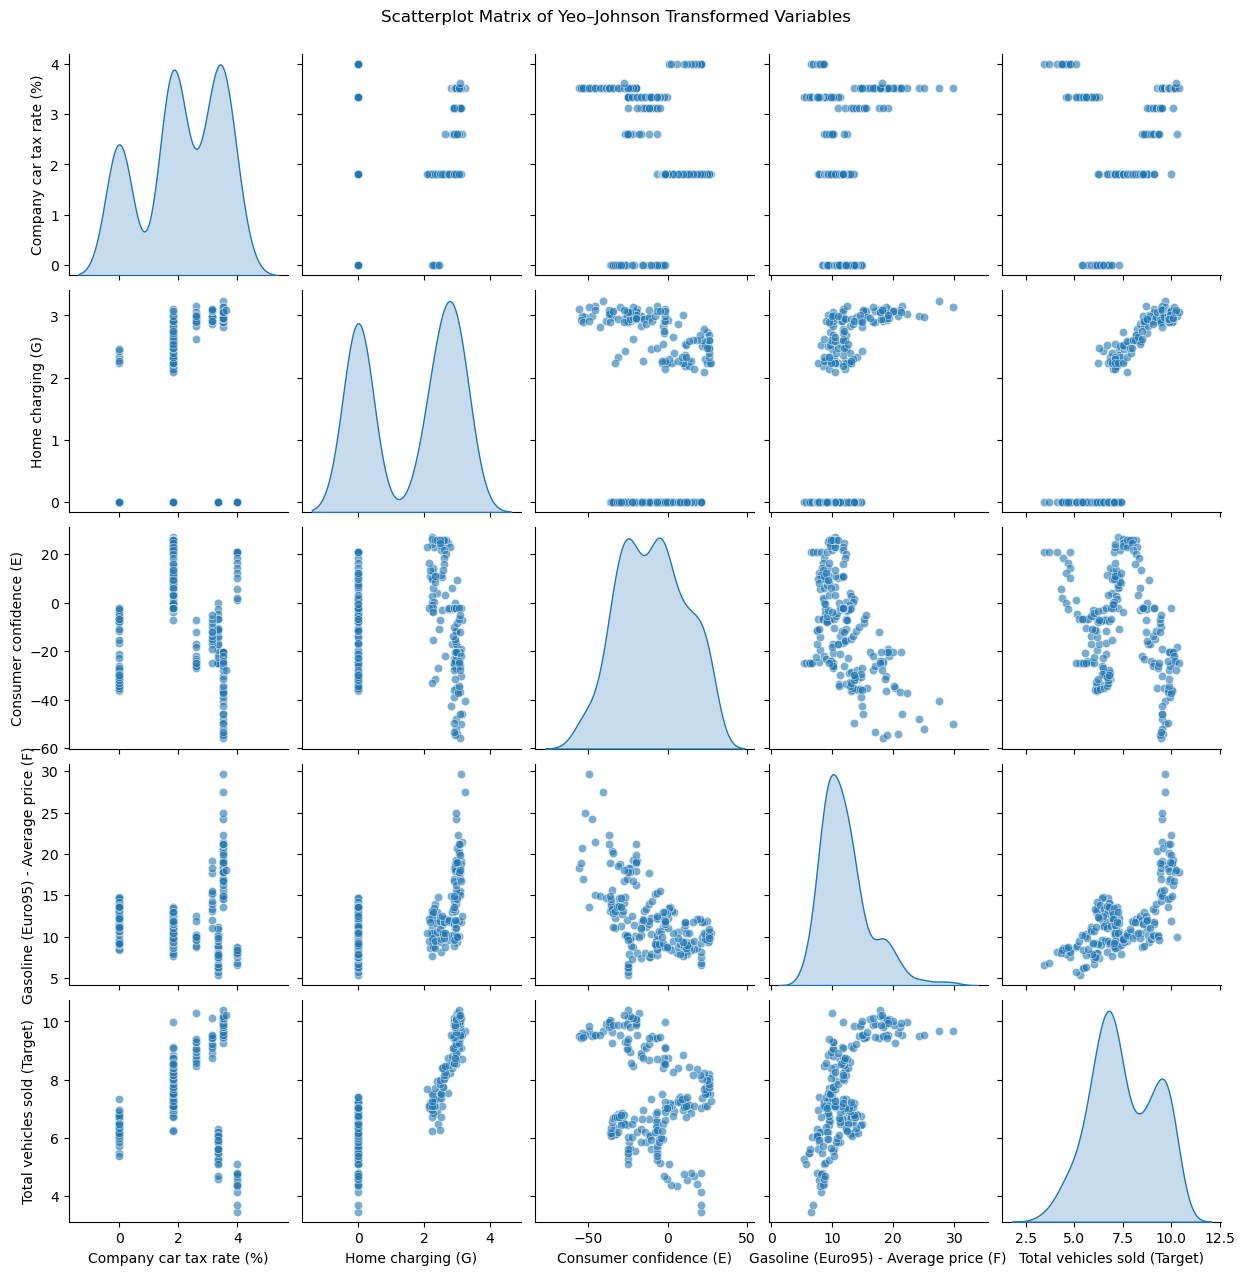

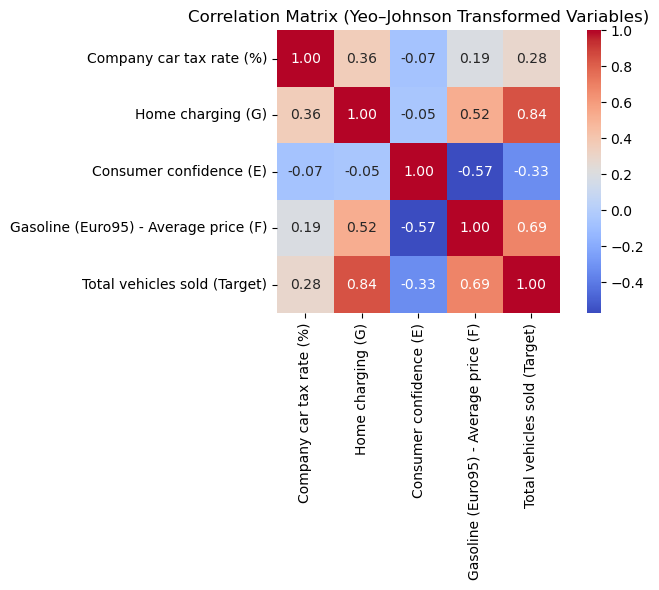

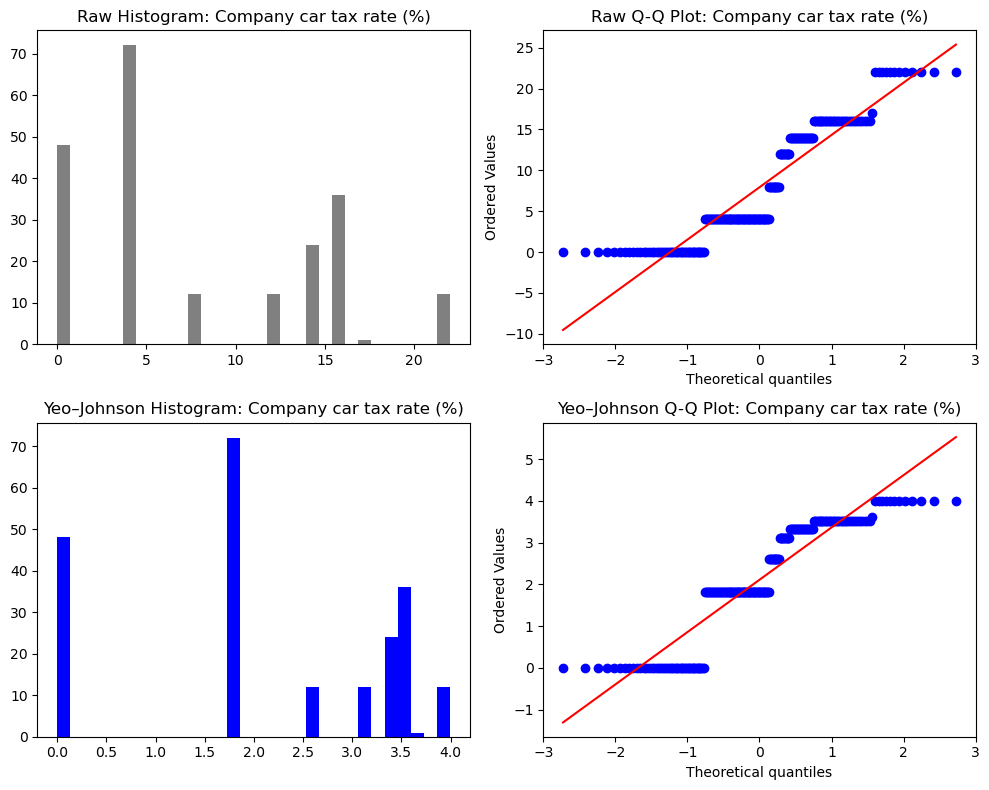

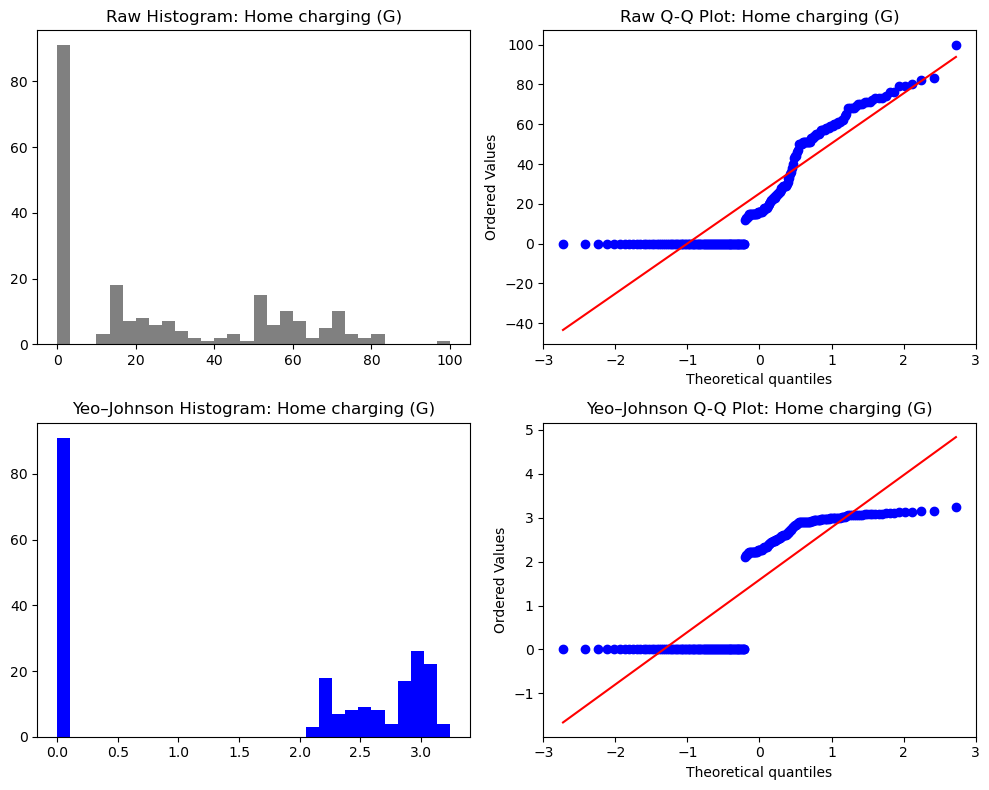

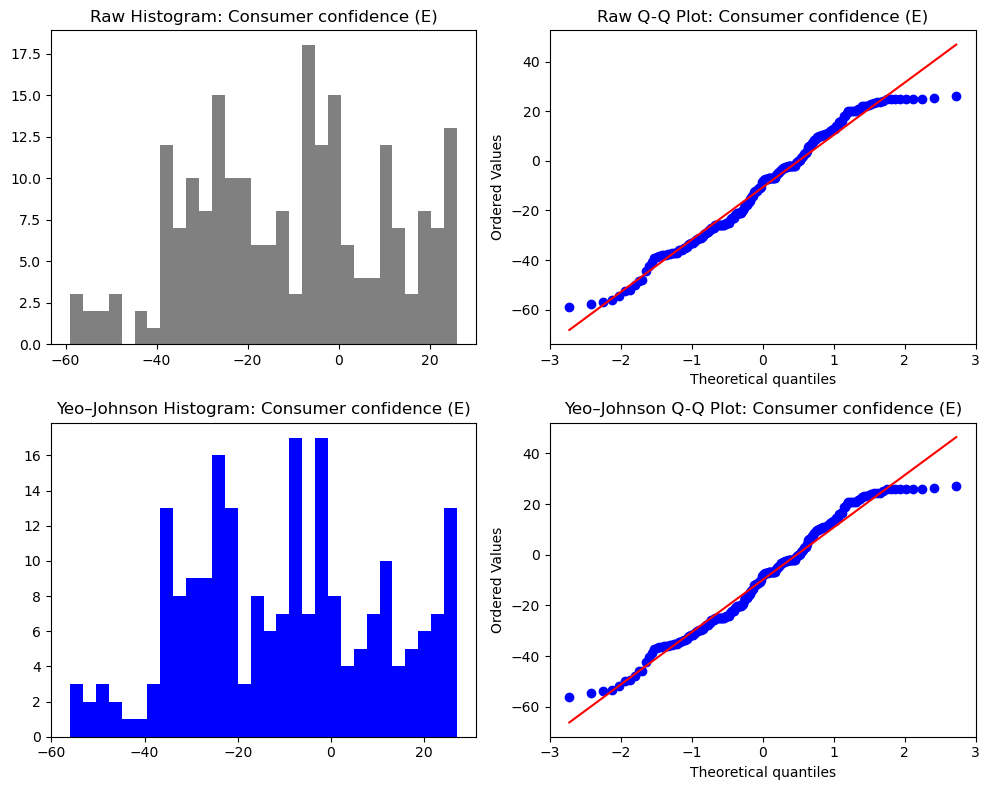

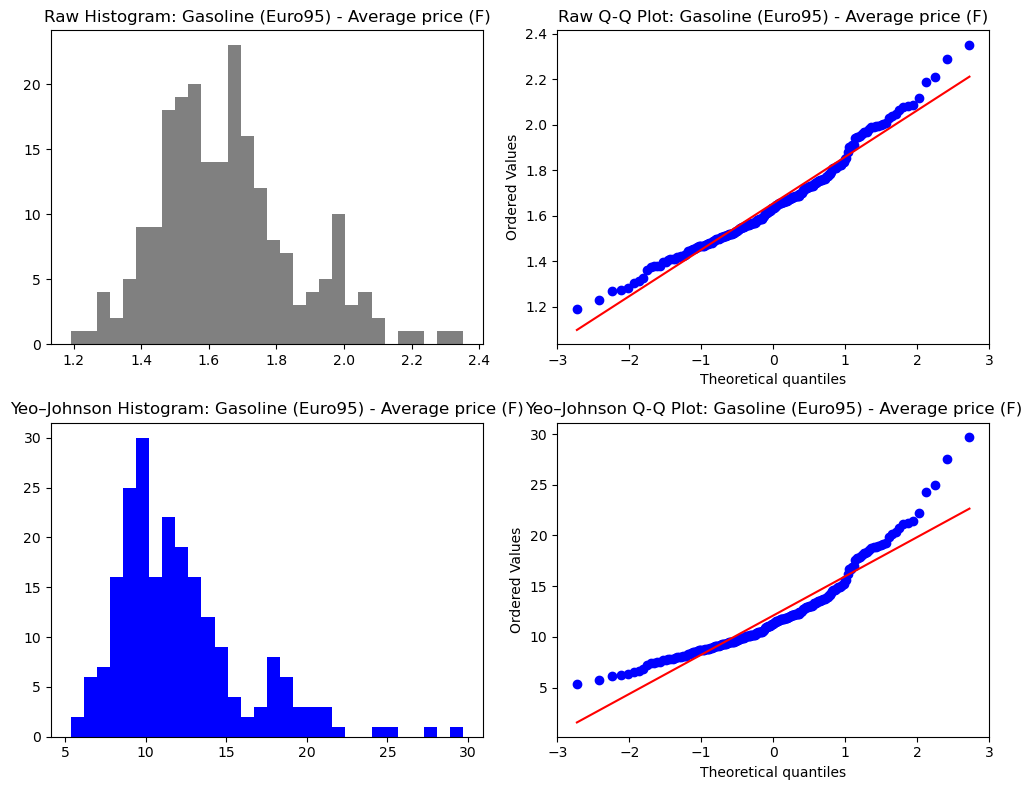

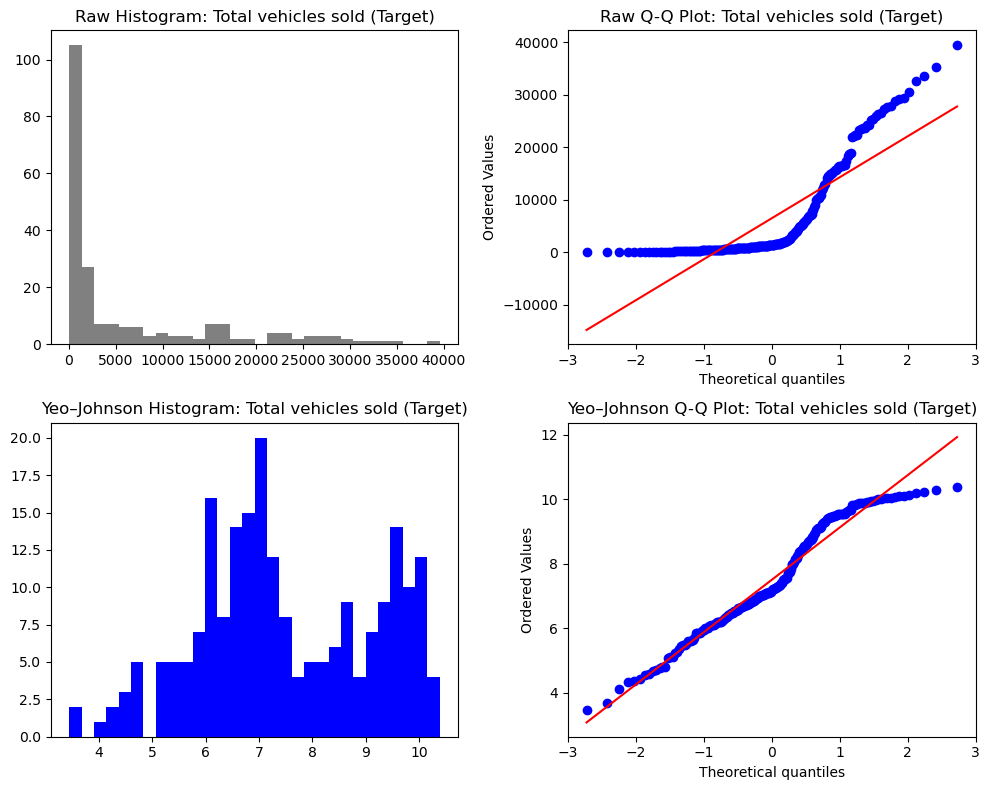

In [9]:
fig, axs = plt.subplots(5, 1, figsize=(16, 16), sharex=True)

time_index = df['Time Period (T)']

# 1. Company car tax rate (%)
axs[0].plot(time_index.iloc[:train_end_yj], companytax_train_yj, label='Train')
axs[0].plot(time_index.iloc[train_end_yj:val_end_yj], companytax_val_yj, label='Val')
axs[0].plot(time_index.iloc[val_end_yj:], companytax_test_yj, label='Test')
axs[0].set_ylabel('Company car tax rate (%)')
axs[0].legend()

# 2. Home charging (G)
axs[1].plot(time_index.iloc[:train_end_yj], homechg_train_yj, label='Train')
axs[1].plot(time_index.iloc[train_end_yj:val_end_yj], homechg_val_yj, label='Val')
axs[1].plot(time_index.iloc[val_end_yj:], homechg_test_yj, label='Test')
axs[1].set_ylabel('Home charging (G)')
axs[1].legend()

# 3. Consumer confidence (E)
axs[2].plot(time_index.iloc[:train_end_yj], conf_train_yj, label='Train')
axs[2].plot(time_index.iloc[train_end_yj:val_end_yj], conf_val_yj, label='Val')
axs[2].plot(time_index.iloc[val_end_yj:], conf_test_yj, label='Test')
axs[2].set_ylabel('Consumer confidence (E)')
axs[2].legend()

# 4. Gasoline (Euro95) - Average price (F)
axs[3].plot(time_index.iloc[:train_end_yj], gas_train_yj, label='Train')
axs[3].plot(time_index.iloc[train_end_yj:val_end_yj], gas_val_yj, label='Val')
axs[3].plot(time_index.iloc[val_end_yj:], gas_test_yj, label='Test')
axs[3].set_ylabel('Gasoline (Euro95) - Avg price (F)')
axs[3].legend()

# 5. Total vehicles sold (Target)
axs[4].plot(time_index.iloc[:train_end_yj], y_train_yj, label='Train')
axs[4].plot(time_index.iloc[train_end_yj:val_end_yj], y_val_yj, label='Val')
axs[4].plot(time_index.iloc[val_end_yj:], y_test_yj, label='Test')
axs[4].set_ylabel('Total vehicles sold (Target)')
axs[4].set_xlabel('Date')
axs[4].legend()

plt.tight_layout()
plt.show()

# --- Scatter plot matrix (pairplot) op Yeo-Johnson getransformeerde features + target ---
sns.pairplot(yj_df, diag_kind="kde", plot_kws={'alpha': 0.6})
plt.suptitle("Scatterplot Matrix of Yeo–Johnson Transformed Variables", y=1.02)
plt.show()

# --- Correlatiematrix ---
corr_matrix_yj = yj_df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix_yj, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix (Yeo–Johnson Transformed Variables)")
plt.tight_layout()
plt.show()

for col in features + [target]:
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))
    # Raw
    axs[0, 0].hist(df[col], bins=30, color='gray')
    axs[0, 0].set_title(f'Raw Histogram: {col}')
    stats.probplot(df[col], dist="norm", plot=axs[0, 1])
    axs[0, 1].set_title(f'Raw Q-Q Plot: {col}')
    # Yeo–Johnson
    axs[1, 0].hist(yj_df[col], bins=30, color='blue')
    axs[1, 0].set_title(f'Yeo–Johnson Histogram: {col}')
    stats.probplot(yj_df[col], dist="norm", plot=axs[1, 1])
    axs[1, 1].set_title(f'Yeo–Johnson Q-Q Plot: {col}')
    plt.tight_layout()
    plt.show()


The Yeo–Johnson code fits the transformer only on the training subset, then applies those learned parameters to the full series. That approach does not leak information from validation or test sets back into the model.

## 4c Stationarity Tests

After plotting and splitting the data its time for staionality tests. 

Since Arima models rely on past autocorrelations to make predictions, they assume stationality in the data.

A stationary time series is one whose statistical properties do not depend on the time at which the series is observed. observing the previous plots, we can see non stationality in the data by some upward trends and seasonality. 

Visually, stationary series tend to look flat and horizontal, possibly with random fluctuations or irregular cycles, but without consistent upward/downward trends or recurring patterns.

There are a few tests to check for stationarity, the most common ones are:
- **Augmented Dickey-Fuller (ADF) test**: Tests the null hypothesis that a unit root is present in the time series, indicating non-stationarity. A low p-value (typically < 0.05) suggests that the series is stationary.
- **Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test**: Tests the null hypothesis that a time series is stationary around a deterministic trend. A high p-value (typically > 0.05) suggests stationarity.
plotting the ACF and PACF plots can also help to identify stationarity.

ADF focuses on detecting a unit root (non-stationarity) under the null hypothesis.

KPSS assumes stationarity under the null hypothesis.
because 




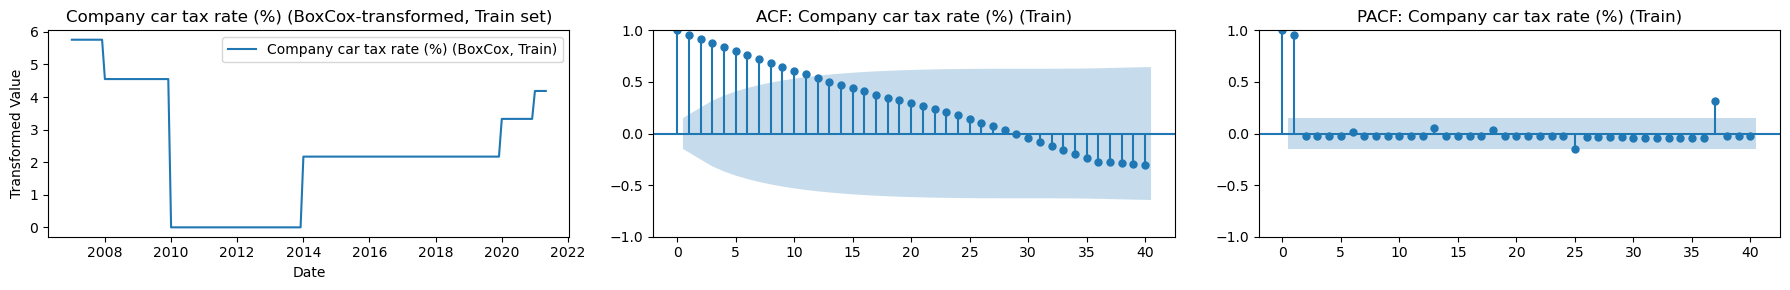

==== Company car tax rate (%) ====
ADF Statistic: -1.9616509753433216
ADF p-value: 0.3036366851664807
ADF Critical Value (1%): -3.4690
ADF Critical Value (5%): -2.8785
ADF Critical Value (10%): -2.5758
ADF: The series is likely non-stationary (fail to reject H0).
KPSS Statistic: 0.3745620074363245
KPSS p-value: 0.0881198243808946
KPSS Critical Value (10%): 0.3470
KPSS Critical Value (5%): 0.4630
KPSS Critical Value (2.5%): 0.5740
KPSS Critical Value (1%): 0.7390
KPSS: The series is likely stationary (fail to reject H0).



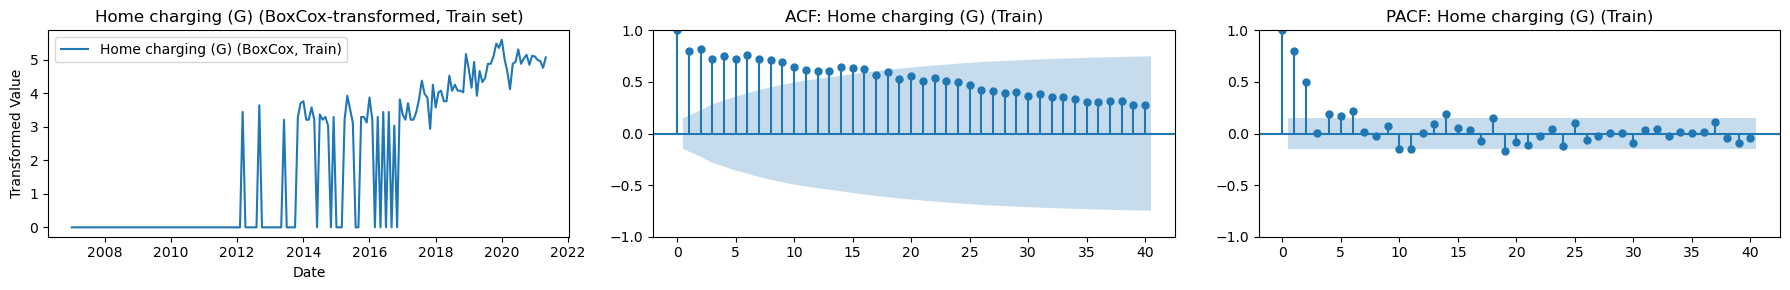

C:\Users\dylan\AppData\Local\Temp\ipykernel_27852\2068862521.py:29: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(train_bc, regression='c', nlags="auto")


==== Home charging (G) ====
ADF Statistic: -0.20937322979102604
ADF p-value: 0.9373950918228283
ADF Critical Value (1%): -3.4722
ADF Critical Value (5%): -2.8799
ADF Critical Value (10%): -2.5766
ADF: The series is likely non-stationary (fail to reject H0).
KPSS Statistic: 1.8545194253954822
KPSS p-value: 0.01
KPSS Critical Value (10%): 0.3470
KPSS Critical Value (5%): 0.4630
KPSS Critical Value (2.5%): 0.5740
KPSS Critical Value (1%): 0.7390
KPSS: The series is likely non-stationary (reject H0).



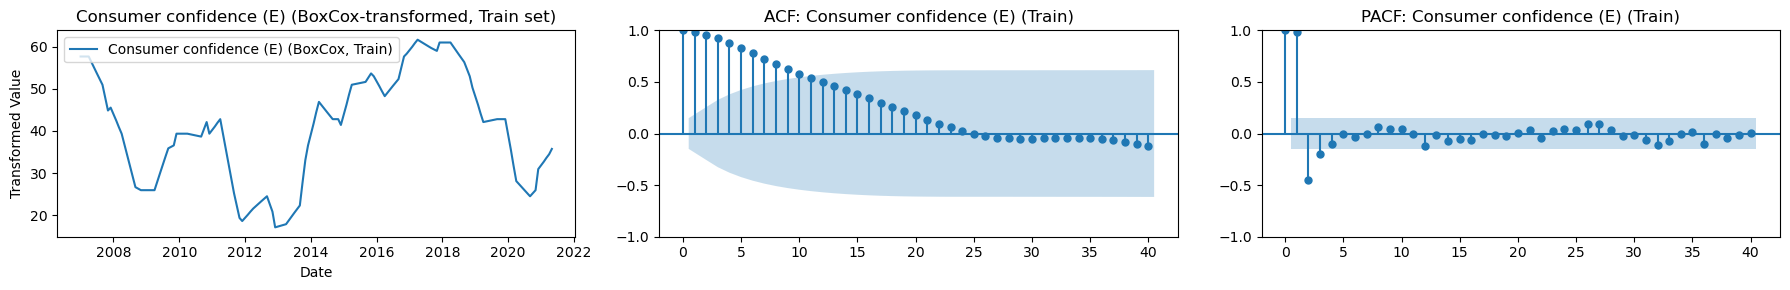

C:\Users\dylan\AppData\Local\Temp\ipykernel_27852\2068862521.py:29: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(train_bc, regression='c', nlags="auto")


==== Consumer confidence (E) ====
ADF Statistic: -2.3510691792521663
ADF p-value: 0.1560254463294088
ADF Critical Value (1%): -3.4692
ADF Critical Value (5%): -2.8786
ADF Critical Value (10%): -2.5759
ADF: The series is likely non-stationary (fail to reject H0).
KPSS Statistic: 0.3260610689932099
KPSS p-value: 0.1
KPSS Critical Value (10%): 0.3470
KPSS Critical Value (5%): 0.4630
KPSS Critical Value (2.5%): 0.5740
KPSS Critical Value (1%): 0.7390
KPSS: The series is likely stationary (fail to reject H0).



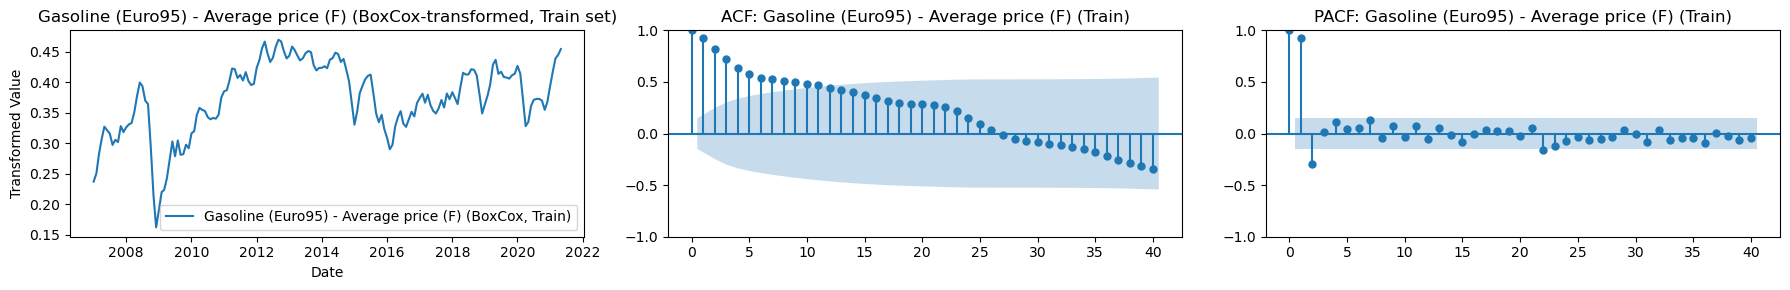

==== Gasoline (Euro95) - Average price (F) ====
ADF Statistic: -3.429561331934728
ADF p-value: 0.009991471463935241
ADF Critical Value (1%): -3.4692
ADF Critical Value (5%): -2.8786
ADF Critical Value (10%): -2.5759
ADF: The series is likely stationary (reject H0).
KPSS Statistic: 0.5550652860343227
KPSS p-value: 0.02926457521749488
KPSS Critical Value (10%): 0.3470
KPSS Critical Value (5%): 0.4630
KPSS Critical Value (2.5%): 0.5740
KPSS Critical Value (1%): 0.7390
KPSS: The series is likely non-stationary (reject H0).



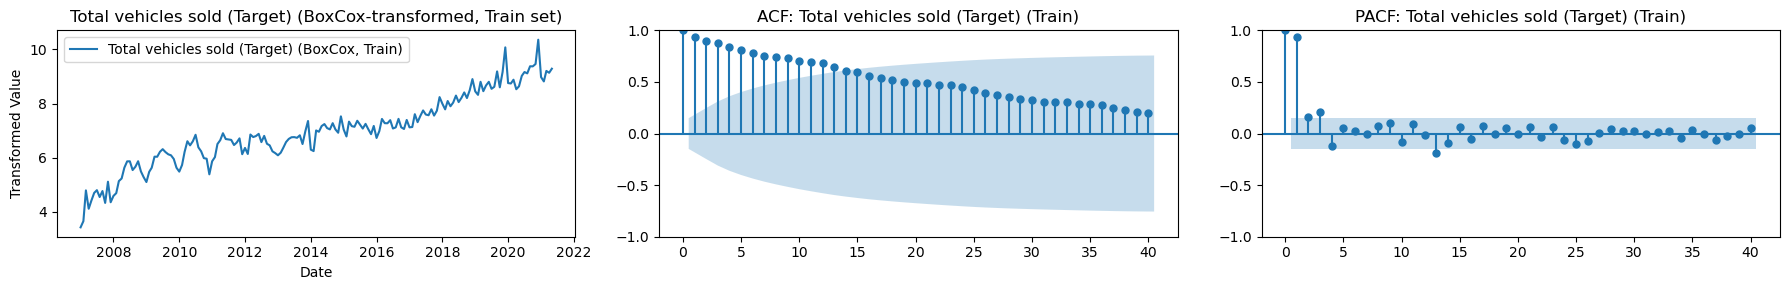

==== Total vehicles sold (Target) ====
ADF Statistic: -0.2734144213478023
ADF p-value: 0.929186159504631
ADF Critical Value (1%): -3.4722
ADF Critical Value (5%): -2.8799
ADF Critical Value (10%): -2.5766
ADF: The series is likely non-stationary (fail to reject H0).
KPSS Statistic: 1.8854846327709538
KPSS p-value: 0.01
KPSS Critical Value (10%): 0.3470
KPSS Critical Value (5%): 0.4630
KPSS Critical Value (2.5%): 0.5740
KPSS Critical Value (1%): 0.7390
KPSS: The series is likely non-stationary (reject H0).



C:\Users\dylan\AppData\Local\Temp\ipykernel_27852\2068862521.py:29: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(train_bc, regression='c', nlags="auto")


In [ ]:
warnings.filterwarnings("ignore", category=ValueWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)


results = {}

# Loop over features and target
for col in features + [target]:
    # Get BoxCox-transformed train split and matching dates
    train_bc = y_bc_train if col == target else X_bc_train[col]
    train_dates = df["Time Period (T)"][:len(train_bc)]  # still using original dates

    # Plot time series and ACF/PACF
    fig, axes = plt.subplots(1, 3, figsize=(18, 3))
    axes[0].plot(train_dates, train_bc, label=f"{col} (BoxCox, Train)")
    axes[0].set_title(f"{col} (BoxCox-transformed, Train set)")
    axes[0].set_xlabel("Date")
    axes[0].set_ylabel("Transformed Value")
    axes[0].legend()
    plot_acf(train_bc, ax=axes[1], lags=40)
    axes[1].set_title(f"ACF: {col} (Train)")
    plot_pacf(train_bc, ax=axes[2], lags=40, method='ywm')
    axes[2].set_title(f"PACF: {col} (Train)")
    plt.tight_layout()
    plt.show()

    # ADF and KPSS tests
    adf_result = adfuller(train_bc)
    kpss_result = kpss(train_bc, regression='c', nlags="auto")

    results[col] = {
        "ADF Statistic": adf_result[0],
        "ADF p-value": adf_result[1],
        "ADF Critical Values": adf_result[4],
        "KPSS Statistic": kpss_result[0],
        "KPSS p-value": kpss_result[1],
        "KPSS Critical Values": kpss_result[3]
    }

    print(f"\033[1m==== {col} ====\033[0m")
    print("\033[1mADF Statistic:\033[0m", adf_result[0])
    print("\033[1mADF p-value:\033[0m", adf_result[1])
    for key, value in adf_result[4].items():
        print(f"\033[1mADF Critical Value ({key}):\033[0m {value:.4f}")
    if adf_result[1] < 0.05:
        print("\033[1mADF: The series is likely stationary (reject H0).\033[0m")
    else:
        print("\033[1mADF: The series is likely non-stationary (fail to reject H0).\033[0m")

    print("\033[1mKPSS Statistic:\033[0m", kpss_result[0])
    print("\033[1mKPSS p-value:\033[0m", kpss_result[1])
    for key, value in kpss_result[3].items():
        print(f"\033[1mKPSS Critical Value ({key}):\033[0m {value:.4f}")
    if kpss_result[1] < 0.05:
        print("\033[1mKPSS: The series is likely non-stationary (reject H0).\033[0m")
    else:
        print("\033[1mKPSS: The series is likely stationary (fail to reject H0).\033[0m")
    print()

## 4d Apply First/second order differencing

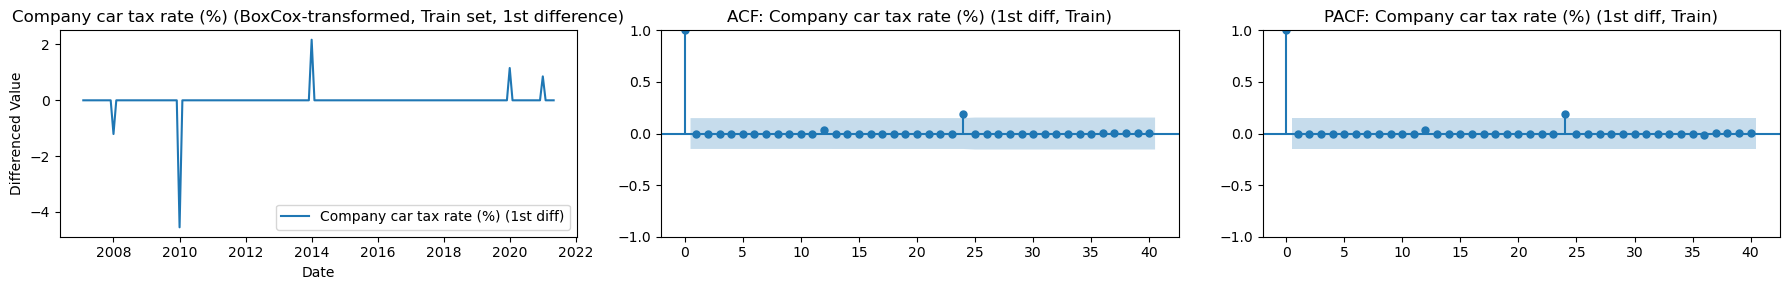

==== Company car tax rate (%) (1st diff) ====
ADF Statistic: -13.006500690837173
ADF p-value: 2.6210848840177814e-24
ADF Critical Value (1%): -3.4692
ADF Critical Value (5%): -2.8786
ADF Critical Value (10%): -2.5759
ADF: The series is likely stationary (reject H0).
KPSS Statistic: 0.3598835944545371
KPSS p-value: 0.09444672652821676
KPSS Critical Value (10%): 0.3470
KPSS Critical Value (5%): 0.4630
KPSS Critical Value (2.5%): 0.5740
KPSS Critical Value (1%): 0.7390
KPSS: The series is likely stationary (fail to reject H0).



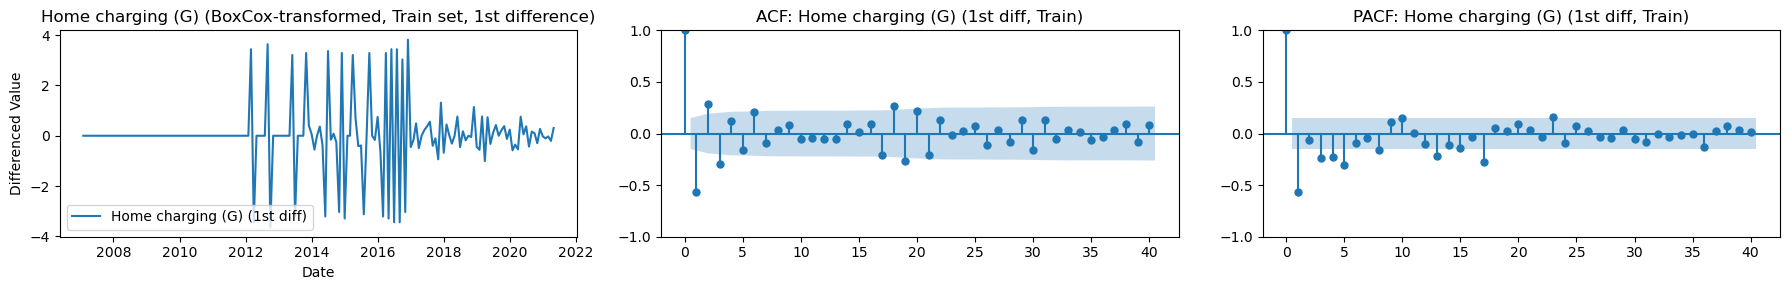

C:\Users\dylan\AppData\Local\Temp\ipykernel_27852\2290060814.py:34: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result_diff = kpss(train_bc_diff, regression='c', nlags="auto")


==== Home charging (G) (1st diff) ====
ADF Statistic: -5.432745462872665
ADF p-value: 2.8901002355923257e-06
ADF Critical Value (1%): -3.4727
ADF Critical Value (5%): -2.8801
ADF Critical Value (10%): -2.5767
ADF: The series is likely stationary (reject H0).
KPSS Statistic: 0.12832711943021022
KPSS p-value: 0.1
KPSS Critical Value (10%): 0.3470
KPSS Critical Value (5%): 0.4630
KPSS Critical Value (2.5%): 0.5740
KPSS Critical Value (1%): 0.7390
KPSS: The series is likely stationary (fail to reject H0).



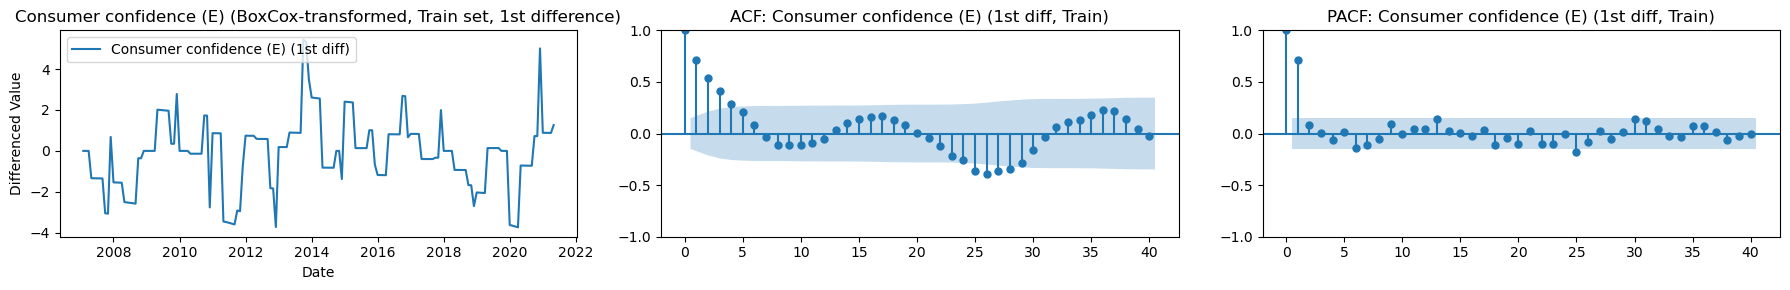

C:\Users\dylan\AppData\Local\Temp\ipykernel_27852\2290060814.py:34: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result_diff = kpss(train_bc_diff, regression='c', nlags="auto")


==== Consumer confidence (E) (1st diff) ====
ADF Statistic: -5.320846040060335
ADF p-value: 4.9566881976562114e-06
ADF Critical Value (1%): -3.4692
ADF Critical Value (5%): -2.8786
ADF Critical Value (10%): -2.5759
ADF: The series is likely stationary (reject H0).
KPSS Statistic: 0.13959754802959143
KPSS p-value: 0.1
KPSS Critical Value (10%): 0.3470
KPSS Critical Value (5%): 0.4630
KPSS Critical Value (2.5%): 0.5740
KPSS Critical Value (1%): 0.7390
KPSS: The series is likely stationary (fail to reject H0).



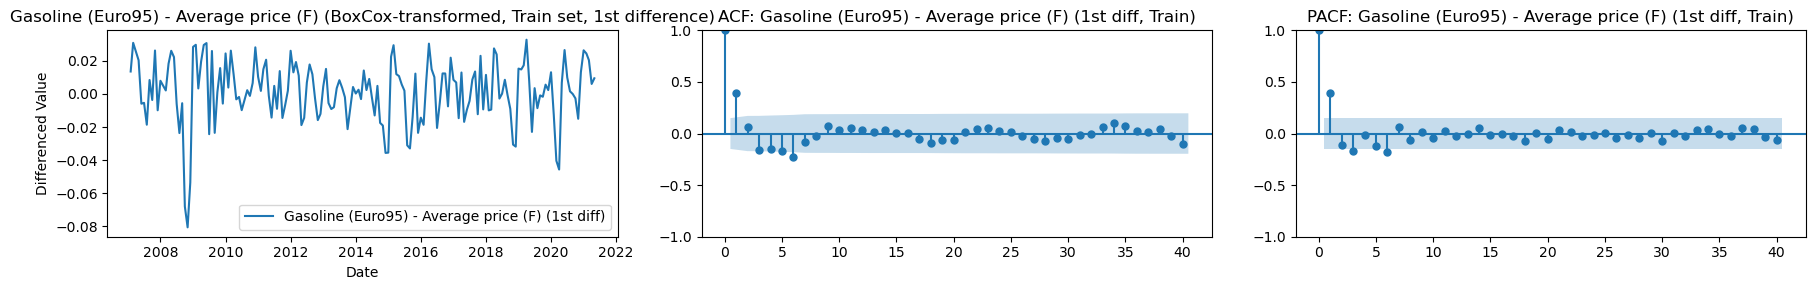

C:\Users\dylan\AppData\Local\Temp\ipykernel_27852\2290060814.py:34: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result_diff = kpss(train_bc_diff, regression='c', nlags="auto")


==== Gasoline (Euro95) - Average price (F) (1st diff) ====
ADF Statistic: -7.24295525059855
ADF p-value: 1.863648224339432e-10
ADF Critical Value (1%): -3.4704
ADF Critical Value (5%): -2.8791
ADF Critical Value (10%): -2.5761
ADF: The series is likely stationary (reject H0).
KPSS Statistic: 0.08683442785440895
KPSS p-value: 0.1
KPSS Critical Value (10%): 0.3470
KPSS Critical Value (5%): 0.4630
KPSS Critical Value (2.5%): 0.5740
KPSS Critical Value (1%): 0.7390
KPSS: The series is likely stationary (fail to reject H0).



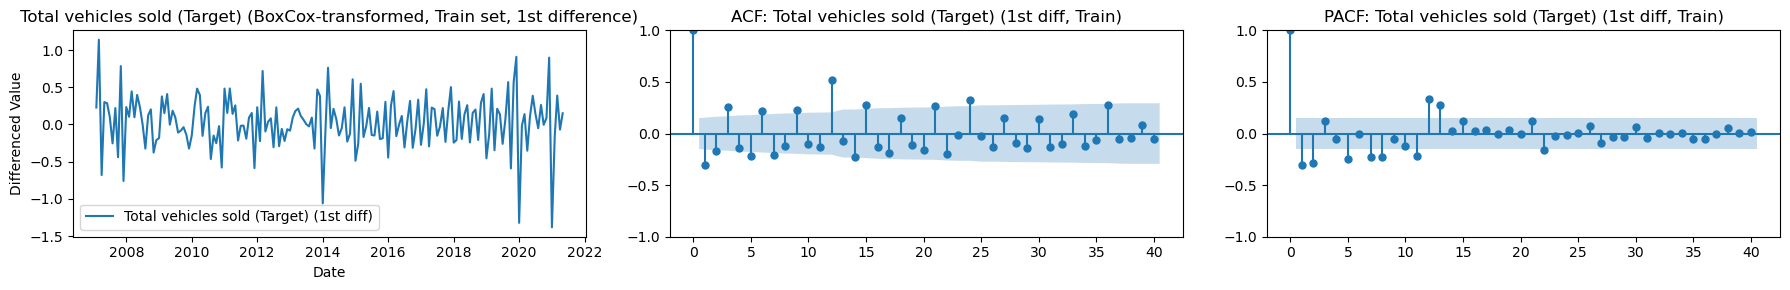

==== Total vehicles sold (Target) (1st diff) ====
ADF Statistic: -3.482309674926358
ADF p-value: 0.008453213503776685
ADF Critical Value (1%): -3.4722
ADF Critical Value (5%): -2.8799
ADF Critical Value (10%): -2.5766
ADF: The series is likely stationary (reject H0).
KPSS Statistic: 0.07044683885481265
KPSS p-value: 0.1
KPSS Critical Value (10%): 0.3470
KPSS Critical Value (5%): 0.4630
KPSS Critical Value (2.5%): 0.5740
KPSS Critical Value (1%): 0.7390
KPSS: The series is likely stationary (fail to reject H0).



C:\Users\dylan\AppData\Local\Temp\ipykernel_27852\2290060814.py:34: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result_diff = kpss(train_bc_diff, regression='c', nlags="auto")


In [ ]:
warnings.filterwarnings("ignore", category=ValueWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Apply first difference to BoxCox-transformed train split for all features and target
diff_results = {}

for col in features + [target]:
    # Get BoxCox-transformed train data
    train_bc = y_bc_train if col == target else X_bc_train[col]

    # Apply first difference
    train_bc_diff = np.diff(train_bc, n=1)
    diff_results[col] = train_bc_diff

    # Matching time index (after differencing: one shorter)
    time_index = df["Time Period (T)"][:len(train_bc)][1:]

    # Plot differenced series + ACF/PACF
    fig, axes = plt.subplots(1, 3, figsize=(18, 3))
    axes[0].plot(time_index, train_bc_diff, label=f"{col} (1st diff)")
    axes[0].set_title(f"{col} (BoxCox-transformed, Train set, 1st difference)")
    axes[0].set_xlabel("Date")
    axes[0].set_ylabel("Differenced Value")
    axes[0].legend()
    plot_acf(train_bc_diff, ax=axes[1], lags=40)
    axes[1].set_title(f"ACF: {col} (1st diff, Train)")
    plot_pacf(train_bc_diff, ax=axes[2], lags=40, method='ywm')
    axes[2].set_title(f"PACF: {col} (1st diff, Train)")
    plt.tight_layout()
    plt.show()

    # ADF and KPSS tests
    adf_result_diff = adfuller(train_bc_diff)
    kpss_result_diff = kpss(train_bc_diff, regression='c', nlags="auto")

    print(f"\033[1m==== {col} (1st diff) ====\033[0m")
    print("ADF Statistic:", adf_result_diff[0])
    print("ADF p-value:", adf_result_diff[1])
    for key, value in adf_result_diff[4].items():
        print(f"ADF Critical Value ({key}): {value:.4f}")
    if adf_result_diff[1] < 0.05:
        print("\033[1mADF: The series is likely stationary (reject H0).\033[0m")
    else:
        print("\033[1mADF: The series is likely non-stationary (fail to reject H0).\033[0m")

    print("KPSS Statistic:", kpss_result_diff[0])
    print("KPSS p-value:", kpss_result_diff[1])
    for key, value in kpss_result_diff[3].items():
        print(f"KPSS Critical Value ({key}): {value:.4f}")
    if kpss_result_diff[1] < 0.05:
        print("\033[1mKPSS: The series is likely non-stationary (reject H0).\033[0m")
    else:
        print("\033[1mKPSS: The series is likely stationary (fail to reject H0).\033[0m")
    print()

# 5 Establish Simple benchmark
for benchmark i wil fit the following naive models on vehicles sold 
- Naïve: last observed value.
- Seasonal naïve: last value from the same season.
- Drift: line from first to last point.


Naïve 3-step RMSE: 5360.99
Naïve 3-step MAPE: 19.05%
Seasonal Naïve 3-step RMSE: 4456.62
Seasonal Naïve 3-step MAPE: 21.24%
Drift 3-step RMSE: 6065.02
Drift 3-step MAPE: 24.81%


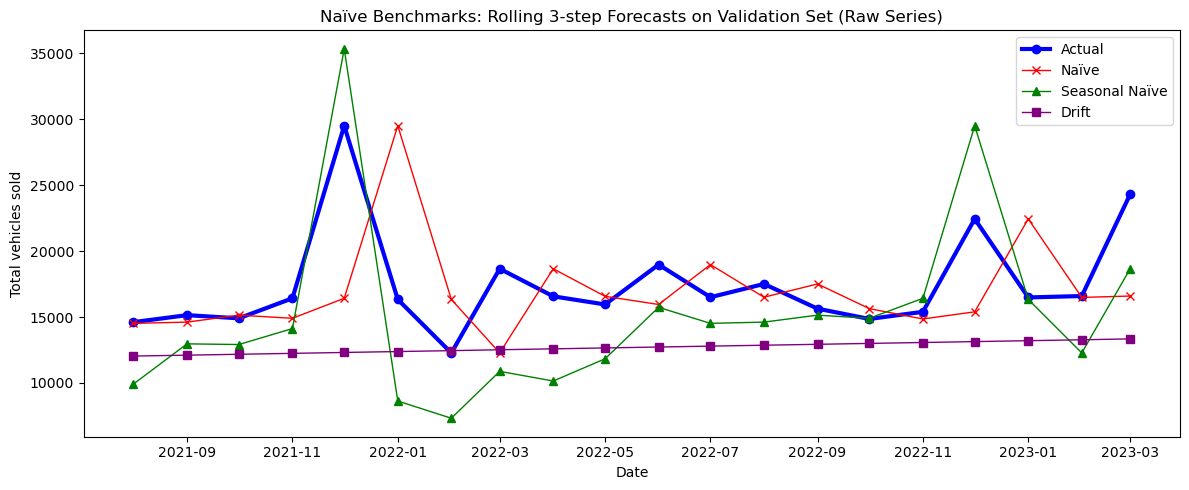

In [ ]:

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# --- Use raw (untouched) series for benchmarks ---
# y_train, y_val already defined as raw splits

horizon = 3

# Combine train + val for rolling forecasting
y_all = np.concatenate([y_train.values, y_val.values])
y_val_full = y_val.values
y_train_full = y_train.values

# === 1. Naïve Forecast ===
naive_preds = []
for t in range(len(y_val_full) - horizon + 1):
    last_obs = y_all[train_end + t + horizon - 2]  # last value before forecast
    naive_preds.append(last_obs)
naive_preds = np.array(naive_preds)
naive_actuals = y_val_full[horizon-1:]

naive_rmse = np.sqrt(mean_squared_error(naive_actuals, naive_preds))
naive_mape = mean_absolute_percentage_error(naive_actuals, naive_preds)

print(f"Naïve 3-step RMSE: {naive_rmse:.2f}")
print(f"Naïve 3-step MAPE: {naive_mape:.2%}")

# === 2. Seasonal Naïve Forecast (12 months ago) ===
season_length = 12
seasonal_naive_preds = []
for t in range(len(y_val_full) - horizon + 1):
    idx = train_end + t + horizon - 1
    if idx - season_length >= 0:
        pred = y_all[idx - season_length]
    else:
        pred = y_all[train_end + t + horizon - 2]  # fallback to last obs if not enough history
    seasonal_naive_preds.append(pred)
seasonal_naive_preds = np.array(seasonal_naive_preds)

seasonal_naive_rmse = np.sqrt(mean_squared_error(naive_actuals, seasonal_naive_preds))
seasonal_naive_mape = mean_absolute_percentage_error(naive_actuals, seasonal_naive_preds)

print(f"Seasonal Naïve 3-step RMSE: {seasonal_naive_rmse:.2f}")
print(f"Seasonal Naïve 3-step MAPE: {seasonal_naive_mape:.2%}")

# === 3. Drift Forecast ===
drift_preds = []
n_train = len(y_train_full)
for t in range(len(y_val_full) - horizon + 1):
    steps = n_train + t + horizon - 1
    drift = y_train_full[-1] + ((steps - (n_train - 1)) * (y_train_full[-1] - y_train_full[0]) / (n_train - 1))
    drift_preds.append(drift)
drift_preds = np.array(drift_preds)
drift_rmse = np.sqrt(mean_squared_error(naive_actuals, drift_preds))
drift_mape = mean_absolute_percentage_error(naive_actuals, drift_preds)

print(f"Drift 3-step RMSE: {drift_rmse:.2f}")
print(f"Drift 3-step MAPE: {drift_mape:.2%}")

# === Plot all ===
x_dates = df["Time Period (T)"][train_end + horizon - 1 : val_end]
plt.figure(figsize=(12, 5))
plt.plot(x_dates, naive_actuals, label='Actual', marker='o', color='blue', linewidth=3)
plt.plot(x_dates, naive_preds, label='Naïve', marker='x', color='red', linewidth=1)
plt.plot(x_dates, seasonal_naive_preds, label='Seasonal Naïve', marker='^', color='green', linewidth=1)
plt.plot(x_dates, drift_preds, label='Drift', marker='s', color='purple', linewidth=1)
plt.title('Naïve Benchmarks: Rolling 3-step Forecasts on Validation Set (Raw Series)')
plt.xlabel('Date')
plt.ylabel('Total vehicles sold')
plt.legend()
plt.tight_layout()
plt.show()

# 6. Baseline ARIMA (Univariate)

## 6a Auto ARIMA using The Hyndman & Khandakar algorithm

First up auto arima will be used to fit the model for the target value.
Using auto_arima gives  a fast, starting point. It automatically scans a wide range of (p, d, q) and seasonal orders using information criteria (AICc, BIC), so i don’t have to write dozens of loops yourself. This initial model often captures the dominant autocorrelation and differencing structure.

for this seasonal i choose for 3,6 and 12 as seasonal periods, because the data is monthly and has a yearly seasonality.

d will stay on zere since its already defined.

> Since you already applied BoxCox and first differencing to your target, you should:

> Use diff_results[target] as your input to auto_arima.
Set d=0, D=0 in auto_arima (no further differencing).
Use the same target variable name as before (it refers to your column name, e.g., 'Total vehicles sold (Target)'

> Deze ff veranderen zodat BIC EN AIC naast elkaar staan

In [ ]:
# import warnings
# warnings.filterwarnings("ignore", category=ValueWarning)
# warnings.filterwarnings("ignore", category=ConvergenceWarning)
# warnings.filterwarnings("ignore", category=FutureWarning)

# target_diff = diff_results[target]
# seasonalities = [3, 6, 12]

# best_aic = float('inf')
# best_bic = float('inf')
# best_model_aic = None
# best_model_bic = None
# best_m_aic = None
# best_m_bic = None

# for m in seasonalities:
#     print(f"\n=== Try SARIMA with seasonality m={m} ===")
#     for ic in ['aic', 'bic']:
#         try:
#             model = pm.auto_arima(
#                 y=target_diff,
#                 d=0,
#                 seasonal=True,
#                 m=m,
#                 stepwise=True,
#                 trace=True,
#                 error_action='ignore',
#                 suppress_warnings=True,
#                 max_p=5, max_q=5,
#                 max_d=0,
#                 max_P=2, max_Q=2,
#                 information_criterion=ic
#             )
#             print(f"m={m}, {ic.upper()}: SARIMA order={model.order}, seasonal_order={model.seasonal_order}, {ic.upper()}={getattr(model, ic)():.2f}")
#             if ic == 'aic' and model.aic() < best_aic:
#                 best_aic = model.aic()
#                 best_model_aic = model
#                 best_m_aic = m
#             if ic == 'bic' and model.bic() < best_bic:
#                 best_bic = model.bic()
#                 best_model_bic = model
#                 best_m_bic = m
#         except Exception as e:
#             print(f"m={m}, {ic.upper()}: Error: {e}")

# if best_model_aic is not None:
#     print(f"\nBest SARIMA by AIC: m={best_m_aic}, order={best_model_aic.order}, seasonal_order={best_model_aic.seasonal_order}, AIC={best_aic:.2f}")
# else:
#     print("No suitable SARIMA model found by AIC.")

# if best_model_bic is not None:
#     print(f"Best SARIMA by BIC: m={best_m_bic}, order={best_model_bic.order}, seasonal_order={best_model_bic.seasonal_order}, BIC={best_bic:.2f}")
# else:
#     print("No suitable SARIMA model found by BIC.")


=== Try SARIMA with seasonality m=3 ===
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[3] intercept   : AIC=90.108, Time=0.92 sec
 ARIMA(0,0,0)(0,0,0)[3] intercept   : AIC=136.565, Time=0.08 sec
 ARIMA(1,0,0)(1,0,0)[3] intercept   : AIC=114.595, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[3] intercept   : AIC=109.219, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[3]             : AIC=136.139, Time=0.04 sec
 ARIMA(2,0,2)(0,0,1)[3] intercept   : AIC=73.325, Time=0.36 sec
 ARIMA(2,0,2)(0,0,0)[3] intercept   : AIC=90.806, Time=0.27 sec
 ARIMA(2,0,2)(0,0,2)[3] intercept   : AIC=72.507, Time=0.45 sec
 ARIMA(2,0,2)(1,0,2)[3] intercept   : AIC=72.943, Time=0.62 sec
 ARIMA(1,0,2)(0,0,2)[3] intercept   : AIC=99.230, Time=0.36 sec
 ARIMA(2,0,1)(0,0,2)[3] intercept   : AIC=97.416, Time=0.29 sec
 ARIMA(1,0,1)(0,0,2)[3] intercept   : AIC=97.252, Time=0.26 sec
 ARIMA(2,0,2)(0,0,2)[3]             : AIC=84.224, Time=0.29 sec

Best model:  ARIMA(2,0,2)(0,0,2)[3] intercept
Total fit time: 4.242 seconds
m=3

> looking at the auto_arima results, the best model is SARIMAX(0, 0, 1)(1, 0, 1, 12) with an AIC of 150.5 and BIC of 158.2 lets plot evaluate it on the validation set next to determen the predictablity.


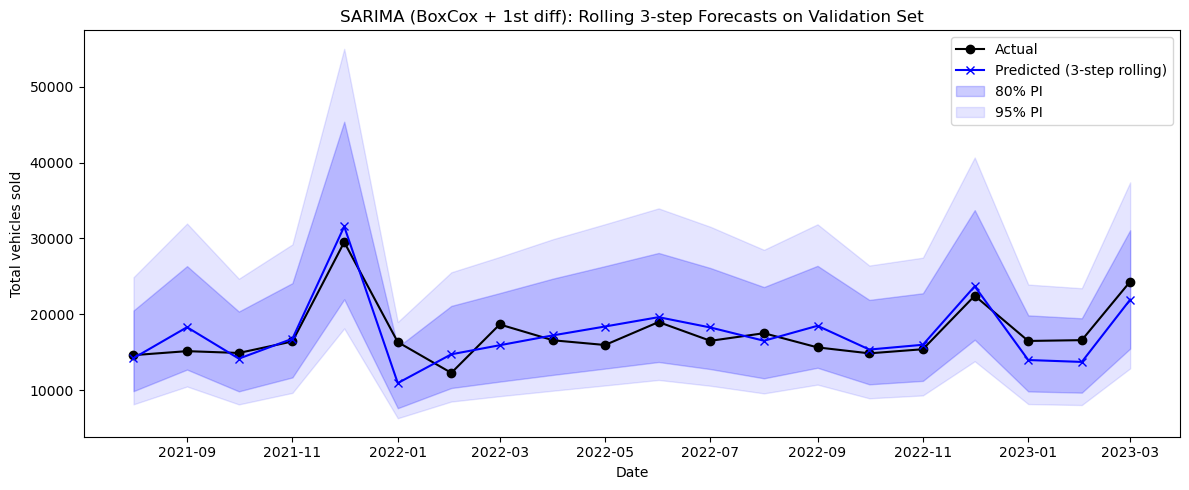

Validation RMSE (3-step rolling): 2226.31
Validation MAPE (3-step rolling): 10.89%
AIC (last rolling SARIMAX): -10.71
BIC (last rolling SARIMAX): 1.99


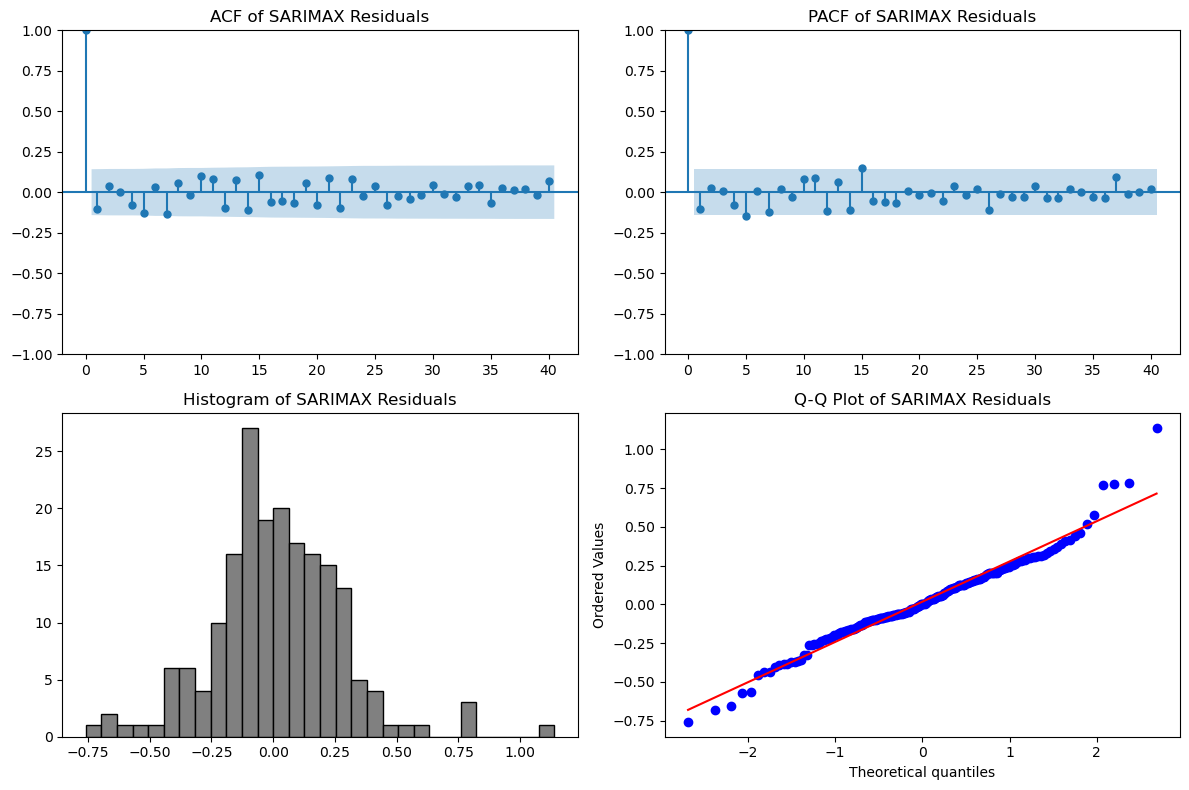

Ljung-Box test p-values (no autocorrelation if > 0.05):
      lb_stat  lb_pvalue
10  13.314807   0.206599
20  27.114216   0.132081
30  35.347218   0.230226


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np

# Parameters
horizon = 3

# Box–Cox train/val on level scale (already defined)
train_bc = y_bc_train.values
val_bc   = y_bc_val.values

# Actuals on the original scale, aligned to t+horizon−1
val_actuals = df[target].iloc[train_end_bc + horizon - 1 : val_end_bc].values

# Rolling, manual‐diff code with prediction intervals
preds_diff = []
conf_int_80 = []
conf_int_95 = []
for t in range(len(val_bc) - horizon + 1):
    history    = np.concatenate([train_bc, val_bc[:t]])
    history_diff = np.diff(history, 1)
    model = SARIMAX(
        history_diff,
        order=(0,0,1),
        seasonal_order=(1,0,1,12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fitted = model.fit(disp=False)
    fc = fitted.get_forecast(steps=horizon)
    fc_diff = fc.predicted_mean
    ci_80 = fc.conf_int(alpha=0.20)[-1]  # 80% PI for last step (numpy indexing)
    ci_95 = fc.conf_int(alpha=0.05)[-1]  # 95% PI for last step (numpy indexing)
    preds_diff.append(fc_diff[-1])
    conf_int_80.append(ci_80)
    conf_int_95.append(ci_95)

# Undifference: reconstruct BoxCox‐transformed level series
last_values   = np.concatenate([train_bc, val_bc])   # full level series
train_len_bc  = len(train_bc)                        # same as train_end_bc

undiff_preds_bc = []
undiff_ci80_lower = []
undiff_ci80_upper = []
undiff_ci95_lower = []
undiff_ci95_upper = []
for i, pred_diff in enumerate(preds_diff):
    idx      = train_len_bc + i + horizon - 2
    last_bc  = last_values[idx]
    undiff_pred = last_bc + pred_diff
    undiff_preds_bc.append(undiff_pred)
    # Intervals
    undiff_ci80_lower.append(last_bc + conf_int_80[i][0])
    undiff_ci80_upper.append(last_bc + conf_int_80[i][1])
    undiff_ci95_lower.append(last_bc + conf_int_95[i][0])
    undiff_ci95_upper.append(last_bc + conf_int_95[i][1])

undiff_preds_bc = np.array(undiff_preds_bc)
undiff_ci80_lower = np.array(undiff_ci80_lower)
undiff_ci80_upper = np.array(undiff_ci80_upper)
undiff_ci95_lower = np.array(undiff_ci95_lower)
undiff_ci95_upper = np.array(undiff_ci95_upper)

# Invert Box–Cox
lam, shift = boxcox_lambdas_all[target]
def inv_boxcox(y, lam):
    return np.exp(y) if lam == 0 else np.power(lam * y + 1, 1/lam)

val_forecast_orig_rolling = inv_boxcox(undiff_preds_bc, lam) - shift
ci_80_lower = inv_boxcox(undiff_ci80_lower, lam) - shift
ci_80_upper = inv_boxcox(undiff_ci80_upper, lam) - shift
ci_95_lower = inv_boxcox(undiff_ci95_lower, lam) - shift
ci_95_upper = inv_boxcox(undiff_ci95_upper, lam) - shift

# Plotting
import matplotlib.pyplot as plt
x_dates = df["Time Period (T)"][train_end+horizon-1:val_end]
plt.figure(figsize=(12, 5))
plt.plot(x_dates, val_actuals, label='Actual', marker='o', color='black')
plt.plot(x_dates, val_forecast_orig_rolling, label='Predicted (3-step rolling)', marker='x', color='blue')
plt.fill_between(x_dates, ci_80_lower, ci_80_upper, color='blue', alpha=0.2, label='80% PI')
plt.fill_between(x_dates, ci_95_lower, ci_95_upper, color='blue', alpha=0.1, label='95% PI')
plt.title('SARIMA (BoxCox + 1st diff): Rolling 3-step Forecasts on Validation Set')
plt.xlabel('Date')
plt.ylabel('Total vehicles sold')
plt.legend()
plt.tight_layout()
plt.show()

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
rmse_rolling = np.sqrt(mean_squared_error(val_actuals, val_forecast_orig_rolling))
mape_rolling = mean_absolute_percentage_error(val_actuals, val_forecast_orig_rolling)
print(f"Validation RMSE (3-step rolling): {rmse_rolling:.2f}")
print(f"Validation MAPE (3-step rolling): {mape_rolling:.2%}")

# Print AIC and BIC of the last fitted SARIMAX model
print(f"AIC (last rolling SARIMAX): {fitted.aic:.2f}")
print(f"BIC (last rolling SARIMAX): {fitted.bic:.2f}")

# --- Residual diagnostics ---


# Use residuals from the last fitted model in the rolling loop
residuals = fitted.resid

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# ACF plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(residuals, ax=axes[0, 0], lags=40)
axes[0, 0].set_title("ACF of SARIMAX Residuals")

# PACF plot
plot_pacf(residuals, ax=axes[0, 1], lags=40, method='ywm')
axes[0, 1].set_title("PACF of SARIMAX Residuals")

# Histogram
axes[1, 0].hist(residuals, bins=30, color='gray', edgecolor='black')
axes[1, 0].set_title("Histogram of SARIMAX Residuals")

# Q-Q plot
stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title("Q-Q Plot of SARIMAX Residuals")

plt.tight_layout()
plt.show()

# Ljung-Box test for autocorrelation (white noise)
lb_test = acorr_ljungbox(residuals, lags=[10, 20, 30], return_df=True)
print("Ljung-Box test p-values (no autocorrelation if > 0.05):")
print(lb_test[['lb_stat', 'lb_pvalue']])

####  Residual Diagnostics Summary

The SARIMA(0,0,1)(1,0,1)[12] model shows no signs of overfitting:

- **ACF/PACF of residuals** show no significant autocorrelation.
- **Histogram** suggests approximate normality.
- **Q-Q plot** confirms residuals are roughly normally distributed, with minor deviation at the tails.
- **Ljung-Box test** p-values (p > 0.05) indicate that the residuals are white noise.

Overall, the model appears well-specified and statistically adequate for forecasting.


#### Testsettest

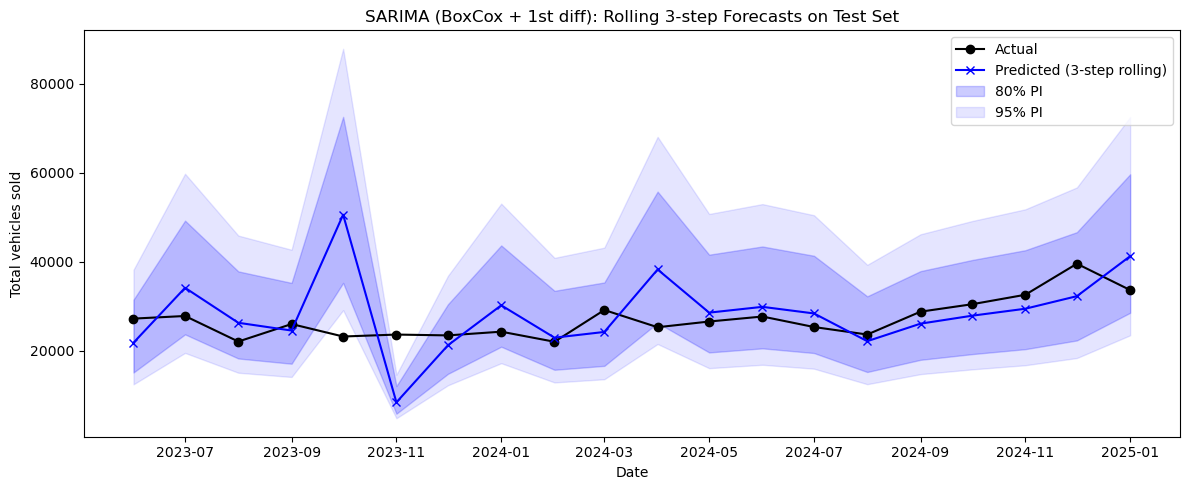

Test RMSE (3-step rolling): 8541.75
Test MAPE (3-step rolling): 22.88%
AIC (last rolling SARIMAX): 12.00
BIC (last rolling SARIMAX): 24.71


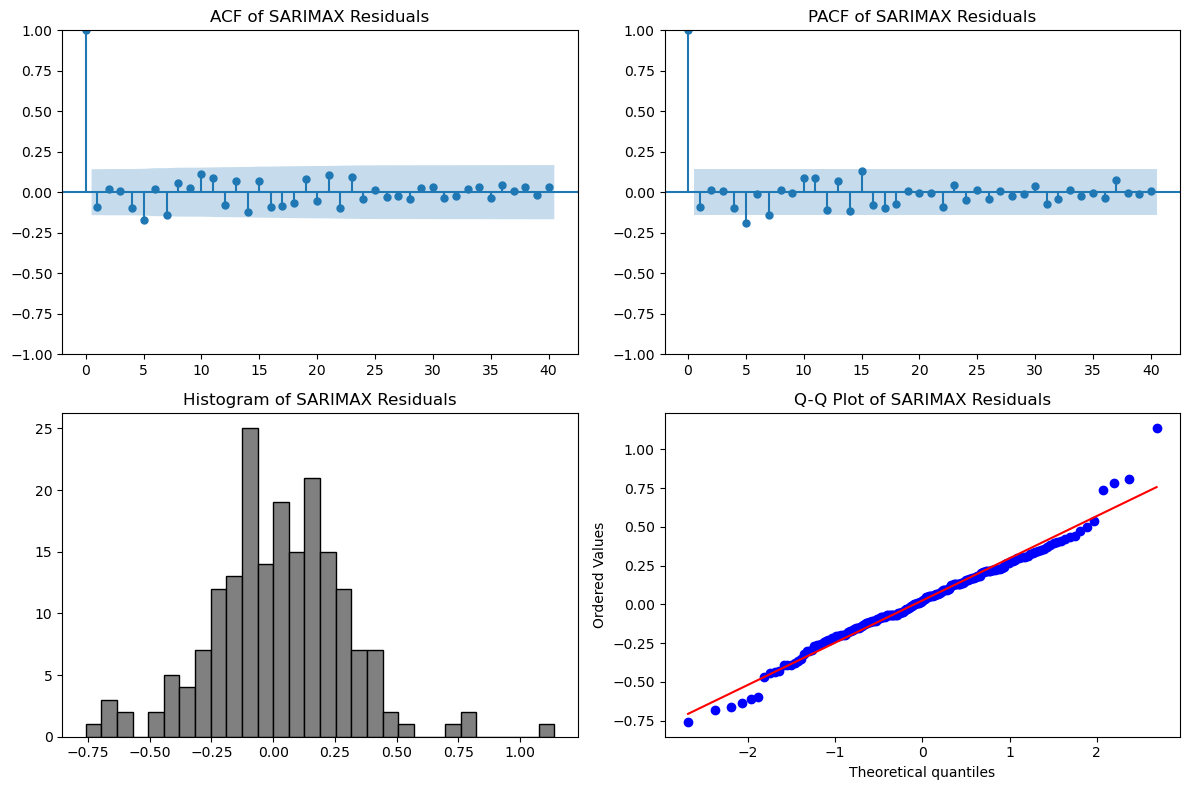

Ljung-Box test p-values (no autocorrelation if > 0.05):
      lb_stat  lb_pvalue
10  16.698757   0.081301
20  31.399484   0.050133
30  39.251370   0.120196


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np

# Parameters
horizon = 3

# Use Box–Cox train/test on level scale (already defined)
train_bc = y_bc_train.values
test_bc  = y_bc_test.values

# Actuals on the original scale, aligned to t+horizon−1
test_actuals = df[target].iloc[val_end_bc + horizon - 1 :].values

# Rolling, manual‐diff code with prediction intervals
preds_diff = []
conf_int_80 = []
conf_int_95 = []
for t in range(len(test_bc) - horizon + 1):
    history    = np.concatenate([train_bc, test_bc[:t]])
    history_diff = np.diff(history, 1)
    model = SARIMAX(
        history_diff,
        order=(0,0,1),
        seasonal_order=(1,0,1,12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fitted = model.fit(disp=False)
    fc = fitted.get_forecast(steps=horizon)
    fc_diff = fc.predicted_mean
    ci_80 = fc.conf_int(alpha=0.20)[-1]  # 80% PI for last step (numpy indexing)
    ci_95 = fc.conf_int(alpha=0.05)[-1]  # 95% PI for last step (numpy indexing)
    preds_diff.append(fc_diff[-1])
    conf_int_80.append(ci_80)
    conf_int_95.append(ci_95)

# Undifference: reconstruct BoxCox‐transformed level series
last_values   = np.concatenate([train_bc, test_bc])   # full level series
train_len_bc  = len(train_bc)                        # same as train_end_bc

undiff_preds_bc = []
undiff_ci80_lower = []
undiff_ci80_upper = []
undiff_ci95_lower = []
undiff_ci95_upper = []
for i, pred_diff in enumerate(preds_diff):
    idx      = train_len_bc + i + horizon - 2
    last_bc  = last_values[idx]
    undiff_pred = last_bc + pred_diff
    undiff_preds_bc.append(undiff_pred)
    # Intervals
    undiff_ci80_lower.append(last_bc + conf_int_80[i][0])
    undiff_ci80_upper.append(last_bc + conf_int_80[i][1])
    undiff_ci95_lower.append(last_bc + conf_int_95[i][0])
    undiff_ci95_upper.append(last_bc + conf_int_95[i][1])

undiff_preds_bc = np.array(undiff_preds_bc)
undiff_ci80_lower = np.array(undiff_ci80_lower)
undiff_ci80_upper = np.array(undiff_ci80_upper)
undiff_ci95_lower = np.array(undiff_ci95_lower)
undiff_ci95_upper = np.array(undiff_ci95_upper)

# Invert Box–Cox
lam, shift = boxcox_lambdas_all[target]
def inv_boxcox(y, lam):
    return np.exp(y) if lam == 0 else np.power(lam * y + 1, 1/lam)

test_forecast_orig_rolling = inv_boxcox(undiff_preds_bc, lam) - shift
ci_80_lower = inv_boxcox(undiff_ci80_lower, lam) - shift
ci_80_upper = inv_boxcox(undiff_ci80_upper, lam) - shift
ci_95_lower = inv_boxcox(undiff_ci95_lower, lam) - shift
ci_95_upper = inv_boxcox(undiff_ci95_upper, lam) - shift

# Plotting
import matplotlib.pyplot as plt
x_dates = df["Time Period (T)"][val_end+horizon-1:]
plt.figure(figsize=(12, 5))
plt.plot(x_dates, test_actuals, label='Actual', marker='o', color='black')
plt.plot(x_dates, test_forecast_orig_rolling, label='Predicted (3-step rolling)', marker='x', color='blue')
plt.fill_between(x_dates, ci_80_lower, ci_80_upper, color='blue', alpha=0.2, label='80% PI')
plt.fill_between(x_dates, ci_95_lower, ci_95_upper, color='blue', alpha=0.1, label='95% PI')
plt.title('SARIMA (BoxCox + 1st diff): Rolling 3-step Forecasts on Test Set')
plt.xlabel('Date')
plt.ylabel('Total vehicles sold')
plt.legend()
plt.tight_layout()
plt.show()

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
rmse_rolling = np.sqrt(mean_squared_error(test_actuals, test_forecast_orig_rolling))
mape_rolling = mean_absolute_percentage_error(test_actuals, test_forecast_orig_rolling)
print(f"Test RMSE (3-step rolling): {rmse_rolling:.2f}")
print(f"Test MAPE (3-step rolling): {mape_rolling:.2%}")

# Print AIC and BIC of the last fitted SARIMAX model
print(f"AIC (last rolling SARIMAX): {fitted.aic:.2f}")
print(f"BIC (last rolling SARIMAX): {fitted.bic:.2f}")

# --- Residual diagnostics ---

# Use residuals from the last fitted model in the rolling loop
residuals = fitted.resid

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# ACF plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(residuals, ax=axes[0, 0], lags=40)
axes[0, 0].set_title("ACF of SARIMAX Residuals")

# PACF plot
plot_pacf(residuals, ax=axes[0, 1], lags=40, method='ywm')
axes[0, 1].set_title("PACF of SARIMAX Residuals")

# Histogram
axes[1, 0].hist(residuals, bins=30, color='gray', edgecolor='black')
axes[1, 0].set_title("Histogram of SARIMAX Residuals")

# Q-Q plot
import scipy.stats as stats
stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title("Q-Q Plot of SARIMAX Residuals")

plt.tight_layout()
plt.show()

# Ljung-Box test for autocorrelation (white noise)
from statsmodels.stats.diagnostic import acorr_ljungbox
lb_test = acorr_ljungbox(residuals, lags=[10, 20, 30], return_df=True)
print("Ljung-Box test p-values (no autocorrelation if > 0.05):")
print(lb_test[['lb_stat', 'lb_pvalue']])

Chapter 2.5 (Training vs. Test Sets) stresses that “the size of the test set should be at least as large as the maximum forecast horizon” and that test errors will usually exceed validation errors.

Chapter 9–10 (ARIMA & Dynamic Regression) warn against excessive tuning on a single validation split—every time you peek at the numbers you risk choosing a model that simply “got lucky” on that split.

| Set         | RMSE   | MAPE   |   AIC |   BIC |
|-------------|--------|--------|-------|-------|
| Validation  | 2,226  | 10.9%  | -10.7 |  1.99 |
| Test        | 8,541  | 22.9%  | 12.0  | 24.7  |

#### Gridsearch 

In [ ]:

import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

orders = [
    (0, 0, 1),  # Current model
    (1, 0, 1),  # Add AR term
    (1, 0, 0),  # Drop MA
    (2, 0, 1),  # More AR complexity
    (0, 0, 2),  # More MA complexity
]

seasonals = [
    (1, 0, 1, 12),  # Current model
    (1, 0, 0, 12),  # Drop seasonal MA
    (0, 0, 1, 12),  # Drop seasonal AR
    (2, 0, 1, 12),  # Add seasonal AR complexity
    (1, 1, 1, 12),  # Add seasonal differencing
]

horizon = 3
train_bc = y_bc_train.values
val_bc   = y_bc_val.values
val_actuals = df[target].iloc[train_end_bc + horizon - 1 : val_end_bc].values
lam, shift = boxcox_lambdas_all[target]

def inv_boxcox(y, lam):
    return np.exp(y) if lam == 0 else np.power(lam * y + 1, 1/lam)

results = []

for order in orders:
    for seasonal in seasonals:
        preds_diff = []
        conf_int_80 = []
        conf_int_95 = []
        try:
            for t in range(len(val_bc) - horizon + 1):
                history = np.concatenate([train_bc, val_bc[:t]])
                history_diff = np.diff(history, 1)
                model = SARIMAX(
                    history_diff,
                    order=order,
                    seasonal_order=seasonal,
                    enforce_stationarity=False,
                    enforce_invertibility=False
                )
                fitted = model.fit(disp=False)
                fc = fitted.get_forecast(steps=horizon)
                fc_diff = fc.predicted_mean
                ci_80 = fc.conf_int(alpha=0.20)[-1]
                ci_95 = fc.conf_int(alpha=0.05)[-1]
                preds_diff.append(fc_diff[-1])
                conf_int_80.append(ci_80)
                conf_int_95.append(ci_95)
            # Undifference
            last_values = np.concatenate([train_bc, val_bc])
            train_len_bc = len(train_bc)
            undiff_preds_bc = []
            undiff_ci80_lower = []
            undiff_ci80_upper = []
            undiff_ci95_lower = []
            undiff_ci95_upper = []
            for i, pred_diff in enumerate(preds_diff):
                idx = train_len_bc + i + horizon - 2
                last_bc = last_values[idx]
                undiff_pred = last_bc + pred_diff
                undiff_preds_bc.append(undiff_pred)
                undiff_ci80_lower.append(last_bc + conf_int_80[i][0])
                undiff_ci80_upper.append(last_bc + conf_int_80[i][1])
                undiff_ci95_lower.append(last_bc + conf_int_95[i][0])
                undiff_ci95_upper.append(last_bc + conf_int_95[i][1])
            undiff_preds_bc = np.array(undiff_preds_bc)
            undiff_ci80_lower = np.array(undiff_ci80_lower)
            undiff_ci80_upper = np.array(undiff_ci80_upper)
            undiff_ci95_lower = np.array(undiff_ci95_lower)
            undiff_ci95_upper = np.array(undiff_ci95_upper)
            # Invert Box–Cox
            val_forecast_orig_rolling = inv_boxcox(undiff_preds_bc, lam) - shift
            ci_80_lower = inv_boxcox(undiff_ci80_lower, lam) - shift
            ci_80_upper = inv_boxcox(undiff_ci80_upper, lam) - shift
            ci_95_lower = inv_boxcox(undiff_ci95_lower, lam) - shift
            ci_95_upper = inv_boxcox(undiff_ci95_upper, lam) - shift
            # Metrics
            rmse_rolling = np.sqrt(mean_squared_error(val_actuals, val_forecast_orig_rolling))
            mape_rolling = mean_absolute_percentage_error(val_actuals, val_forecast_orig_rolling)
            # Save results
            results.append({
                "order": order,
                "seasonal": seasonal,
                "rmse": rmse_rolling,
                "mape": mape_rolling,
                "aic": fitted.aic,
                "bic": fitted.bic
            })
            print(f"Order: {order}, Seasonal: {seasonal} | RMSE: {rmse_rolling:.2f} | MAPE: {mape_rolling:.2%} | AIC: {fitted.aic:.2f} | BIC: {fitted.bic:.2f}")
        except Exception as e:
            print(f"Order: {order}, Seasonal: {seasonal} | Error: {e}")

# Show best models by RMSE and MAPE
results_sorted = sorted(results, key=lambda x: x["rmse"])
print("\nTop 5 models by RMSE:")
for r in results_sorted[:5]:
    print(f"Order: {r['order']}, Seasonal: {r['seasonal']} | RMSE: {r['rmse']:.2f} | MAPE: {r['mape']:.2%} | AIC: {r['aic']:.2f} | BIC: {r['bic']:.2f}")

results_sorted = sorted(results, key=lambda x: x["mape"])
print("\nTop 5 models by MAPE:")
for r in results_sorted[:5]:
    print(f"Order: {r['order']}, Seasonal: {r['seasonal']} | RMSE: {r['rmse']:.2f} | MAPE: {r['mape']:.2%} | AIC: {r['aic']:.2f} | BIC: {r['bic']:.2f}")

Order: (0, 0, 1), Seasonal: (1, 0, 1, 12) | RMSE: 2226.31 | MAPE: 10.89% | AIC: -10.71 | BIC: 1.99
Order: (0, 0, 1), Seasonal: (1, 0, 0, 12) | RMSE: 1976.28 | MAPE: 9.46% | AIC: -14.27 | BIC: -4.71
Order: (0, 0, 1), Seasonal: (0, 0, 1, 12) | RMSE: 3185.33 | MAPE: 13.69% | AIC: 25.05 | BIC: 34.58
Order: (0, 0, 1), Seasonal: (2, 0, 1, 12) | RMSE: 2696.95 | MAPE: 12.97% | AIC: -23.22 | BIC: -7.63
Order: (0, 0, 1), Seasonal: (1, 1, 1, 12) | RMSE: 4433.65 | MAPE: 19.00% | AIC: -8.47 | BIC: 3.96
Order: (1, 0, 1), Seasonal: (1, 0, 1, 12) | RMSE: 1958.89 | MAPE: 9.26% | AIC: -12.24 | BIC: 3.64
Order: (1, 0, 1), Seasonal: (1, 0, 0, 12) | RMSE: 1896.99 | MAPE: 9.06% | AIC: -14.81 | BIC: -2.09
Order: (1, 0, 1), Seasonal: (0, 0, 1, 12) | RMSE: 3223.99 | MAPE: 13.92% | AIC: 18.87 | BIC: 31.58
Order: (1, 0, 1), Seasonal: (2, 0, 1, 12) | RMSE: 2549.62 | MAPE: 12.33% | AIC: -24.00 | BIC: -5.32
Order: (1, 0, 1), Seasonal: (1, 1, 1, 12) | RMSE: 4372.04 | MAPE: 18.74% | AIC: -9.65 | BIC: 5.88
Order: (1, 

> #####  Hier plot ik alleen train, misschien wat overbodig 

### Trying out new best model from gridsearch Order: (2, 0, 1), Seasonal: (1, 0, 0, 12) | RMSE: 1860.06 | MAPE: 8.90% | AIC: -12.61 | BIC: 3.27


#### Train

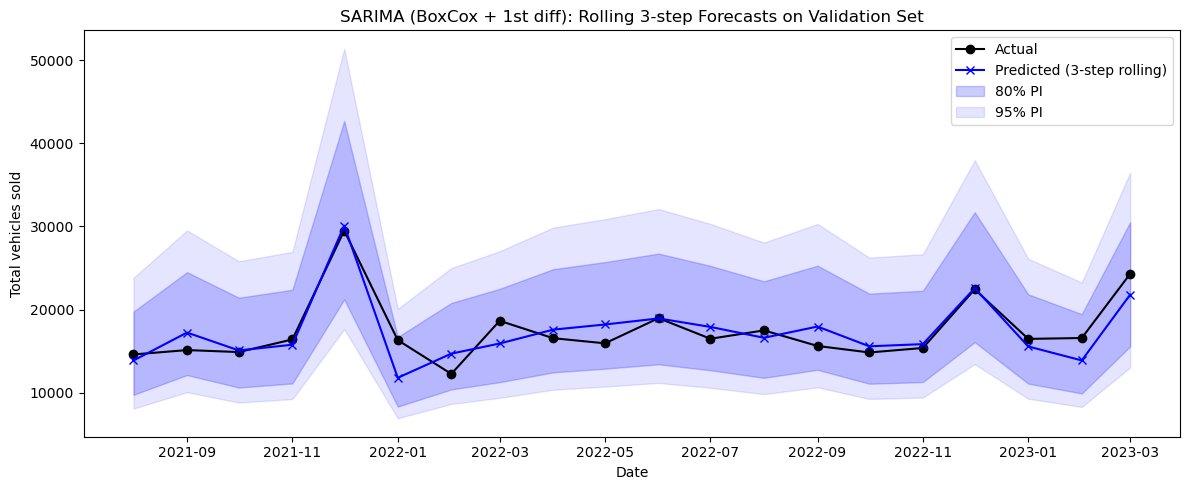

Validation RMSE (3-step rolling): 1860.06
Validation MAPE (3-step rolling): 8.90%
AIC (last rolling SARIMAX): -12.61
BIC (last rolling SARIMAX): 3.27


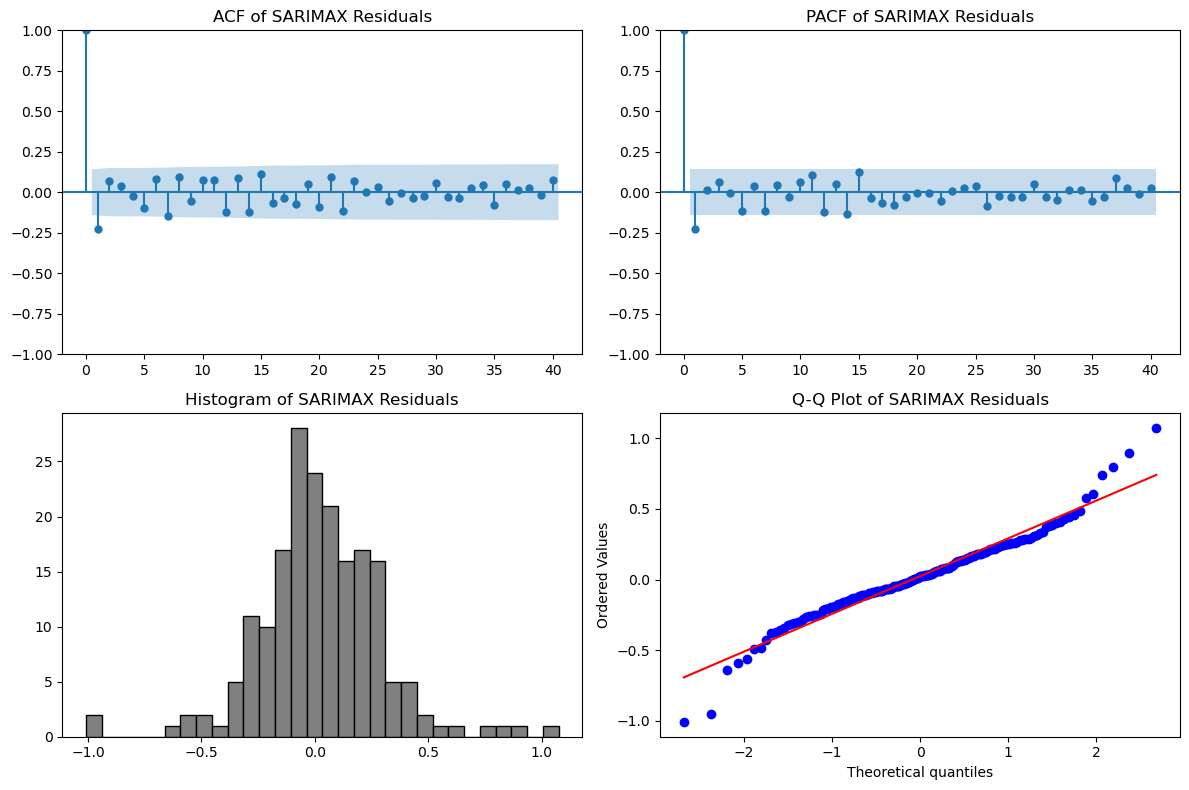

Ljung-Box test p-values (no autocorrelation if > 0.05):
      lb_stat  lb_pvalue
10  22.370056   0.013326
20  38.514953   0.007656
30  46.655580   0.026878


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np

# Parameters
horizon = 3

# Box–Cox train/val on level scale (already defined)
train_bc = y_bc_train.values
val_bc   = y_bc_val.values

# Actuals on the original scale, aligned to t+horizon−1
val_actuals = df[target].iloc[train_end_bc + horizon - 1 : val_end_bc].values

# Rolling, manual‐diff code with prediction intervals
preds_diff = []
conf_int_80 = []
conf_int_95 = []
for t in range(len(val_bc) - horizon + 1):
    history    = np.concatenate([train_bc, val_bc[:t]])
    history_diff = np.diff(history, 1)
    model = SARIMAX(
        history_diff,
        order=(2,0,1),
        seasonal_order=(1,0,0,12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fitted = model.fit(disp=False)
    fc = fitted.get_forecast(steps=horizon)
    fc_diff = fc.predicted_mean
    ci_80 = fc.conf_int(alpha=0.20)[-1]  # 80% PI for last step (numpy indexing)
    ci_95 = fc.conf_int(alpha=0.05)[-1]  # 95% PI for last step (numpy indexing)
    preds_diff.append(fc_diff[-1])
    conf_int_80.append(ci_80)
    conf_int_95.append(ci_95)

# Undifference: reconstruct BoxCox‐transformed level series
last_values   = np.concatenate([train_bc, val_bc])   # full level series
train_len_bc  = len(train_bc)                        # same as train_end_bc

undiff_preds_bc = []
undiff_ci80_lower = []
undiff_ci80_upper = []
undiff_ci95_lower = []
undiff_ci95_upper = []
for i, pred_diff in enumerate(preds_diff):
    idx      = train_len_bc + i + horizon - 2
    last_bc  = last_values[idx]
    undiff_pred = last_bc + pred_diff
    undiff_preds_bc.append(undiff_pred)
    # Intervals
    undiff_ci80_lower.append(last_bc + conf_int_80[i][0])
    undiff_ci80_upper.append(last_bc + conf_int_80[i][1])
    undiff_ci95_lower.append(last_bc + conf_int_95[i][0])
    undiff_ci95_upper.append(last_bc + conf_int_95[i][1])

undiff_preds_bc = np.array(undiff_preds_bc)
undiff_ci80_lower = np.array(undiff_ci80_lower)
undiff_ci80_upper = np.array(undiff_ci80_upper)
undiff_ci95_lower = np.array(undiff_ci95_lower)
undiff_ci95_upper = np.array(undiff_ci95_upper)

# Invert Box–Cox
lam, shift = boxcox_lambdas_all[target]
def inv_boxcox(y, lam):
    return np.exp(y) if lam == 0 else np.power(lam * y + 1, 1/lam)

val_forecast_orig_rolling = inv_boxcox(undiff_preds_bc, lam) - shift
ci_80_lower = inv_boxcox(undiff_ci80_lower, lam) - shift
ci_80_upper = inv_boxcox(undiff_ci80_upper, lam) - shift
ci_95_lower = inv_boxcox(undiff_ci95_lower, lam) - shift
ci_95_upper = inv_boxcox(undiff_ci95_upper, lam) - shift

# Plotting
import matplotlib.pyplot as plt
x_dates = df["Time Period (T)"][train_end+horizon-1:val_end]
plt.figure(figsize=(12, 5))
plt.plot(x_dates, val_actuals, label='Actual', marker='o', color='black')
plt.plot(x_dates, val_forecast_orig_rolling, label='Predicted (3-step rolling)', marker='x', color='blue')
plt.fill_between(x_dates, ci_80_lower, ci_80_upper, color='blue', alpha=0.2, label='80% PI')
plt.fill_between(x_dates, ci_95_lower, ci_95_upper, color='blue', alpha=0.1, label='95% PI')
plt.title('SARIMA (BoxCox + 1st diff): Rolling 3-step Forecasts on Validation Set')
plt.xlabel('Date')
plt.ylabel('Total vehicles sold')
plt.legend()
plt.tight_layout()
plt.show()

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
rmse_rolling = np.sqrt(mean_squared_error(val_actuals, val_forecast_orig_rolling))
mape_rolling = mean_absolute_percentage_error(val_actuals, val_forecast_orig_rolling)
print(f"Validation RMSE (3-step rolling): {rmse_rolling:.2f}")
print(f"Validation MAPE (3-step rolling): {mape_rolling:.2%}")

# Print AIC and BIC of the last fitted SARIMAX model
print(f"AIC (last rolling SARIMAX): {fitted.aic:.2f}")
print(f"BIC (last rolling SARIMAX): {fitted.bic:.2f}")

# --- Residual diagnostics ---


# Use residuals from the last fitted model in the rolling loop
residuals = fitted.resid

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# ACF plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(residuals, ax=axes[0, 0], lags=40)
axes[0, 0].set_title("ACF of SARIMAX Residuals")

# PACF plot
plot_pacf(residuals, ax=axes[0, 1], lags=40, method='ywm')
axes[0, 1].set_title("PACF of SARIMAX Residuals")

# Histogram
axes[1, 0].hist(residuals, bins=30, color='gray', edgecolor='black')
axes[1, 0].set_title("Histogram of SARIMAX Residuals")

# Q-Q plot
stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title("Q-Q Plot of SARIMAX Residuals")

plt.tight_layout()
plt.show()

# Ljung-Box test for autocorrelation (white noise)
lb_test = acorr_ljungbox(residuals, lags=[10, 20, 30], return_df=True)
print("Ljung-Box test p-values (no autocorrelation if > 0.05):")
print(lb_test[['lb_stat', 'lb_pvalue']])

#### Test

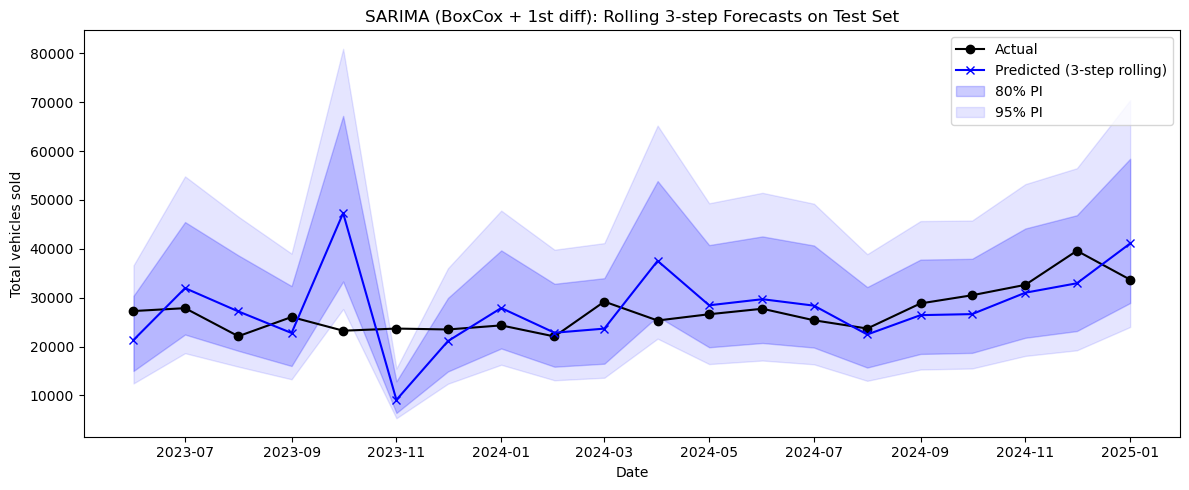

Test RMSE (3-step rolling): 7805.20
Test MAPE (3-step rolling): 21.40%
AIC (last rolling SARIMAX): 15.25
BIC (last rolling SARIMAX): 31.13


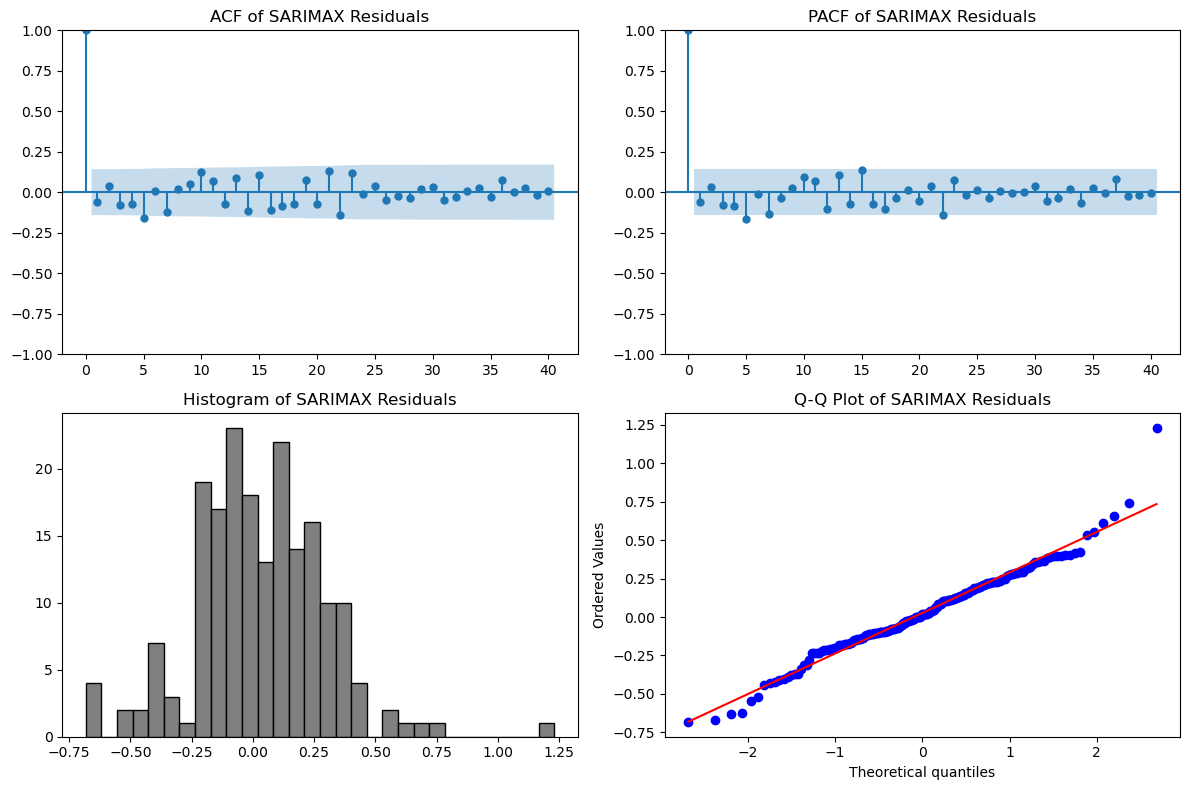

Ljung-Box test p-values (no autocorrelation if > 0.05):
      lb_stat  lb_pvalue
10  15.298367   0.121557
20  31.903650   0.044336
30  44.614920   0.041904


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np

# Parameters
horizon = 3

# Use Box–Cox train/test on level scale (already defined)
train_bc = y_bc_train.values
test_bc  = y_bc_test.values

# Actuals on the original scale, aligned to t+horizon−1
test_actuals = df[target].iloc[val_end_bc + horizon - 1 :].values

# Rolling, manual‐diff code with prediction intervals
preds_diff = []
conf_int_80 = []
conf_int_95 = []
for t in range(len(test_bc) - horizon + 1):
    history    = np.concatenate([train_bc, test_bc[:t]])
    history_diff = np.diff(history, 1)
    model = SARIMAX(
        history_diff,
        order=(2,0,1),
        seasonal_order=(1,0,0,12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fitted = model.fit(disp=False)
    fc = fitted.get_forecast(steps=horizon)
    fc_diff = fc.predicted_mean
    ci_80 = fc.conf_int(alpha=0.20)[-1]  # 80% PI for last step (numpy indexing)
    ci_95 = fc.conf_int(alpha=0.05)[-1]  # 95% PI for last step (numpy indexing)
    preds_diff.append(fc_diff[-1])
    conf_int_80.append(ci_80)
    conf_int_95.append(ci_95)

# Undifference: reconstruct BoxCox‐transformed level series
last_values   = np.concatenate([train_bc, test_bc])   # full level series
train_len_bc  = len(train_bc)                        # same as train_end_bc

undiff_preds_bc = []
undiff_ci80_lower = []
undiff_ci80_upper = []
undiff_ci95_lower = []
undiff_ci95_upper = []
for i, pred_diff in enumerate(preds_diff):
    idx      = train_len_bc + i + horizon - 2
    last_bc  = last_values[idx]
    undiff_pred = last_bc + pred_diff
    undiff_preds_bc.append(undiff_pred)
    # Intervals
    undiff_ci80_lower.append(last_bc + conf_int_80[i][0])
    undiff_ci80_upper.append(last_bc + conf_int_80[i][1])
    undiff_ci95_lower.append(last_bc + conf_int_95[i][0])
    undiff_ci95_upper.append(last_bc + conf_int_95[i][1])

undiff_preds_bc = np.array(undiff_preds_bc)
undiff_ci80_lower = np.array(undiff_ci80_lower)
undiff_ci80_upper = np.array(undiff_ci80_upper)
undiff_ci95_lower = np.array(undiff_ci95_lower)
undiff_ci95_upper = np.array(undiff_ci95_upper)

# Invert Box–Cox
lam, shift = boxcox_lambdas_all[target]
def inv_boxcox(y, lam):
    return np.exp(y) if lam == 0 else np.power(lam * y + 1, 1/lam)

test_forecast_orig_rolling = inv_boxcox(undiff_preds_bc, lam) - shift
ci_80_lower = inv_boxcox(undiff_ci80_lower, lam) - shift
ci_80_upper = inv_boxcox(undiff_ci80_upper, lam) - shift
ci_95_lower = inv_boxcox(undiff_ci95_lower, lam) - shift
ci_95_upper = inv_boxcox(undiff_ci95_upper, lam) - shift

# Plotting
import matplotlib.pyplot as plt
x_dates = df["Time Period (T)"][val_end+horizon-1:]
plt.figure(figsize=(12, 5))
plt.plot(x_dates, test_actuals, label='Actual', marker='o', color='black')
plt.plot(x_dates, test_forecast_orig_rolling, label='Predicted (3-step rolling)', marker='x', color='blue')
plt.fill_between(x_dates, ci_80_lower, ci_80_upper, color='blue', alpha=0.2, label='80% PI')
plt.fill_between(x_dates, ci_95_lower, ci_95_upper, color='blue', alpha=0.1, label='95% PI')
plt.title('SARIMA (BoxCox + 1st diff): Rolling 3-step Forecasts on Test Set')
plt.xlabel('Date')
plt.ylabel('Total vehicles sold')
plt.legend()
plt.tight_layout()
plt.show()

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
rmse_rolling = np.sqrt(mean_squared_error(test_actuals, test_forecast_orig_rolling))
mape_rolling = mean_absolute_percentage_error(test_actuals, test_forecast_orig_rolling)
print(f"Test RMSE (3-step rolling): {rmse_rolling:.2f}")
print(f"Test MAPE (3-step rolling): {mape_rolling:.2%}")

# Print AIC and BIC of the last fitted SARIMAX model
print(f"AIC (last rolling SARIMAX): {fitted.aic:.2f}")
print(f"BIC (last rolling SARIMAX): {fitted.bic:.2f}")

# --- Residual diagnostics ---

# Use residuals from the last fitted model in the rolling loop
residuals = fitted.resid

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# ACF plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(residuals, ax=axes[0, 0], lags=40)
axes[0, 0].set_title("ACF of SARIMAX Residuals")

# PACF plot
plot_pacf(residuals, ax=axes[0, 1], lags=40, method='ywm')
axes[0, 1].set_title("PACF of SARIMAX Residuals")

# Histogram
axes[1, 0].hist(residuals, bins=30, color='gray', edgecolor='black')
axes[1, 0].set_title("Histogram of SARIMAX Residuals")

# Q-Q plot
import scipy.stats as stats
stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title("Q-Q Plot of SARIMAX Residuals")

plt.tight_layout()
plt.show()

# Ljung-Box test for autocorrelation (white noise)
from statsmodels.stats.diagnostic import acorr_ljungbox
lb_test = acorr_ljungbox(residuals, lags=[10, 20, 30], return_df=True)
print("Ljung-Box test p-values (no autocorrelation if > 0.05):")
print(lb_test[['lb_stat', 'lb_pvalue']])

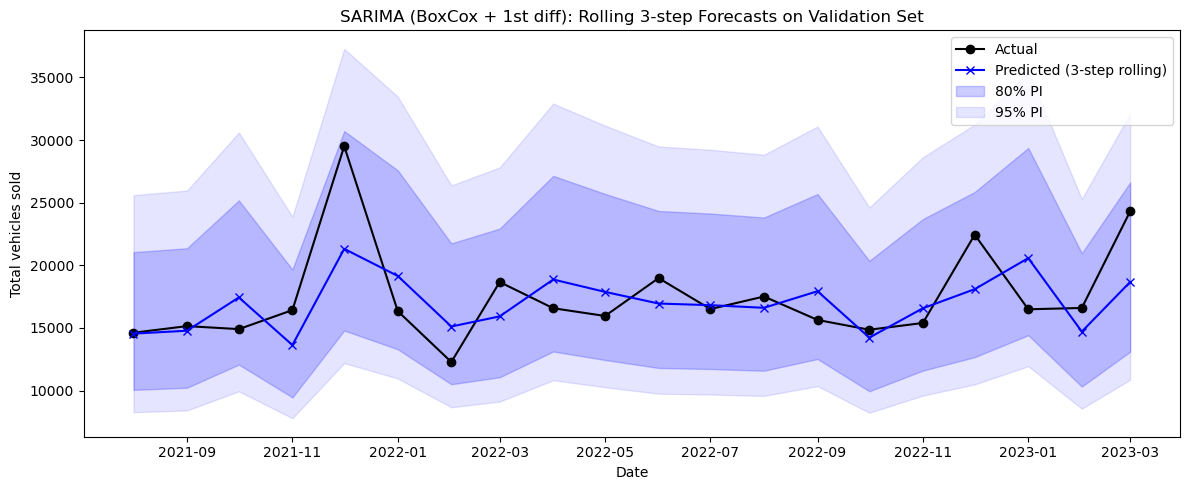

Validation RMSE (3-step rolling): 3138.19
Validation MAPE (3-step rolling): 13.42%


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np

# Parameters
horizon = 3

# Box–Cox train/val on level scale (already defined)
train_bc = y_bc_train.values
val_bc   = y_bc_val.values

# Actuals on the original scale, aligned to t+horizon−1
val_actuals = df[target].iloc[train_end_bc + horizon - 1 : val_end_bc].values

# Rolling, manual‐diff code with prediction intervals
preds_diff = []
conf_int_80 = []
conf_int_95 = []
for t in range(len(val_bc) - horizon + 1):
    history    = np.concatenate([train_bc, val_bc[:t]])
    history_diff = np.diff(history, 1)
    model = SARIMAX(
        history_diff,
        order=(1,0,2),
        seasonal_order=(0,0,1,12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fitted = model.fit(disp=False)
    fc = fitted.get_forecast(steps=horizon)
    fc_diff = fc.predicted_mean
    ci_80 = fc.conf_int(alpha=0.20)[-1]  # 80% PI for last step (numpy indexing)
    ci_95 = fc.conf_int(alpha=0.05)[-1]  # 95% PI for last step (numpy indexing)
    preds_diff.append(fc_diff[-1])
    conf_int_80.append(ci_80)
    conf_int_95.append(ci_95)

# Undifference: reconstruct BoxCox‐transformed level series
last_values   = np.concatenate([train_bc, val_bc])   # full level series
train_len_bc  = len(train_bc)                        # same as train_end_bc

undiff_preds_bc = []
undiff_ci80_lower = []
undiff_ci80_upper = []
undiff_ci95_lower = []
undiff_ci95_upper = []
for i, pred_diff in enumerate(preds_diff):
    idx      = train_len_bc + i + horizon - 2
    last_bc  = last_values[idx]
    undiff_pred = last_bc + pred_diff
    undiff_preds_bc.append(undiff_pred)
    # Intervals
    undiff_ci80_lower.append(last_bc + conf_int_80[i][0])
    undiff_ci80_upper.append(last_bc + conf_int_80[i][1])
    undiff_ci95_lower.append(last_bc + conf_int_95[i][0])
    undiff_ci95_upper.append(last_bc + conf_int_95[i][1])

undiff_preds_bc = np.array(undiff_preds_bc)
undiff_ci80_lower = np.array(undiff_ci80_lower)
undiff_ci80_upper = np.array(undiff_ci80_upper)
undiff_ci95_lower = np.array(undiff_ci95_lower)
undiff_ci95_upper = np.array(undiff_ci95_upper)

# Invert Box–Cox
lam, shift = boxcox_lambdas_all[target]
def inv_boxcox(y, lam):
    return np.exp(y) if lam == 0 else np.power(lam * y + 1, 1/lam)

val_forecast_orig_rolling = inv_boxcox(undiff_preds_bc, lam) - shift
ci_80_lower = inv_boxcox(undiff_ci80_lower, lam) - shift
ci_80_upper = inv_boxcox(undiff_ci80_upper, lam) - shift
ci_95_lower = inv_boxcox(undiff_ci95_lower, lam) - shift
ci_95_upper = inv_boxcox(undiff_ci95_upper, lam) - shift

# Plotting
import matplotlib.pyplot as plt
x_dates = df["Time Period (T)"][train_end+horizon-1:val_end]
plt.figure(figsize=(12, 5))
plt.plot(x_dates, val_actuals, label='Actual', marker='o', color='black')
plt.plot(x_dates, val_forecast_orig_rolling, label='Predicted (3-step rolling)', marker='x', color='blue')
plt.fill_between(x_dates, ci_80_lower, ci_80_upper, color='blue', alpha=0.2, label='80% PI')
plt.fill_between(x_dates, ci_95_lower, ci_95_upper, color='blue', alpha=0.1, label='95% PI')
plt.title('SARIMA (BoxCox + 1st diff): Rolling 3-step Forecasts on Validation Set')
plt.xlabel('Date')
plt.ylabel('Total vehicles sold')
plt.legend()
plt.tight_layout()
plt.show()

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
rmse_rolling = np.sqrt(mean_squared_error(val_actuals, val_forecast_orig_rolling))
mape_rolling = mean_absolute_percentage_error(val_actuals, val_forecast_orig_rolling)
print(f"Validation RMSE (3-step rolling): {rmse_rolling:.2f}")
print(f"Validation MAPE (3-step rolling): {mape_rolling:.2%}")

ValueError: 'y1' is not 1-dimensional

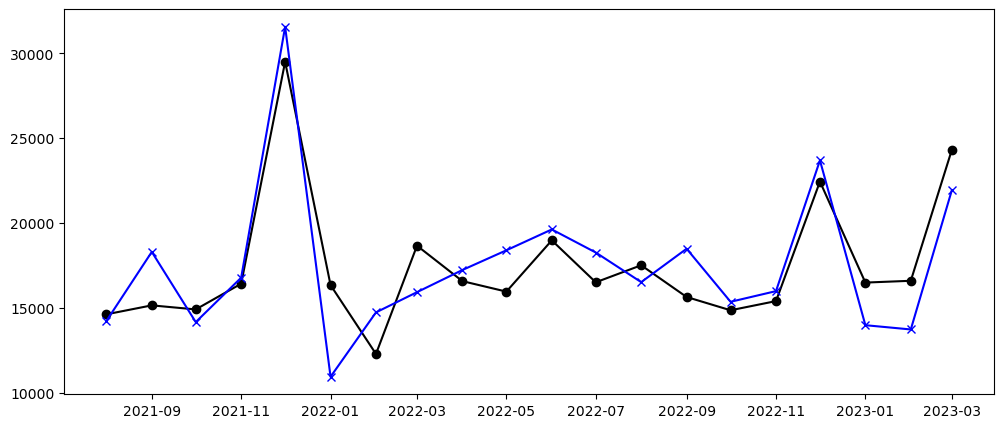

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np

# Parameters
horizon = 3

# Box–Cox train/val on level scale (already defined)
train_bc = y_bc_train.values
val_bc   = y_bc_val.values

# Actuals on the original scale, aligned to t+horizon−1
val_actuals = df[target].iloc[train_end_bc + horizon - 1 : val_end_bc].values

# Rolling, manual‐diff code with prediction intervals
preds_diff = []
conf_int_80 = []
conf_int_95 = []
for t in range(len(val_bc) - horizon + 1):
    history    = np.concatenate([train_bc, val_bc[:t]])
    history_diff = np.diff(history, 1)
    model = SARIMAX(
        history_diff,
        order=(0,0,1),
        seasonal_order=(1,0,1,12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fitted = model.fit(disp=False)
    fc = fitted.get_forecast(steps=horizon)
    fc_diff = fc.predicted_mean
    ci_80 = fc.conf_int(alpha=0.20)  # 80% PI for last step
    ci_95 = fc.conf_int(alpha=0.05)  # 95% PI for last step
    preds_diff.append(fc_diff[-1])
    conf_int_80.append(ci_80)
    conf_int_95.append(ci_95)

# Undifference: reconstruct BoxCox‐transformed level series
last_values   = np.concatenate([train_bc, val_bc])   # full level series
train_len_bc  = len(train_bc)                        # same as train_end_bc

undiff_preds_bc = []
undiff_ci80_lower = []
undiff_ci80_upper = []
undiff_ci95_lower = []
undiff_ci95_upper = []
for i, pred_diff in enumerate(preds_diff):
    idx      = train_len_bc + i + horizon - 2
    last_bc  = last_values[idx]
    undiff_pred = last_bc + pred_diff
    undiff_preds_bc.append(undiff_pred)
    # Intervals
    undiff_ci80_lower.append(last_bc + conf_int_80[i][0])
    undiff_ci80_upper.append(last_bc + conf_int_80[i][1])
    undiff_ci95_lower.append(last_bc + conf_int_95[i][0])
    undiff_ci95_upper.append(last_bc + conf_int_95[i][1])

undiff_preds_bc = np.array(undiff_preds_bc)
undiff_ci80_lower = np.array(undiff_ci80_lower)
undiff_ci80_upper = np.array(undiff_ci80_upper)
undiff_ci95_lower = np.array(undiff_ci95_lower)
undiff_ci95_upper = np.array(undiff_ci95_upper)

# Invert Box–Cox
lam, shift = boxcox_lambdas_all[target]
def inv_boxcox(y, lam):
    return np.exp(y) if lam == 0 else np.power(lam * y + 1, 1/lam)

val_forecast_orig_rolling = inv_boxcox(undiff_preds_bc, lam) - shift
ci_80_lower = inv_boxcox(undiff_ci80_lower, lam) - shift
ci_80_upper = inv_boxcox(undiff_ci80_upper, lam) - shift
ci_95_lower = inv_boxcox(undiff_ci95_lower, lam) - shift
ci_95_upper = inv_boxcox(undiff_ci95_upper, lam) - shift

# Plotting
import matplotlib.pyplot as plt
x_dates = df["Time Period (T)"][train_end+horizon-1:val_end]
plt.figure(figsize=(12, 5))
plt.plot(x_dates, val_actuals, label='Actual', marker='o', color='black')
plt.plot(x_dates, val_forecast_orig_rolling, label='Predicted (3-step rolling)', marker='x', color='blue')
plt.fill_between(x_dates, ci_80_lower, ci_80_upper, color='blue', alpha=0.2, label='80% PI')
plt.fill_between(x_dates, ci_95_lower, ci_95_upper, color='blue', alpha=0.1, label='95% PI')
plt.title('SARIMA (BoxCox + 1st diff): Rolling 3-step Forecasts on Validation Set')
plt.xlabel('Date')
plt.ylabel('Total vehicles sold')
plt.legend()
plt.tight_layout()
plt.show()

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
rmse_rolling = np.sqrt(mean_squared_error(val_actuals, val_forecast_orig_rolling))
mape_rolling = mean_absolute_percentage_error(val_actuals, val_forecast_orig_rolling)
print(f"Validation RMSE (3-step rolling): {rmse_rolling:.2f}")
print(f"Validation MAPE (3-step rolling): {mape_rolling:.2%}")

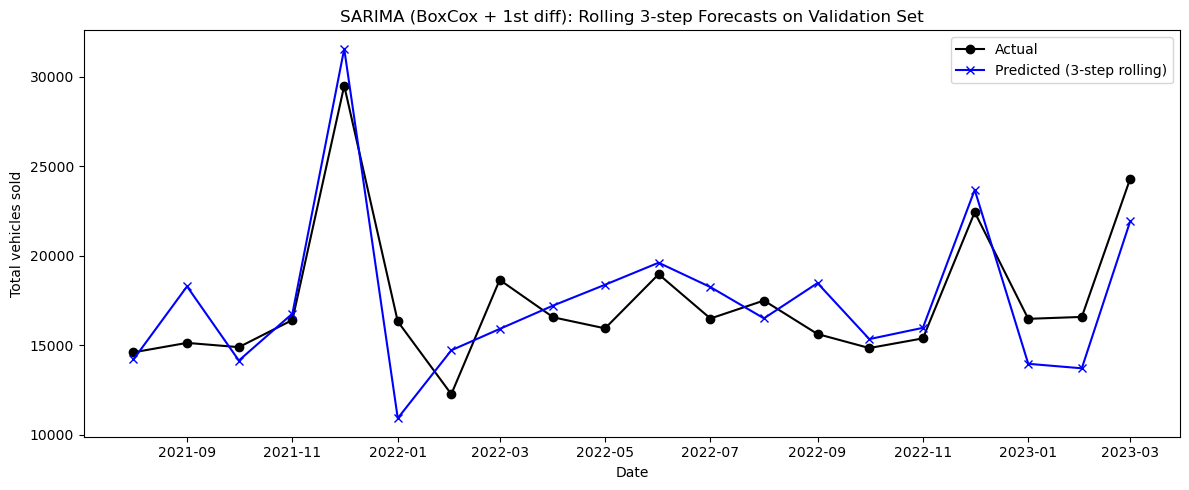

Validation RMSE (3-step rolling): 2226.31
Validation MAPE (3-step rolling): 10.89%


In [ ]:
# Assume: boxcox_all[target], boxcox_lambdas_all[target], train_end, val_end, df, y_val, etc. are already defined

from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np

# Parameters
horizon = 3

# Box–Cox train/val on level scale (already defined)
train_bc = y_bc_train.values
val_bc   = y_bc_val.values

# Actuals on the original scale, aligned to t+horizon−1
val_actuals = df[target].iloc[train_end_bc + horizon - 1 : val_end_bc].values

# Then proceed with your rolling, manual‐diff code…
preds_diff = []
for t in range(len(val_bc) - horizon + 1):
    history    = np.concatenate([train_bc, val_bc[:t]])
    history_diff = np.diff(history, 1)
    model = SARIMAX(
        history_diff,
        order=(0,0,1),
        seasonal_order=(1,0,1,12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fitted = model.fit(disp=False)
    fc_diff = fitted.get_forecast(steps=horizon).predicted_mean
    preds_diff.append(fc_diff[-1])

# Undifference: reconstruct BoxCox‐transformed level series
last_values   = np.concatenate([train_bc, val_bc])   # full level series
train_len_bc  = len(train_bc)                        # same as train_end_bc

undiff_preds_bc = []
for i, pred_diff in enumerate(preds_diff):
    # position of the "last known" level before the h-step‐ahead window:
    #   t_star = train_len_bc + i + horizon - 2
    idx      = train_len_bc + i + horizon - 2
    last_bc  = last_values[idx]
    undiff_preds_bc.append(last_bc + pred_diff)

undiff_preds_bc = np.array(undiff_preds_bc)

# Invert Box–Cox
lam, shift = boxcox_lambdas_all[target]
def inv_boxcox(y, lam):
    return np.exp(y) if lam == 0 else np.power(lam * y + 1, 1/lam)

val_forecast_orig_rolling = inv_boxcox(undiff_preds_bc, lam) - shift

# Plotting
import matplotlib.pyplot as plt
x_dates = df["Time Period (T)"][train_end+horizon-1:val_end]
plt.figure(figsize=(12, 5))
plt.plot(x_dates, val_actuals, label='Actual', marker='o', color='black')
plt.plot(x_dates, val_forecast_orig_rolling, label='Predicted (3-step rolling)', marker='x', color='blue')
plt.title('SARIMA (BoxCox + 1st diff): Rolling 3-step Forecasts on Validation Set')
plt.xlabel('Date')
plt.ylabel('Total vehicles sold')
plt.legend()
plt.tight_layout()
plt.show()

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
rmse_rolling = np.sqrt(mean_squared_error(val_actuals, val_forecast_orig_rolling))
mape_rolling = mean_absolute_percentage_error(val_actuals, val_forecast_orig_rolling)
print(f"Validation RMSE (3-step rolling): {rmse_rolling:.2f}")
print(f"Validation MAPE (3-step rolling): {mape_rolling:.2%}")

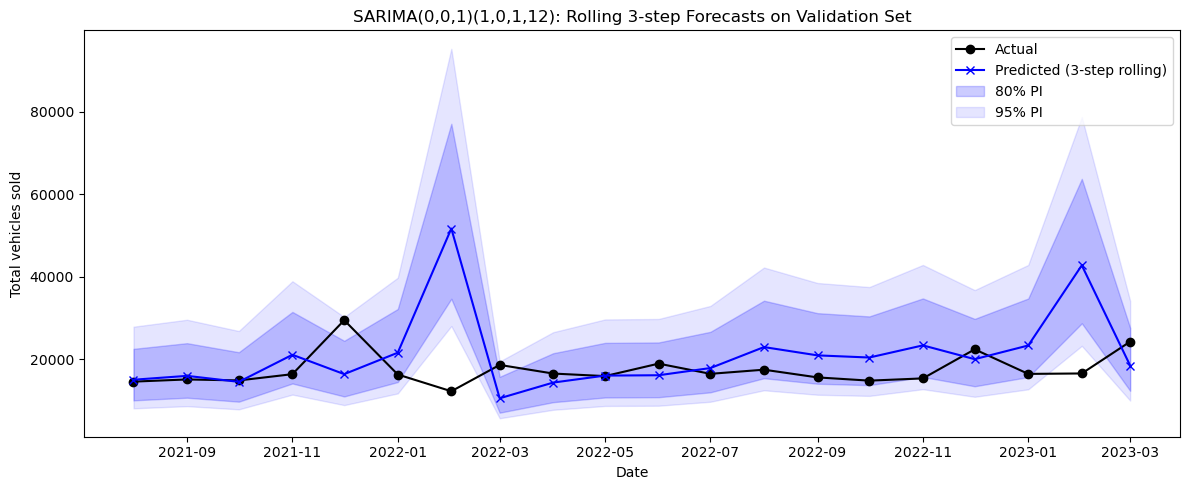

Validation RMSE (3-step rolling): 11806.73
Validation MAPE (3-step rolling): 45.40%
Last fitted SARIMA model AIC: 92.78
Last fitted SARIMA model BIC: 105.51


In [ ]:
# --- Walk-forward (rolling) validation for 3-step-ahead forecasts with prediction intervals ---
history = list(boxcox_all[target][:train_end])  # start with train set
val_bc = boxcox_all[target][train_end:val_end]  # validation set (BoxCox-transformed)
horizon = 3  # 3-step ahead
predictions_bc = []
conf_int_80 = []
conf_int_95 = []

for t in range(len(val_bc) - horizon + 1):
    # Fit model on all history up to t
    model = SARIMAX(
        history,
        order=(0, 0, 1),
        seasonal_order=(1, 0, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fitted_model = model.fit(disp=False)
    
    # Recursive 3-step forecast with intervals
    temp_history = history.copy()
    for step in range(horizon):
        idx = t + step
        res = fitted_model.get_forecast(steps=1)
        yhat = res.predicted_mean[0]
        ci_80 = res.conf_int(alpha=0.20)[0]
        ci_95 = res.conf_int(alpha=0.05)[0]
        temp_history.append(yhat)
    predictions_bc.append(yhat)  # Only keep the 3rd step prediction
    conf_int_80.append(ci_80)
    conf_int_95.append(ci_95)

    # Update history with actual for next rolling window
    history.append(val_bc[t])

# Inverse BoxCox transform
lam, shift = boxcox_lambdas_all[target]
def inv_boxcox(y, lam):
    if lam == 0:
        return np.exp(y)
    else:
        return np.power(lam * y + 1, 1/lam)

val_forecast_orig_rolling = inv_boxcox(np.array(predictions_bc), lam) - shift
actuals = y_val.values[horizon-1:]

# Inverse transform intervals
conf_int_80 = np.array(conf_int_80)
conf_int_95 = np.array(conf_int_95)
ci_80_lower = inv_boxcox(conf_int_80[:, 0], lam) - shift
ci_80_upper = inv_boxcox(conf_int_80[:, 1], lam) - shift
ci_95_lower = inv_boxcox(conf_int_95[:, 0], lam) - shift
ci_95_upper = inv_boxcox(conf_int_95[:, 1], lam) - shift

# Plot actual vs predicted (rolling 3-step) with intervals
plt.figure(figsize=(12, 5))
x_dates = df["Time Period (T)"][train_end+horizon-1:val_end]
plt.plot(x_dates, actuals, label='Actual', marker='o', color='black')
plt.plot(x_dates, val_forecast_orig_rolling, label='Predicted (3-step rolling)', marker='x', color='blue')
plt.fill_between(x_dates, ci_80_lower, ci_80_upper, color='blue', alpha=0.2, label='80% PI')
plt.fill_between(x_dates, ci_95_lower, ci_95_upper, color='blue', alpha=0.1, label='95% PI')
plt.title('SARIMA(0,0,1)(1,0,1,12): Rolling 3-step Forecasts on Validation Set')
plt.xlabel('Date')
plt.ylabel('Total vehicles sold')
plt.legend()
plt.tight_layout()
plt.show()

# Calculate RMSE and MAPE for rolling 3-step
rmse_rolling = np.sqrt(mean_squared_error(actuals, val_forecast_orig_rolling))
mape_rolling = mean_absolute_percentage_error(actuals, val_forecast_orig_rolling)
print(f"Validation RMSE (3-step rolling): {rmse_rolling:.2f}")
print(f"Validation MAPE (3-step rolling): {mape_rolling:.2%}")

# Print AIC and BIC of last fitted model in rolling validation
print(f"Last fitted SARIMA model AIC: {fitted_model.aic:.2f}")
print(f"Last fitted SARIMA model BIC: {fitted_model.bic:.2f}")

looking at the plot the predicted line follows the actual line quite well, with some deviations. The 80% and 95% prediction intervals are  quite wide, indicating that there is a lot of uncertainty in the predictions. This is expected, as the model is only using past values to make predictions and does not take into account any future information. also conscidering the 11806 rsme and 45% mape the prediction is still better than flipping a coin, but not very accurate. 

The auto-ARIMA model (0,0,1)(1,0,1,12) demonstrates classic overfitting behavior: although its AIC/BIC values are low, its forecast quality is poor. It strongly overestimates peak months and fails to capture leveling patterns in the data.

## 6b Manual tuning

for the manually tuning of the model, i will use the following steps:
1. i will look at the ACF and PACF plots to determine the order of the AR and MA terms.
2. build from the auto_arima model, i will try to improve the model by changing the order of the AR and MA terms.

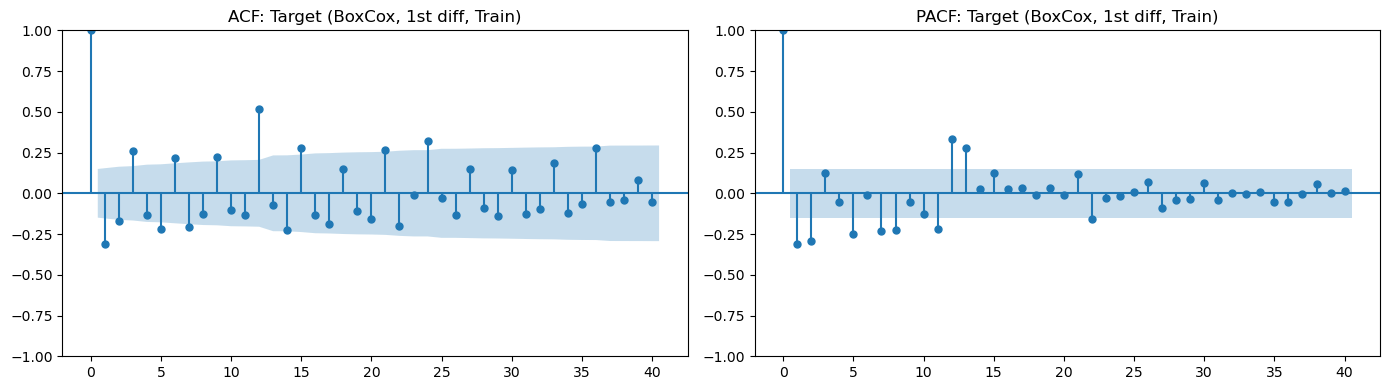

In [ ]:

# Use the BoxCox-transformed, first-differenced target from the training set
target_diff = diff_results[target]

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(target_diff, ax=axes[0], lags=40)
axes[0].set_title('ACF: Target (BoxCox, 1st diff, Train)')
plot_pacf(target_diff, ax=axes[1], lags=40, method='ywm')
axes[1].set_title('PACF: Target (BoxCox, 1st diff, Train)')
plt.tight_layout()
plt.show()

### Iteration 1
order=(1,0,1), seasonal_order=(1,0,1,12)
Reason:
This is  SARIMA model captures both short-term effects (lag 1 autocorrelation and noise) and yearly seasonal patterns.

AR(1) captures direct dependence on the previous month.

MA(1) accounts for noise and unexpected fluctuations.

Seasonal AR(1) and MA(1) capture yearly patterns (e.g., EV purchases each spring/autumn).

Often used as a starting point because it is sufficiently flexible without overfitting.



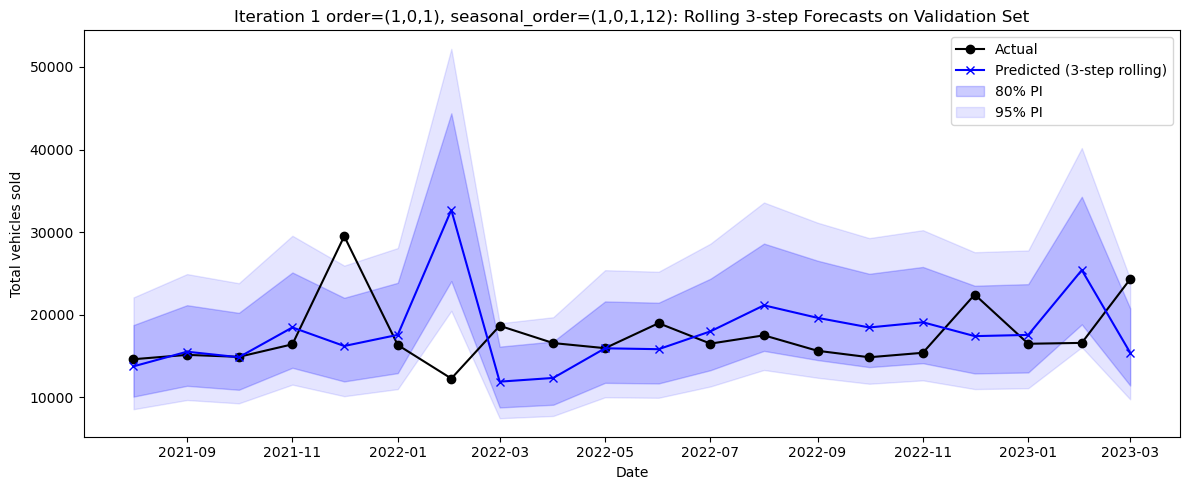

Validation RMSE (3-step rolling): 6762.12
Validation MAPE (3-step rolling): 27.03%
Last fitted SARIMA model AIC: -9.96
Last fitted SARIMA model BIC: 5.95


In [ ]:
warnings.filterwarnings("ignore", category=ValueWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# --- Walk-forward (rolling) validation for 3-step-ahead forecasts with prediction intervals ---
history = list(boxcox_all[target][:train_end])  # start with train set
val_bc = boxcox_all[target][train_end:val_end]  # validation set (BoxCox-transformed)
horizon = 3  # 3-step ahead
predictions_bc = []
conf_int_80 = []
conf_int_95 = []

for t in range(len(val_bc) - horizon + 1):
    # Fit model on all history up to t
    model = SARIMAX(
        history,
        order=(1, 0, 1),
        seasonal_order=(1, 0, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fitted_model = model.fit(disp=False)
    
    # Recursive 3-step forecast with intervals
    temp_history = history.copy()
    for step in range(horizon):
        idx = t + step
        res = fitted_model.get_forecast(steps=1)
        yhat = res.predicted_mean[0]
        ci_80 = res.conf_int(alpha=0.20)[0]
        ci_95 = res.conf_int(alpha=0.05)[0]
        temp_history.append(yhat)
    predictions_bc.append(yhat)  # Only keep the 3rd step prediction
    conf_int_80.append(ci_80)
    conf_int_95.append(ci_95)

    # Update history with actual for next rolling window
    history.append(val_bc[t])

# Inverse BoxCox transform
lam, shift = boxcox_lambdas_all[target]
def inv_boxcox(y, lam):
    if lam == 0:
        return np.exp(y)
    else:
        return np.power(lam * y + 1, 1/lam)

val_forecast_orig_rolling = inv_boxcox(np.array(predictions_bc), lam) - shift
actuals = y_val.values[horizon-1:]

# Inverse transform intervals
conf_int_80 = np.array(conf_int_80)
conf_int_95 = np.array(conf_int_95)
ci_80_lower = inv_boxcox(conf_int_80[:, 0], lam) - shift
ci_80_upper = inv_boxcox(conf_int_80[:, 1], lam) - shift
ci_95_lower = inv_boxcox(conf_int_95[:, 0], lam) - shift
ci_95_upper = inv_boxcox(conf_int_95[:, 1], lam) - shift

# Plot actual vs predicted (rolling 3-step) with intervals
plt.figure(figsize=(12, 5))
x_dates = df["Time Period (T)"][train_end+horizon-1:val_end]
plt.plot(x_dates, actuals, label='Actual', marker='o', color='black')
plt.plot(x_dates, val_forecast_orig_rolling, label='Predicted (3-step rolling)', marker='x', color='blue')
plt.fill_between(x_dates, ci_80_lower, ci_80_upper, color='blue', alpha=0.2, label='80% PI')
plt.fill_between(x_dates, ci_95_lower, ci_95_upper, color='blue', alpha=0.1, label='95% PI')
plt.title('Iteration 1 order=(1,0,1), seasonal_order=(1,0,1,12): Rolling 3-step Forecasts on Validation Set')
plt.xlabel('Date')
plt.ylabel('Total vehicles sold')
plt.legend()
plt.tight_layout()
plt.show()

# Calculate RMSE and MAPE for rolling 3-step
rmse_rolling = np.sqrt(mean_squared_error(actuals, val_forecast_orig_rolling))
mape_rolling = mean_absolute_percentage_error(actuals, val_forecast_orig_rolling)
print(f"Validation RMSE (3-step rolling): {rmse_rolling:.2f}")
print(f"Validation MAPE (3-step rolling): {mape_rolling:.2%}")

# Print AIC and BIC of last fitted model in rolling validation
print(f"Last fitted SARIMA model AIC: {fitted_model.aic:.2f}")
print(f"Last fitted SARIMA model BIC: {fitted_model.bic:.2f}")

### Iteration 2 
order=(0,0,2), seasonal_order=(1,0,1,12)
Reason:
This variant omits the AR component and increases the MA component to 2.

The goal is to test whether the model performs better by placing more emphasis on noise correction instead of trend.

Useful when the ACF shows multiple significant lags, but the PACF drops off quickly — a signal that MA > 1 might be beneficial.


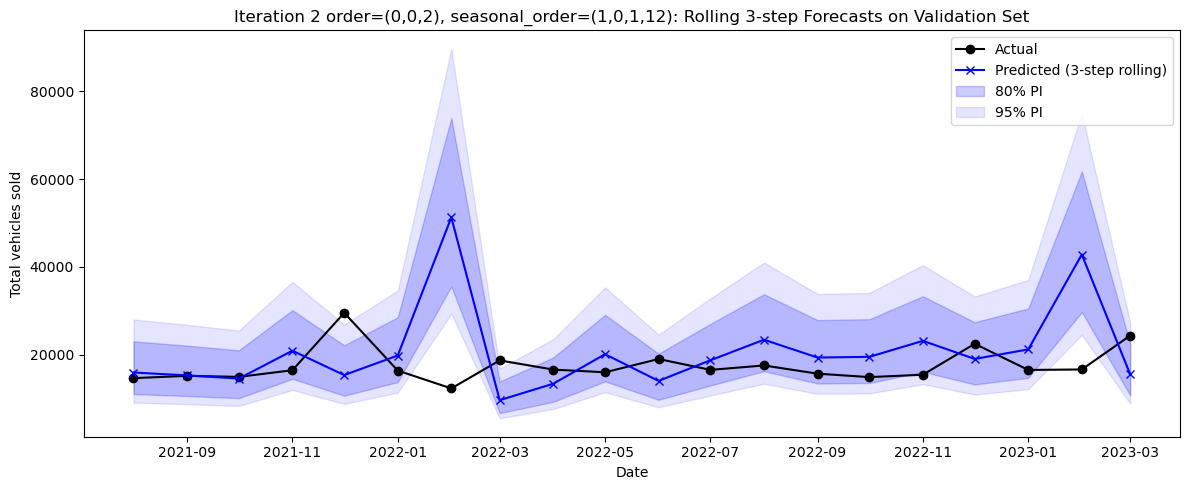

Validation RMSE (3-step rolling): 11877.55
Validation MAPE (3-step rolling): 46.78%
Last fitted SARIMA model AIC: 65.91
Last fitted SARIMA model BIC: 81.79


In [ ]:
warnings.filterwarnings("ignore", category=ValueWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
# --- Walk-forward (rolling) validation for 3-step-ahead forecasts with prediction intervals ---
history = list(boxcox_all[target][:train_end])  # start with train set
val_bc = boxcox_all[target][train_end:val_end]  # validation set (BoxCox-transformed)
horizon = 3  # 3-step ahead
predictions_bc = []
conf_int_80 = []
conf_int_95 = []

for t in range(len(val_bc) - horizon + 1):
    # Fit model on all history up to t
    model = SARIMAX(
        history,
        order=(0, 0, 2),
        seasonal_order=(1, 0, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fitted_model = model.fit(disp=False)
    
    # Recursive 3-step forecast with intervals
    temp_history = history.copy()
    for step in range(horizon):
        idx = t + step
        res = fitted_model.get_forecast(steps=1)
        yhat = res.predicted_mean[0]
        ci_80 = res.conf_int(alpha=0.20)[0]
        ci_95 = res.conf_int(alpha=0.05)[0]
        temp_history.append(yhat)
    predictions_bc.append(yhat)  # Only keep the 3rd step prediction
    conf_int_80.append(ci_80)
    conf_int_95.append(ci_95)

    # Update history with actual for next rolling window
    history.append(val_bc[t])

# Inverse BoxCox transform
lam, shift = boxcox_lambdas_all[target]
def inv_boxcox(y, lam):
    if lam == 0:
        return np.exp(y)
    else:
        return np.power(lam * y + 1, 1/lam)

val_forecast_orig_rolling = inv_boxcox(np.array(predictions_bc), lam) - shift
actuals = y_val.values[horizon-1:]

# Inverse transform intervals
conf_int_80 = np.array(conf_int_80)
conf_int_95 = np.array(conf_int_95)
ci_80_lower = inv_boxcox(conf_int_80[:, 0], lam) - shift
ci_80_upper = inv_boxcox(conf_int_80[:, 1], lam) - shift
ci_95_lower = inv_boxcox(conf_int_95[:, 0], lam) - shift
ci_95_upper = inv_boxcox(conf_int_95[:, 1], lam) - shift

# Plot actual vs predicted (rolling 3-step) with intervals
plt.figure(figsize=(12, 5))
x_dates = df["Time Period (T)"][train_end+horizon-1:val_end]
plt.plot(x_dates, actuals, label='Actual', marker='o', color='black')
plt.plot(x_dates, val_forecast_orig_rolling, label='Predicted (3-step rolling)', marker='x', color='blue')
plt.fill_between(x_dates, ci_80_lower, ci_80_upper, color='blue', alpha=0.2, label='80% PI')
plt.fill_between(x_dates, ci_95_lower, ci_95_upper, color='blue', alpha=0.1, label='95% PI')
plt.title('Iteration 2 order=(0,0,2), seasonal_order=(1,0,1,12): Rolling 3-step Forecasts on Validation Set')
plt.xlabel('Date')
plt.ylabel('Total vehicles sold')
plt.legend()
plt.tight_layout()
plt.show()

# Calculate RMSE and MAPE for rolling 3-step
rmse_rolling = np.sqrt(mean_squared_error(actuals, val_forecast_orig_rolling))
mape_rolling = mean_absolute_percentage_error(actuals, val_forecast_orig_rolling)
print(f"Validation RMSE (3-step rolling): {rmse_rolling:.2f}")
print(f"Validation MAPE (3-step rolling): {mape_rolling:.2%}")

# Print AIC and BIC of last fitted model in rolling validation
print(f"Last fitted SARIMA model AIC: {fitted_model.aic:.2f}")
print(f"Last fitted SARIMA model BIC: {fitted_model.bic:.2f}")

### Iteration 3. 
order=(1,0,2), seasonal_order=(1,0,1,12)
Reason:
An extended version of Model A that includes both AR(1) and MA(2).

Especially useful if the residuals of Model A still show autocorrelation → which may indicate insufficient MA complexity.

Also suggested by the auto_arima stepwise search as the best-performing model (lowest AIC).

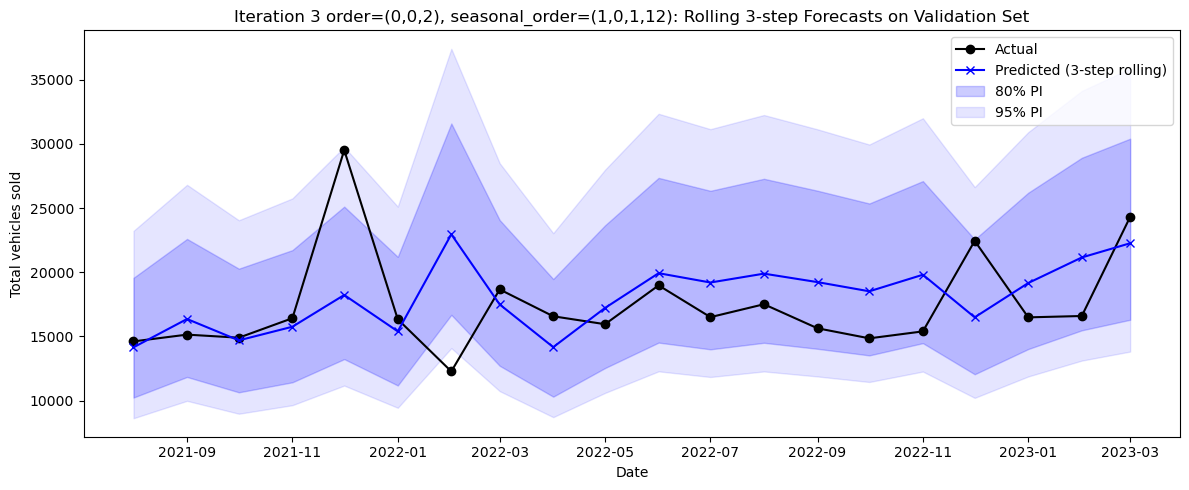

Validation RMSE (3-step rolling): 4359.91
Validation MAPE (3-step rolling): 18.31%
Last fitted SARIMA model AIC: 9.07
Last fitted SARIMA model BIC: 24.95


In [ ]:
warnings.filterwarnings("ignore", category=ValueWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# --- Walk-forward (rolling) validation for 3-step-ahead forecasts with prediction intervals ---
history = list(boxcox_all[target][:train_end])  # start with train set
val_bc = boxcox_all[target][train_end:val_end]  # validation set (BoxCox-transformed)
horizon = 3  # 3-step ahead
predictions_bc = []
conf_int_80 = []
conf_int_95 = []

for t in range(len(val_bc) - horizon + 1):
    # Fit model on all history up to t
    model = SARIMAX(
        history,
        order=(1, 0, 2),
        seasonal_order=(0, 0, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fitted_model = model.fit(disp=False)
    
    # Recursive 3-step forecast with intervals
    temp_history = history.copy()
    for step in range(horizon):
        idx = t + step
        res = fitted_model.get_forecast(steps=1)
        yhat = res.predicted_mean[0]
        ci_80 = res.conf_int(alpha=0.20)[0]
        ci_95 = res.conf_int(alpha=0.05)[0]
        temp_history.append(yhat)
    predictions_bc.append(yhat)  # Only keep the 3rd step prediction
    conf_int_80.append(ci_80)
    conf_int_95.append(ci_95)

    # Update history with actual for next rolling window
    history.append(val_bc[t])

# Inverse BoxCox transform
lam, shift = boxcox_lambdas_all[target]
def inv_boxcox(y, lam):
    if lam == 0:
        return np.exp(y)
    else:
        return np.power(lam * y + 1, 1/lam)

val_forecast_orig_rolling = inv_boxcox(np.array(predictions_bc), lam) - shift
actuals = y_val.values[horizon-1:]

# Inverse transform intervals
conf_int_80 = np.array(conf_int_80)
conf_int_95 = np.array(conf_int_95)
ci_80_lower = inv_boxcox(conf_int_80[:, 0], lam) - shift
ci_80_upper = inv_boxcox(conf_int_80[:, 1], lam) - shift
ci_95_lower = inv_boxcox(conf_int_95[:, 0], lam) - shift
ci_95_upper = inv_boxcox(conf_int_95[:, 1], lam) - shift

# Plot actual vs predicted (rolling 3-step) with intervals
plt.figure(figsize=(12, 5))
x_dates = df["Time Period (T)"][train_end+horizon-1:val_end]
plt.plot(x_dates, actuals, label='Actual', marker='o', color='black')
plt.plot(x_dates, val_forecast_orig_rolling, label='Predicted (3-step rolling)', marker='x', color='blue')
plt.fill_between(x_dates, ci_80_lower, ci_80_upper, color='blue', alpha=0.2, label='80% PI')
plt.fill_between(x_dates, ci_95_lower, ci_95_upper, color='blue', alpha=0.1, label='95% PI')
plt.title('Iteration 3 order=(0,0,2), seasonal_order=(1,0,1,12): Rolling 3-step Forecasts on Validation Set')
plt.xlabel('Date')
plt.ylabel('Total vehicles sold')
plt.legend()
plt.tight_layout()
plt.show()

# Calculate RMSE and MAPE for rolling 3-step
rmse_rolling = np.sqrt(mean_squared_error(actuals, val_forecast_orig_rolling))
mape_rolling = mean_absolute_percentage_error(actuals, val_forecast_orig_rolling)
print(f"Validation RMSE (3-step rolling): {rmse_rolling:.2f}")
print(f"Validation MAPE (3-step rolling): {mape_rolling:.2%}")

# Print AIC and BIC of last fitted model in rolling validation
print(f"Last fitted SARIMA model AIC: {fitted_model.aic:.2f}")
print(f"Last fitted SARIMA model BIC: {fitted_model.bic:.2f}")

#### 1. test...

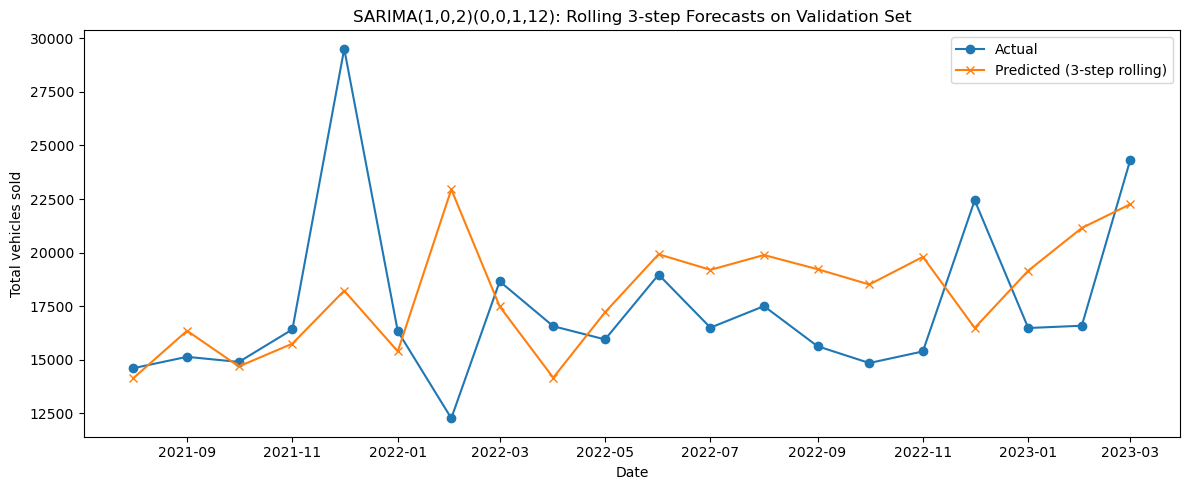

Validation RMSE (3-step rolling): 4359.91
Validation MAPE (3-step rolling): 18.31%
Last fitted SARIMA model AIC: 9.07
Last fitted SARIMA model BIC: 24.95


In [ ]:

warnings.filterwarnings("ignore", category=ValueWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# --- Walk-forward (rolling) validation for 3-step-ahead forecasts ---
history = list(boxcox_all[target][:train_end])  # start with train set
val_bc = boxcox_all[target][train_end:val_end]  # validation set (BoxCox-transformed)
horizon = 3  # 3-step ahead
predictions_bc = []

for t in range(len(val_bc) - horizon + 1):
    # Fit model on all history up to t
    model = SARIMAX(
        history,
        order=(1, 0, 2),
        seasonal_order=(0, 0, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fitted_model = model.fit(disp=False)
    
    # Recursive 3-step forecast
    temp_history = history.copy()
    for step in range(horizon):
        idx = t + step
        yhat = fitted_model.forecast(steps=1)[0]
        temp_history.append(yhat)
    predictions_bc.append(yhat)  # Only keep the 3rd step prediction

    # Update history with actual for next rolling window
    history.append(val_bc[t])

# Inverse BoxCox transform
lam, shift = boxcox_lambdas_all[target]
def inv_boxcox(y, lam):
    if lam == 0:
        return np.exp(y)
    else:
        return np.power(lam * y + 1, 1/lam)

val_forecast_orig_rolling = inv_boxcox(np.array(predictions_bc), lam) - shift
actuals = y_val.values[horizon-1:]

# Plot actual vs predicted (rolling 3-step)
plt.figure(figsize=(12, 5))
plt.plot(df["Time Period (T)"][train_end+horizon-1:val_end], actuals, label='Actual', marker='o')
plt.plot(df["Time Period (T)"][train_end+horizon-1:val_end], val_forecast_orig_rolling, label='Predicted (3-step rolling)', marker='x')
plt.title('SARIMA(1,0,2)(0,0,1,12): Rolling 3-step Forecasts on Validation Set')
plt.xlabel('Date')
plt.ylabel('Total vehicles sold')
plt.legend()
plt.tight_layout()
plt.show()

# Calculate RMSE and MAPE for rolling 3-step
rmse_rolling = np.sqrt(mean_squared_error(actuals, val_forecast_orig_rolling))
mape_rolling = mean_absolute_percentage_error(actuals, val_forecast_orig_rolling)
print(f"Validation RMSE (3-step rolling): {rmse_rolling:.2f}")
print(f"Validation MAPE (3-step rolling): {mape_rolling:.2%}")

# Print AIC and BIC of last fitted model in rolling validation
print(f"Last fitted SARIMA model AIC: {fitted_model.aic:.2f}")
print(f"Last fitted SARIMA model BIC: {fitted_model.bic:.2f}")

# 7. Dynamic Regression with Exogenous Variables

## 7.a Gasoline price 

check dit!

> Use a single combined model of all shortlisted lags, then assess it once on the validation set—avoiding separate in‐sample scans per exog.

3. Always Check Your Residuals
Every time you add an exog, re-run residual diagnostics on that SARIMAX fit:

ACF/PACF of residuals (no slow decay or significant spikes)

Ljung–Box test (no serial correlation)

Histogram/Q–Q plot (approximate normality)

If you see structure leaking through, your error model needs tweaking.

4. Overfitting & Multiple‐Testing
Scanning 1–6 lags and four exogs in isolation inflates the chance of finding spurious “wins.”

Action: once you’ve shortlisted plausible lags via CCF, fit one SARIMAX with all candidates together and compare its AIC/BIC to your baseline.

Use rolling-origin error metrics (RMSE, MAPE, MASE) rather than in-sample AIC alone.

### Lag Selection

Optimal lags sorted by AIC:
Lag: 6, AIC: 24.84, BIC: 42.94
Lag: 1, AIC: 29.46, BIC: 47.76
Lag: 5, AIC: 31.13, BIC: 49.27
Lag: 2, AIC: 31.71, BIC: 49.97
Lag: 4, AIC: 32.06, BIC: 50.24
Lag: 3, AIC: 33.12, BIC: 51.35

Optimal lags sorted by BIC:
Lag: 6, AIC: 24.84, BIC: 42.94
Lag: 1, AIC: 29.46, BIC: 47.76
Lag: 5, AIC: 31.13, BIC: 49.27
Lag: 2, AIC: 31.71, BIC: 49.97
Lag: 4, AIC: 32.06, BIC: 50.24
Lag: 3, AIC: 33.12, BIC: 51.35


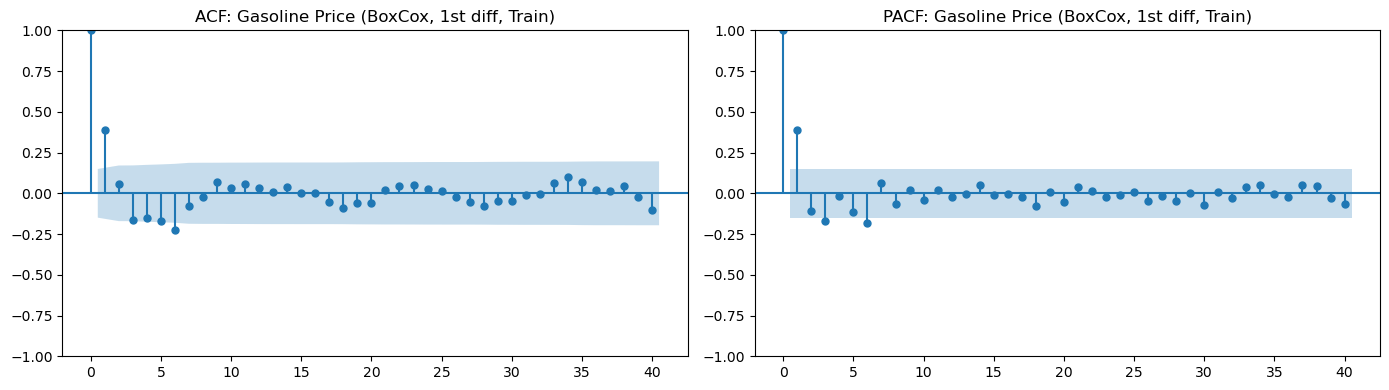

In [ ]:
warnings.filterwarnings("ignore", category=ValueWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
# Prepare exogenous variable: use BoxCox-transformed, 1st-differenced train split for 'Gasoline (Euro95) - Average price (F)'
exog_feature = diff_results['Gasoline (Euro95) - Average price (F)']
target_diff = diff_results[target]

# Try lags 1 to 6 for exogenous variable
max_lag = 6
aic_bic_results = []

for lag in range(1, max_lag + 1):
    # Lag exogenous variable (align with target_diff)
    exog_lagged = np.roll(exog_feature, lag)
    exog_lagged[:lag] = np.nan  # first 'lag' values are invalid
    valid_idx = ~np.isnan(exog_lagged)
    y_valid = target_diff[valid_idx]
    exog_valid = exog_lagged[valid_idx].reshape(-1, 1)
    
    # Fit SARIMAX with your specified model
    model = SARIMAX(
        y_valid,
        order=(1, 0, 2),
        seasonal_order=(0, 0, 1, 12),
        exog=exog_valid,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    res = model.fit(disp=False)
    aic_bic_results.append({
        'lag': lag,
        'AIC': res.aic,
        'BIC': res.bic
    })

# Sort by AIC and BIC
aic_sorted = sorted(aic_bic_results, key=lambda x: x['AIC'])
bic_sorted = sorted(aic_bic_results, key=lambda x: x['BIC'])

print("Optimal lags sorted by AIC:")
for r in aic_sorted:
    print(f"Lag: {r['lag']}, AIC: {r['AIC']:.2f}, BIC: {r['BIC']:.2f}")

print("\nOptimal lags sorted by BIC:")
for r in bic_sorted:
    print(f"Lag: {r['lag']}, AIC: {r['AIC']:.2f}, BIC: {r['BIC']:.2f}")

# Plot ACF and PACF for the BoxCox-transformed, 1st-differenced gasoline price (train split)
gas_bc_diff = diff_results['Gasoline (Euro95) - Average price (F)']

plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plot_acf(gas_bc_diff, ax=plt.gca(), lags=40)
plt.title('ACF: Gasoline Price (BoxCox, 1st diff, Train)')

plt.subplot(1, 2, 2)
plot_pacf(gas_bc_diff, ax=plt.gca(), lags=40, method='ywm')
plt.title('PACF: Gasoline Price (BoxCox, 1st diff, Train)')

plt.tight_layout()
plt.show()

Optimal lags sorted by AIC:
Lag: 6, AIC: 121.18, BIC: 127.39
Lag: 2, AIC: 121.89, BIC: 128.15
Lag: 5, AIC: 122.57, BIC: 128.79
Lag: 4, AIC: 123.32, BIC: 129.55
Lag: 3, AIC: 123.74, BIC: 129.99
Lag: 1, AIC: 125.88, BIC: 132.15

Optimal lags sorted by BIC:
Lag: 6, AIC: 121.18, BIC: 127.39
Lag: 2, AIC: 121.89, BIC: 128.15
Lag: 5, AIC: 122.57, BIC: 128.79
Lag: 4, AIC: 123.32, BIC: 129.55
Lag: 3, AIC: 123.74, BIC: 129.99
Lag: 1, AIC: 125.88, BIC: 132.15


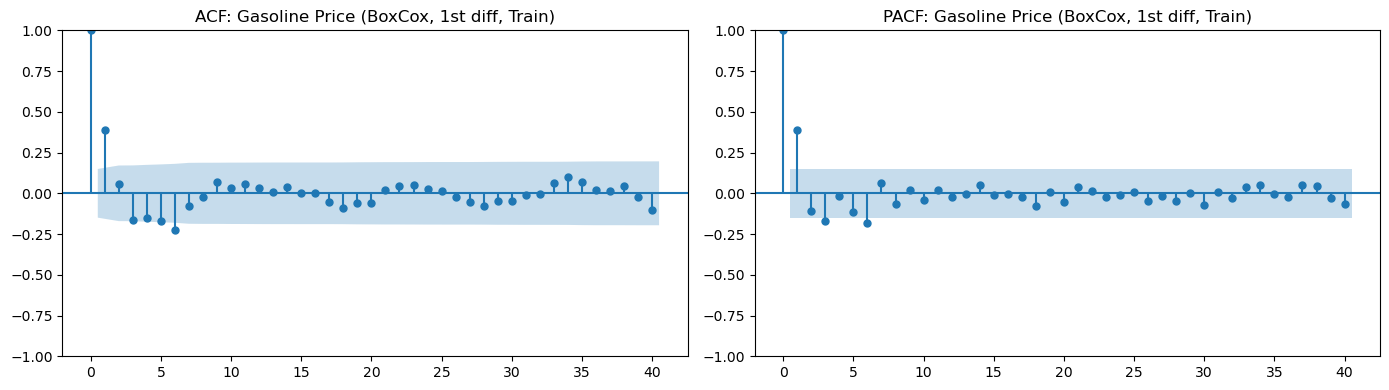

In [ ]:
warnings.filterwarnings("ignore", category=ValueWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
# Prepare exogenous variable: use BoxCox-transformed, 1st-differenced train split for 'Gasoline (Euro95) - Average price (F)'
exog_feature = diff_results['Gasoline (Euro95) - Average price (F)']
target_diff = diff_results[target]

# Try lags 1 to 6 for exogenous variable
max_lag = 6
aic_bic_results = []

for lag in range(1, max_lag + 1):
    # Lag exogenous variable (align with target_diff)
    exog_lagged = np.roll(exog_feature, lag)
    exog_lagged[:lag] = np.nan  # first 'lag' values are invalid
    valid_idx = ~np.isnan(exog_lagged)
    y_valid = target_diff[valid_idx]
    exog_valid = exog_lagged[valid_idx].reshape(-1, 1)
    
    # Fit SARIMAX (ARIMA(0,0,0) since already differenced, no AR/MA terms)
    model = sm.tsa.SARIMAX(
        y_valid,
        order=(0, 0, 0),
        exog=exog_valid,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    res = model.fit(disp=False)
    aic_bic_results.append({
        'lag': lag,
        'AIC': res.aic,
        'BIC': res.bic
    })

# Sort by AIC and BIC
aic_sorted = sorted(aic_bic_results, key=lambda x: x['AIC'])
bic_sorted = sorted(aic_bic_results, key=lambda x: x['BIC'])

print("Optimal lags sorted by AIC:")
for r in aic_sorted:
    print(f"Lag: {r['lag']}, AIC: {r['AIC']:.2f}, BIC: {r['BIC']:.2f}")

print("\nOptimal lags sorted by BIC:")
for r in bic_sorted:
    print(f"Lag: {r['lag']}, AIC: {r['AIC']:.2f}, BIC: {r['BIC']:.2f}")

# Plot ACF and PACF for the BoxCox-transformed, 1st-differenced gasoline price (train split)
gas_bc_diff = diff_results['Gasoline (Euro95) - Average price (F)']

plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plot_acf(gas_bc_diff, ax=plt.gca(), lags=40)
plt.title('ACF: Gasoline Price (BoxCox, 1st diff, Train)')

plt.subplot(1, 2, 2)
plot_pacf(gas_bc_diff, ax=plt.gca(), lags=40, method='ywm')
plt.title('PACF: Gasoline Price (BoxCox, 1st diff, Train)')

plt.tight_layout()
plt.show()

### Fit Sarimax and diagnose 

Rolling 3-step RMSE: 17864.61
Rolling 3-step MAPE: 99.99%


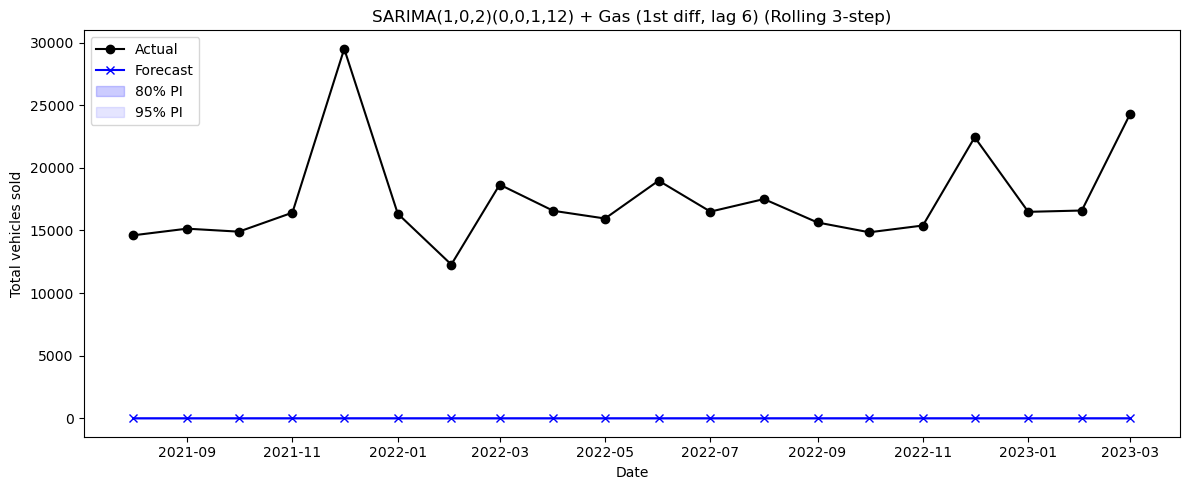

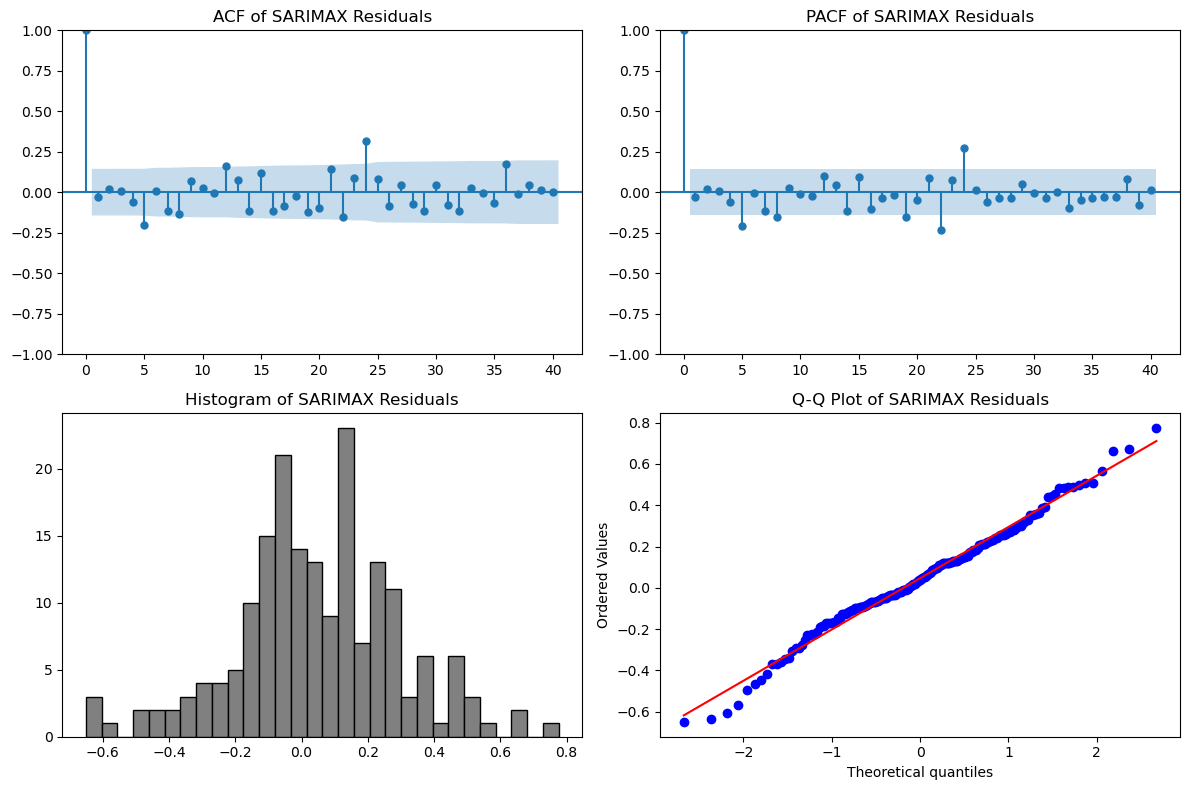

Ljung-Box test p-values (no autocorrelation if > 0.05):
      lb_stat  lb_pvalue
10  16.032781   0.098698
20  37.396046   0.010486
30  77.732474   0.000004


In [ ]:
warnings.filterwarnings("ignore", category=ValueWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# ─── 1. Prepare data ───────────────────────────────────────────────────────────
gas_bc_raw = boxcox_all['Gasoline (Euro95) - Average price (F)']
gas_bc = np.diff(gas_bc_raw)  # FIRST DIFFERENCE
target_bc_raw = boxcox_all[target]
target_bc = np.diff(target_bc_raw)  # FIRST DIFFERENCE

# Adjust indices for differencing
history_y   = list(target_bc[:train_end-1])         # align with diffed gas_bc and target
history_gas = list(gas_bc[:train_end-1])

val_y   = target_bc[train_end-1:val_end-1]
val_gas = gas_bc[train_end-1:val_end-1]

horizon = 3     # 3-step ahead
lag     = 6     # chosen exogenous lag

predictions_bc = []
conf_int_80    = []
conf_int_95    = []

# ─── 2. Rolling loop ────────────────────────────────────────────────────────────
for t in range(len(val_y) - horizon + 1):
    # 2a) Build a DataFrame of history + lagged gas
    df_hist = pd.DataFrame({
        'y'  : history_y,
        'gas': history_gas
    })
    df_hist['gas_lag6'] = df_hist['gas'].shift(lag)
    df_hist = df_hist.dropna()

    y_hist    = df_hist['y']
    exog_hist = df_hist['gas_lag6'].values.reshape(-1, 1)

    # 2b) Fit SARIMAX on history
    model = SARIMAX(
        y_hist,
        exog             = exog_hist,
        order            = (1, 0, 2),
        seasonal_order   = (0, 0, 1, 12),
        enforce_stationarity   = False,
        enforce_invertibility   = False
    )
    fitted = model.fit(disp=False)

    # 2c) Construct future exogenous inputs **only** from history_gas
    gas_future_lags = [
        history_gas[-lag + (i+1)]
        for i in range(horizon)
    ]
    exog_future = np.array(gas_future_lags).reshape(horizon, 1)

    # 2d) Multi-step forecast with exog
    fc = fitted.get_forecast(steps=horizon, exog=exog_future)

    # pull out the 3rd step’s point forecast + intervals
    yhat      = fc.predicted_mean.iloc[-1]
    ci80, ci80_u = fc.conf_int(alpha=0.20).iloc[-1].values
    ci95, ci95_u = fc.conf_int(alpha=0.05).iloc[-1].values

    predictions_bc.append(yhat)
    conf_int_80.append((ci80, ci80_u))
    conf_int_95.append((ci95, ci95_u))

    # 2e) Now that we’ve “observed” time t, append the actuals to history
    history_y.append(val_y[t])
    history_gas.append(val_gas[t])

# ─── 3. Invert Box–Cox & compute metrics ────────────────────────────────────────
lam, shift = boxcox_lambdas_all[target]
def inv_boxcox(y, lam):
    return np.exp(y) if lam == 0 else np.power(lam * y + 1, 1/lam)

pred_bc = np.array(predictions_bc)
pred_orig  = inv_boxcox(pred_bc, lam) - shift
actuals    = y_val.values[horizon-1:]  # Note: y_val is not differenced, so this is for reference

# intervals
ci80_arr = np.array(conf_int_80)
ci95_arr = np.array(conf_int_95)

ci80_lower = inv_boxcox(ci80_arr[:,0], lam) - shift
ci80_upper = inv_boxcox(ci80_arr[:,1], lam) - shift
ci95_lower = inv_boxcox(ci95_arr[:,0], lam) - shift
ci95_upper = inv_boxcox(ci95_arr[:,1], lam) - shift

# metrics
rmse = np.sqrt(mean_squared_error(actuals, pred_orig))
mape = mean_absolute_percentage_error(actuals, pred_orig)

print(f"Rolling 3-step RMSE: {rmse:.2f}")
print(f"Rolling 3-step MAPE: {mape:.2%}")

# ─── 4. Plot results ────────────────────────────────────────────────────────────
x_dates = df["Time Period (T)"][train_end+horizon-1:val_end]

plt.figure(figsize=(12,5))
plt.plot(x_dates, actuals, marker='o', color='black', label='Actual')
plt.plot(x_dates, pred_orig, marker='x', color='blue', label='Forecast')
plt.fill_between(x_dates, ci80_lower, ci80_upper, color='blue', alpha=0.2, label='80% PI')
plt.fill_between(x_dates, ci95_lower, ci95_upper, color='blue', alpha=0.1, label='95% PI')
plt.title('SARIMA(1,0,2)(0,0,1,12) + Gas (1st diff, lag 6) (Rolling 3-step)')
plt.xlabel('Date')
plt.ylabel('Total vehicles sold')
plt.legend()
plt.tight_layout()
plt.show()

# ─── 5. Residual diagnostics ────────────────────────────────────────────────────
residuals = fitted.resid

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# ACF plot
plot_acf(residuals, ax=axes[0, 0], lags=40)
axes[0, 0].set_title("ACF of SARIMAX Residuals")

# PACF plot
plot_pacf(residuals, ax=axes[0, 1], lags=40, method='ywm')
axes[0, 1].set_title("PACF of SARIMAX Residuals")

# Histogram
axes[1, 0].hist(residuals, bins=30, color='gray', edgecolor='black')
axes[1, 0].set_title("Histogram of SARIMAX Residuals")

# Q-Q plot
stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title("Q-Q Plot of SARIMAX Residuals")

plt.tight_layout()
plt.show()

# Ljung-Box test for autocorrelation (white noise)
lb_test = acorr_ljungbox(residuals, lags=[10, 20, 30], return_df=True)
print("Ljung-Box test p-values (no autocorrelation if > 0.05):")
print(lb_test[['lb_stat', 'lb_pvalue']])

In [ ]:
#__________Only first diff exog 

# warnings.filterwarnings("ignore", category=ValueWarning)
# warnings.filterwarnings("ignore", category=ConvergenceWarning)
# warnings.filterwarnings("ignore", category=FutureWarning)

# # ─── 1. Prepare data ───────────────────────────────────────────────────────────
# gas_bc_raw = boxcox_all['Gasoline (Euro95) - Average price (F)']
# gas_bc = np.diff(gas_bc_raw)  # FIRST DIFFERENCE
# target_bc = boxcox_all[target]

# # Adjust indices for differencing
# history_y   = list(target_bc[1:train_end])         # align with diffed gas_bc
# history_gas = list(gas_bc[:train_end-1])

# val_y   = target_bc[train_end:val_end]
# val_gas = gas_bc[train_end-1:val_end-1]

# horizon = 3     # 3-step ahead
# lag     = 6     # chosen exogenous lag

# predictions_bc = []
# conf_int_80    = []
# conf_int_95    = []

# # ─── 2. Rolling loop ────────────────────────────────────────────────────────────
# for t in range(len(val_y) - horizon + 1):
#     # 2a) Build a DataFrame of history + lagged gas
#     df_hist = pd.DataFrame({
#         'y'  : history_y,
#         'gas': history_gas
#     })
#     df_hist['gas_lag6'] = df_hist['gas'].shift(lag)
#     df_hist = df_hist.dropna()

#     y_hist    = df_hist['y']
#     exog_hist = df_hist['gas_lag6'].values.reshape(-1, 1)

#     # 2b) Fit SARIMAX on history
#     model = SARIMAX(
#         y_hist,
#         exog             = exog_hist,
#         order            = (1, 0, 2),
#         seasonal_order   = (0, 0, 1, 12),
#         enforce_stationarity   = False,
#         enforce_invertibility   = False
#     )
#     fitted = model.fit(disp=False)

#     # 2c) Construct future exogenous inputs **only** from history_gas
#     gas_future_lags = [
#         history_gas[-lag + (i+1)]
#         for i in range(horizon)
#     ]
#     exog_future = np.array(gas_future_lags).reshape(horizon, 1)

#     # 2d) Multi-step forecast with exog
#     fc = fitted.get_forecast(steps=horizon, exog=exog_future)

#     # pull out the 3rd step’s point forecast + intervals
#     yhat      = fc.predicted_mean.iloc[-1]
#     ci80, ci80_u = fc.conf_int(alpha=0.20).iloc[-1].values
#     ci95, ci95_u = fc.conf_int(alpha=0.05).iloc[-1].values

#     predictions_bc.append(yhat)
#     conf_int_80.append((ci80, ci80_u))
#     conf_int_95.append((ci95, ci95_u))

#     # 2e) Now that we’ve “observed” time t, append the actuals to history
#     history_y.append(val_y[t])
#     history_gas.append(val_gas[t])

# # ─── 3. Invert Box–Cox & compute metrics ────────────────────────────────────────
# lam, shift = boxcox_lambdas_all[target]
# def inv_boxcox(y, lam):
#     return np.exp(y) if lam == 0 else np.power(lam * y + 1, 1/lam)

# pred_bc = np.array(predictions_bc)
# pred_orig  = inv_boxcox(pred_bc, lam) - shift
# actuals    = y_val.values[horizon-1:]

# # intervals
# ci80_arr = np.array(conf_int_80)
# ci95_arr = np.array(conf_int_95)

# ci80_lower = inv_boxcox(ci80_arr[:,0], lam) - shift
# ci80_upper = inv_boxcox(ci80_arr[:,1], lam) - shift
# ci95_lower = inv_boxcox(ci95_arr[:,0], lam) - shift
# ci95_upper = inv_boxcox(ci95_arr[:,1], lam) - shift

# # metrics
# rmse = np.sqrt(mean_squared_error(actuals, pred_orig))
# mape = mean_absolute_percentage_error(actuals, pred_orig)

# print(f"Rolling 3-step RMSE: {rmse:.2f}")
# print(f"Rolling 3-step MAPE: {mape:.2%}")

# # ─── 4. Plot results ────────────────────────────────────────────────────────────
# x_dates = df["Time Period (T)"][train_end+horizon-1:val_end]

# plt.figure(figsize=(12,5))
# plt.plot(x_dates, actuals, marker='o', color='black', label='Actual')
# plt.plot(x_dates, pred_orig, marker='x', color='blue', label='Forecast')
# plt.fill_between(x_dates, ci80_lower, ci80_upper, color='blue', alpha=0.2, label='80% PI')
# plt.fill_between(x_dates, ci95_lower, ci95_upper, color='blue', alpha=0.1, label='95% PI')
# plt.title('SARIMA(1,0,2)(0,0,1,12) + Gas (1st diff, lag 6) (Rolling 3-step)')
# plt.xlabel('Date')
# plt.ylabel('Total vehicles sold')
# plt.legend()
# plt.tight_layout()
# plt.show()

# # ─── 5. Residual diagnostics ────────────────────────────────────────────────────
# residuals = fitted.resid

# fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# # ACF plot
# plot_acf(residuals, ax=axes[0, 0], lags=40)
# axes[0, 0].set_title("ACF of SARIMAX Residuals")

# # PACF plot
# plot_pacf(residuals, ax=axes[0, 1], lags=40, method='ywm')
# axes[0, 1].set_title("PACF of SARIMAX Residuals")

# # Histogram
# axes[1, 0].hist(residuals, bins=30, color='gray', edgecolor='black')
# axes[1, 0].set_title("Histogram of SARIMAX Residuals")

# # Q-Q plot
# stats.probplot(residuals, dist="norm", plot=axes[1, 1])
# axes[1, 1].set_title("Q-Q Plot of SARIMAX Residuals")

# plt.tight_layout()
# plt.show()

# # Ljung-Box test for autocorrelation (white noise)
# lb_test = acorr_ljungbox(residuals, lags=[10, 20, 30], return_df=True)
# print("Ljung-Box test p-values (no autocorrelation if > 0.05):")
# print(lb_test[['lb_stat', 'lb_pvalue']])


Rolling 3-step RMSE: 3797.68
Rolling 3-step MAPE: 15.54%


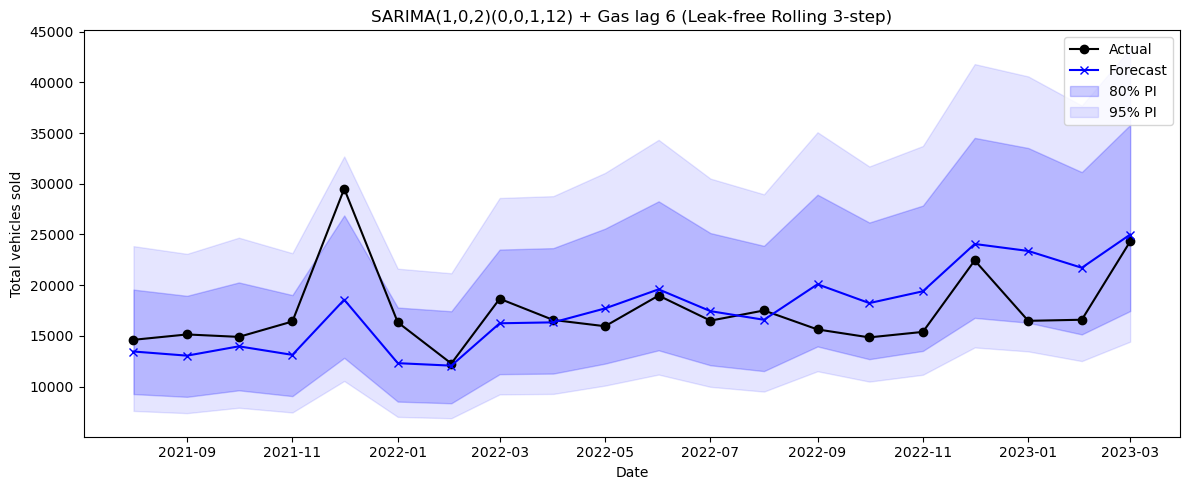

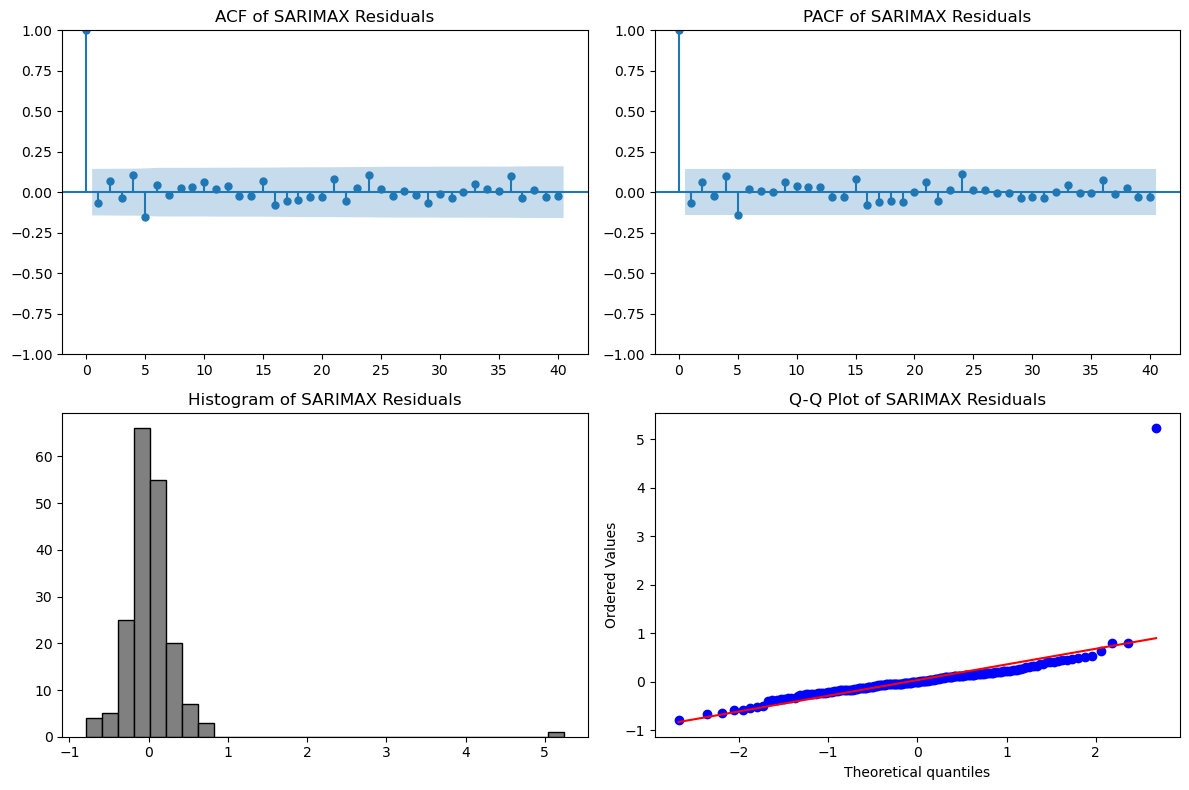

Ljung-Box test p-values (no autocorrelation if > 0.05):
      lb_stat  lb_pvalue
10  10.171962   0.425538
20  14.608394   0.798360
30  20.415238   0.905279


In [ ]:
# warnings.filterwarnings("ignore", category=ValueWarning)
# warnings.filterwarnings("ignore", category=ConvergenceWarning)
# warnings.filterwarnings("ignore", category=FutureWarning)

# # ─── 1. Prepare data ───────────────────────────────────────────────────────────
# gas_bc    = boxcox_all['Gasoline (Euro95) - Average price (F)']
# target_bc = boxcox_all[target]

# # history = train up to but **not including** the validation window
# history_y   = list(target_bc[:train_end])
# history_gas = list(gas_bc[:train_end])

# # hold-out slices
# val_y   = target_bc[train_end:val_end]
# val_gas = gas_bc[   train_end:val_end]

# horizon = 3     # 3-step ahead
# lag     = 6     # chosen exogenous lag

# predictions_bc = []
# conf_int_80    = []
# conf_int_95    = []

# # ─── 2. Rolling loop ────────────────────────────────────────────────────────────
# for t in range(len(val_y) - horizon + 1):
#     # 2a) Build a DataFrame of history + lagged gas
#     df_hist = pd.DataFrame({
#         'y'  : history_y,
#         'gas': history_gas
#     })
#     df_hist['gas_lag6'] = df_hist['gas'].shift(lag)
#     df_hist = df_hist.dropna()

#     y_hist    = df_hist['y']
#     exog_hist = df_hist['gas_lag6'].values.reshape(-1, 1)

#     # 2b) Fit SARIMAX on history
#     model = SARIMAX(
#         y_hist,
#         exog             = exog_hist,
#         order            = (1, 0, 2),
#         seasonal_order   = (0, 0, 1, 12),
#         enforce_stationarity   = False,
#         enforce_invertibility   = False
#     )
#     fitted = model.fit(disp=False)

#     # 2c) Construct future exogenous inputs **only** from history_gas
#     #     for each of the next `horizon` steps
#     gas_future_lags = [
#         history_gas[-lag + (i+1)]
#         for i in range(horizon)
#     ]
#     exog_future = np.array(gas_future_lags).reshape(horizon, 1)

#     # 2d) Multi-step forecast with exog
#     fc = fitted.get_forecast(steps=horizon, exog=exog_future)

#     # pull out the 3rd step’s point forecast + intervals
#     yhat      = fc.predicted_mean.iloc[-1]
#     ci80, ci80_u = fc.conf_int(alpha=0.20).iloc[-1].values
#     ci95, ci95_u = fc.conf_int(alpha=0.05).iloc[-1].values

#     predictions_bc.append(yhat)
#     conf_int_80.append((ci80, ci80_u))
#     conf_int_95.append((ci95, ci95_u))

#     # 2e) Now that we’ve “observed” time t, append the actuals to history
#     history_y.append(val_y[t])
#     history_gas.append(val_gas[t])

# # ─── 3. Invert Box–Cox & compute metrics ────────────────────────────────────────
# lam, shift = boxcox_lambdas_all[target]
# def inv_boxcox(y, lam):
#     return np.exp(y) if lam == 0 else np.power(lam * y + 1, 1/lam)

# pred_bc = np.array(predictions_bc)
# pred_orig  = inv_boxcox(pred_bc, lam) - shift
# actuals    = y_val.values[horizon-1:]

# # intervals
# ci80_arr = np.array(conf_int_80)
# ci95_arr = np.array(conf_int_95)

# ci80_lower = inv_boxcox(ci80_arr[:,0], lam) - shift
# ci80_upper = inv_boxcox(ci80_arr[:,1], lam) - shift
# ci95_lower = inv_boxcox(ci95_arr[:,0], lam) - shift
# ci95_upper = inv_boxcox(ci95_arr[:,1], lam) - shift

# # metrics
# rmse = np.sqrt(mean_squared_error(actuals, pred_orig))
# mape = mean_absolute_percentage_error(actuals, pred_orig)

# print(f"Rolling 3-step RMSE: {rmse:.2f}")
# print(f"Rolling 3-step MAPE: {mape:.2%}")

# # ─── 4. Plot results ────────────────────────────────────────────────────────────
# x_dates = df["Time Period (T)"][train_end+horizon-1:val_end]

# plt.figure(figsize=(12,5))
# plt.plot(   x_dates, actuals,    marker='o', color='black', label='Actual')
# plt.plot(   x_dates, pred_orig, marker='x', color='blue',  label='Forecast')
# plt.fill_between(x_dates, ci80_lower, ci80_upper, color='blue', alpha=0.2, label='80% PI')
# plt.fill_between(x_dates, ci95_lower, ci95_upper, color='blue', alpha=0.1, label='95% PI')
# plt.title('SARIMA(1,0,2)(0,0,1,12) + Gas lag 6 (Leak-free Rolling 3-step)')
# plt.xlabel('Date')
# plt.ylabel('Total vehicles sold')
# plt.legend()
# plt.tight_layout()


# # ─── 5. Residual diagnostics 
# # Get residuals from the last fitted SARIMAX model in the rolling loop
# residuals = fitted.resid

# fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# # ACF plot
# plot_acf(residuals, ax=axes[0, 0], lags=40)
# axes[0, 0].set_title("ACF of SARIMAX Residuals")

# # PACF plot
# plot_pacf(residuals, ax=axes[0, 1], lags=40, method='ywm')
# axes[0, 1].set_title("PACF of SARIMAX Residuals")

# # Histogram
# axes[1, 0].hist(residuals, bins=30, color='gray', edgecolor='black')
# axes[1, 0].set_title("Histogram of SARIMAX Residuals")

# # Q-Q plot
# stats.probplot(residuals, dist="norm", plot=axes[1, 1])
# axes[1, 1].set_title("Q-Q Plot of SARIMAX Residuals")

# plt.tight_layout()
# plt.show()

# # Ljung-Box test for autocorrelation (white noise)
# lb_test = acorr_ljungbox(residuals, lags=[10, 20, 30], return_df=True)
# print("Ljung-Box test p-values (no autocorrelation if > 0.05):")
# print(lb_test[['lb_stat', 'lb_pvalue']])


## 7b Company car tax rate (%)

### Lag Selection

Optimal lags sorted by AIC:
Lag: 3, AIC: 121.97, BIC: 128.22
Lag: 6, AIC: 122.87, BIC: 129.08
Lag: 4, AIC: 123.14, BIC: 129.37
Lag: 5, AIC: 123.54, BIC: 129.77
Lag: 2, AIC: 124.15, BIC: 130.41
Lag: 1, AIC: 127.14, BIC: 133.42

Optimal lags sorted by BIC:
Lag: 3, AIC: 121.97, BIC: 128.22
Lag: 6, AIC: 122.87, BIC: 129.08
Lag: 4, AIC: 123.14, BIC: 129.37
Lag: 5, AIC: 123.54, BIC: 129.77
Lag: 2, AIC: 124.15, BIC: 130.41
Lag: 1, AIC: 127.14, BIC: 133.42


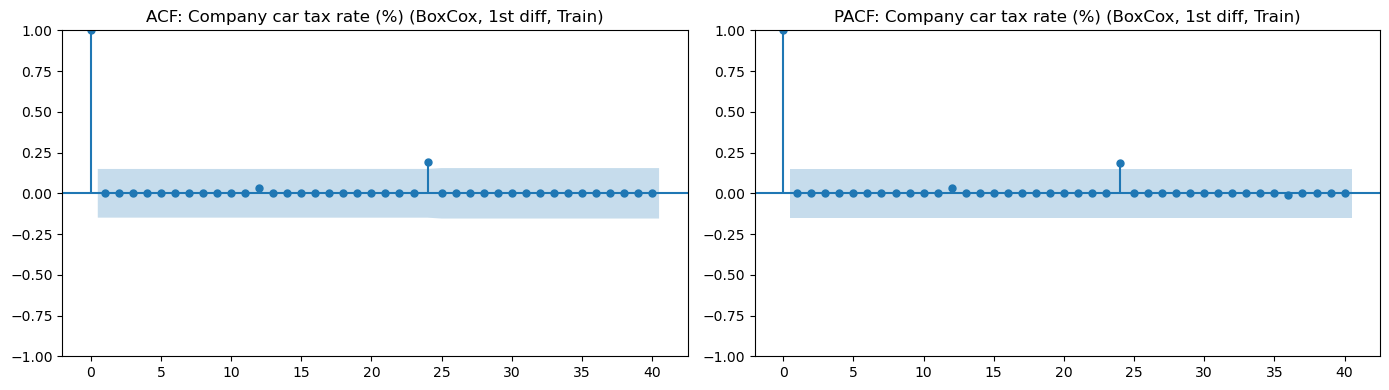

In [ ]:

# Prepare exogenous variable: use BoxCox-transformed, 1st-differenced train split for 'Company car tax rate (%)'
exog_feature = diff_results['Company car tax rate (%)']
target_diff = diff_results[target]

# Try lags 1 to 6 for exogenous variable
max_lag = 6
aic_bic_results = []

for lag in range(1, max_lag + 1):
    # Lag exogenous variable (align with target_diff)
    exog_lagged = np.roll(exog_feature, lag)
    exog_lagged[:lag] = np.nan  # first 'lag' values are invalid
    valid_idx = ~np.isnan(exog_lagged)
    y_valid = target_diff[valid_idx]
    exog_valid = exog_lagged[valid_idx].reshape(-1, 1)
    
    # Fit SARIMAX (ARIMA(0,0,0) since already differenced, no AR/MA terms)
    model = sm.tsa.SARIMAX(
        y_valid,
        order=(0, 0, 0),
        exog=exog_valid,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    res = model.fit(disp=False)
    aic_bic_results.append({
        'lag': lag,
        'AIC': res.aic,
        'BIC': res.bic
    })

# Sort by AIC and BIC
aic_sorted = sorted(aic_bic_results, key=lambda x: x['AIC'])
bic_sorted = sorted(aic_bic_results, key=lambda x: x['BIC'])

print("Optimal lags sorted by AIC:")
for r in aic_sorted:
    print(f"Lag: {r['lag']}, AIC: {r['AIC']:.2f}, BIC: {r['BIC']:.2f}")

print("\nOptimal lags sorted by BIC:")
for r in bic_sorted:
    print(f"Lag: {r['lag']}, AIC: {r['AIC']:.2f}, BIC: {r['BIC']:.2f}")

    # Plot ACF and PACF for the BoxCox-transformed, 1st-differenced Company car tax rate (train split)
car_tax_bc_diff = exog_feature

plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plot_acf(car_tax_bc_diff, ax=plt.gca(), lags=40)
plt.title('ACF: Company car tax rate (%) (BoxCox, 1st diff, Train)')

plt.subplot(1, 2, 2)
plot_pacf(car_tax_bc_diff, ax=plt.gca(), lags=40, method='ywm')
plt.title('PACF: Company car tax rate (%) (BoxCox, 1st diff, Train)')

plt.tight_layout()
plt.show()

### Fit Sarimax and diagnose 

Rolling 3-step RMSE: 3734.08
Rolling 3-step MAPE: 18.90%


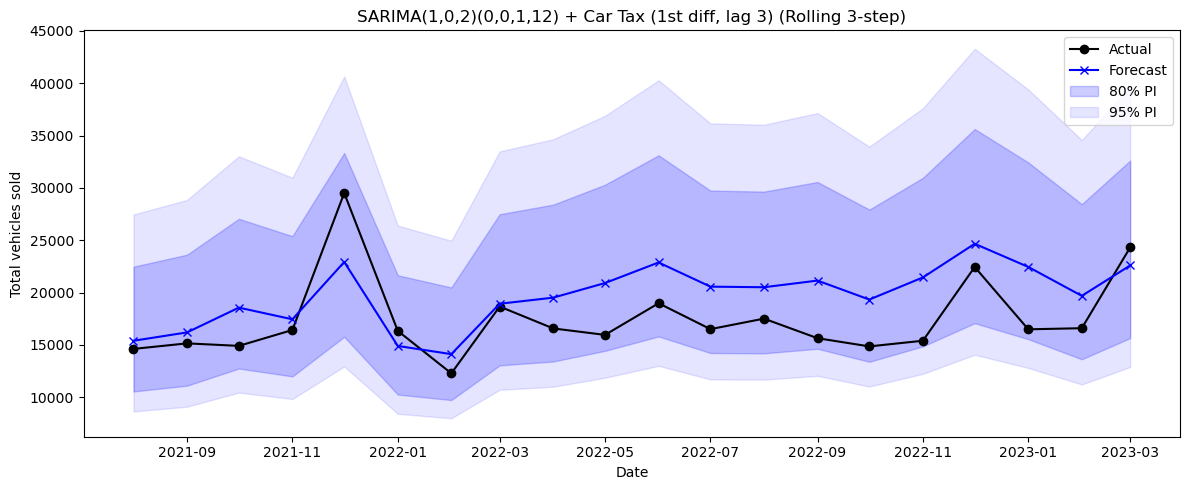

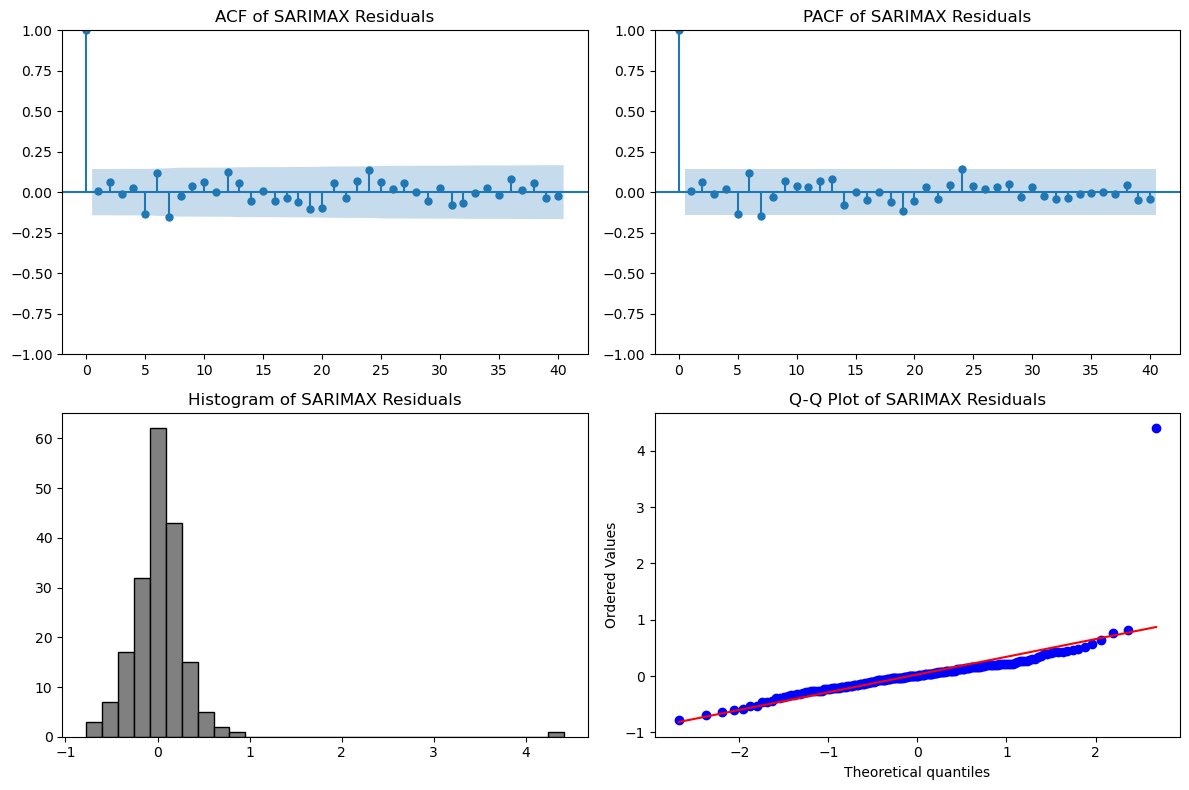

Ljung-Box test p-values (no autocorrelation if > 0.05):
      lb_stat  lb_pvalue
10  12.800826   0.235022
20  23.379647   0.270540
30  32.180506   0.359180


In [ ]:
warnings.filterwarnings("ignore", category=ValueWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# ─── 1. Prepare data ───────────────────────────────────────────────────────────
car_tax_bc_raw = boxcox_all['Company car tax rate (%)']
car_tax_bc = np.diff(car_tax_bc_raw)  # FIRST DIFFERENCE
target_bc  = boxcox_all[target]

# Adjust indices for differencing
history_y   = list(target_bc[1:train_end])         # align with diffed car_tax_bc
history_tax = list(car_tax_bc[:train_end-1])

val_y   = target_bc[train_end:val_end]
val_tax = car_tax_bc[train_end-1:val_end-1]

horizon = 3
lag     = 3  # chosen exogenous lag

predictions_bc = []
conf_int_80    = []
conf_int_95    = []

# ─── 2. Rolling loop ────────────────────────────────────────────────────────────
for t in range(len(val_y) - horizon + 1):
    # 2a) Build a DataFrame of history + lagged car tax
    df_hist = pd.DataFrame({
        'y': history_y,
        'tax': history_tax
    })
    df_hist['tax_lag3'] = df_hist['tax'].shift(lag)
    df_hist = df_hist.dropna()

    y_hist    = df_hist['y']
    exog_hist = df_hist['tax_lag3'].values.reshape(-1, 1)

    # 2b) Fit SARIMAX on history
    model = SARIMAX(
        y_hist,
        exog=exog_hist,
        order=(1, 0, 2),
        seasonal_order=(0, 0, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fitted = model.fit(disp=False)

    # 2c) Construct future exogenous inputs **only** from history_tax
    tax_future_lags = [
        history_tax[-lag + (i+1)]
        for i in range(horizon)
    ]
    exog_future = np.array(tax_future_lags).reshape(horizon, 1)

    # 2d) Multi-step forecast with exog
    fc = fitted.get_forecast(steps=horizon, exog=exog_future)

    # pull out the 3rd step’s point forecast + intervals
    yhat      = fc.predicted_mean.iloc[-1]
    ci80, ci80_u = fc.conf_int(alpha=0.20).iloc[-1].values
    ci95, ci95_u = fc.conf_int(alpha=0.05).iloc[-1].values

    predictions_bc.append(yhat)
    conf_int_80.append((ci80, ci80_u))
    conf_int_95.append((ci95, ci95_u))

    # 2e) Now that we’ve “observed” time t, append the actuals to history
    history_y.append(val_y[t])
    history_tax.append(val_tax[t])

# ─── 3. Invert Box–Cox & compute metrics ────────────────────────────────────────
lam, shift = boxcox_lambdas_all[target]
def inv_boxcox(y, lam):
    return np.exp(y) if lam == 0 else np.power(lam * y + 1, 1/lam)

pred_bc = np.array(predictions_bc)
pred_orig  = inv_boxcox(pred_bc, lam) - shift
actuals    = y_val.values[horizon-1:]

# intervals
ci80_arr = np.array(conf_int_80)
ci95_arr = np.array(conf_int_95)

ci80_lower = inv_boxcox(ci80_arr[:,0], lam) - shift
ci80_upper = inv_boxcox(ci80_arr[:,1], lam) - shift
ci95_lower = inv_boxcox(ci95_arr[:,0], lam) - shift
ci95_upper = inv_boxcox(ci95_arr[:,1], lam) - shift

# metrics
rmse = np.sqrt(mean_squared_error(actuals, pred_orig))
mape = mean_absolute_percentage_error(actuals, pred_orig)

print(f"Rolling 3-step RMSE: {rmse:.2f}")
print(f"Rolling 3-step MAPE: {mape:.2%}")

# ─── 4. Plot results ────────────────────────────────────────────────────────────
x_dates = df["Time Period (T)"][train_end+horizon-1:val_end]

plt.figure(figsize=(12,5))
plt.plot(x_dates, actuals, marker='o', color='black', label='Actual')
plt.plot(x_dates, pred_orig, marker='x', color='blue', label='Forecast')
plt.fill_between(x_dates, ci80_lower, ci80_upper, color='blue', alpha=0.2, label='80% PI')
plt.fill_between(x_dates, ci95_lower, ci95_upper, color='blue', alpha=0.1, label='95% PI')
plt.title('SARIMA(1,0,2)(0,0,1,12) + Car Tax (1st diff, lag 3) (Rolling 3-step)')
plt.xlabel('Date')
plt.ylabel('Total vehicles sold')
plt.legend()
plt.tight_layout()
plt.show()

# ─── 5. Residual diagnostics ────────────────────────────────────────────────────

# Get residuals from the last fitted SARIMAX model in the rolling loop
residuals = fitted.resid

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# ACF plot
plot_acf(residuals, ax=axes[0, 0], lags=40)
axes[0, 0].set_title("ACF of SARIMAX Residuals")

# PACF plot
plot_pacf(residuals, ax=axes[0, 1], lags=40, method='ywm')
axes[0, 1].set_title("PACF of SARIMAX Residuals")

# Histogram
axes[1, 0].hist(residuals, bins=30, color='gray', edgecolor='black')
axes[1, 0].set_title("Histogram of SARIMAX Residuals")

# Q-Q plot
stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title("Q-Q Plot of SARIMAX Residuals")

plt.tight_layout()
plt.show()

# Ljung-Box test for autocorrelation (white noise)
lb_test = acorr_ljungbox(residuals, lags=[10, 20, 30], return_df=True)
print("Ljung-Box test p-values (no autocorrelation if > 0.05):")
print(lb_test[['lb_stat', 'lb_pvalue']])

Rolling 3-step RMSE: 3756.22
Rolling 3-step MAPE: 19.13%


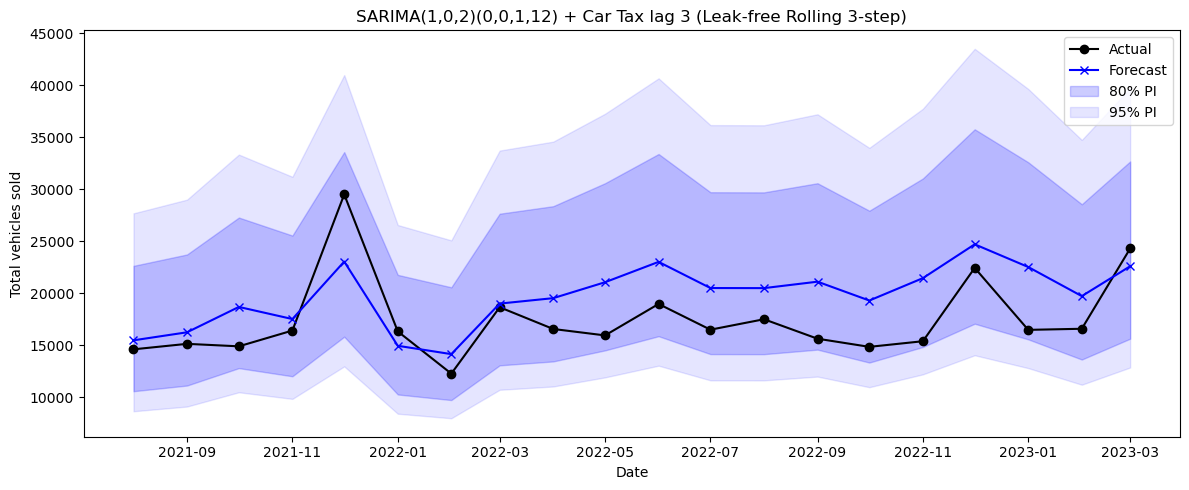

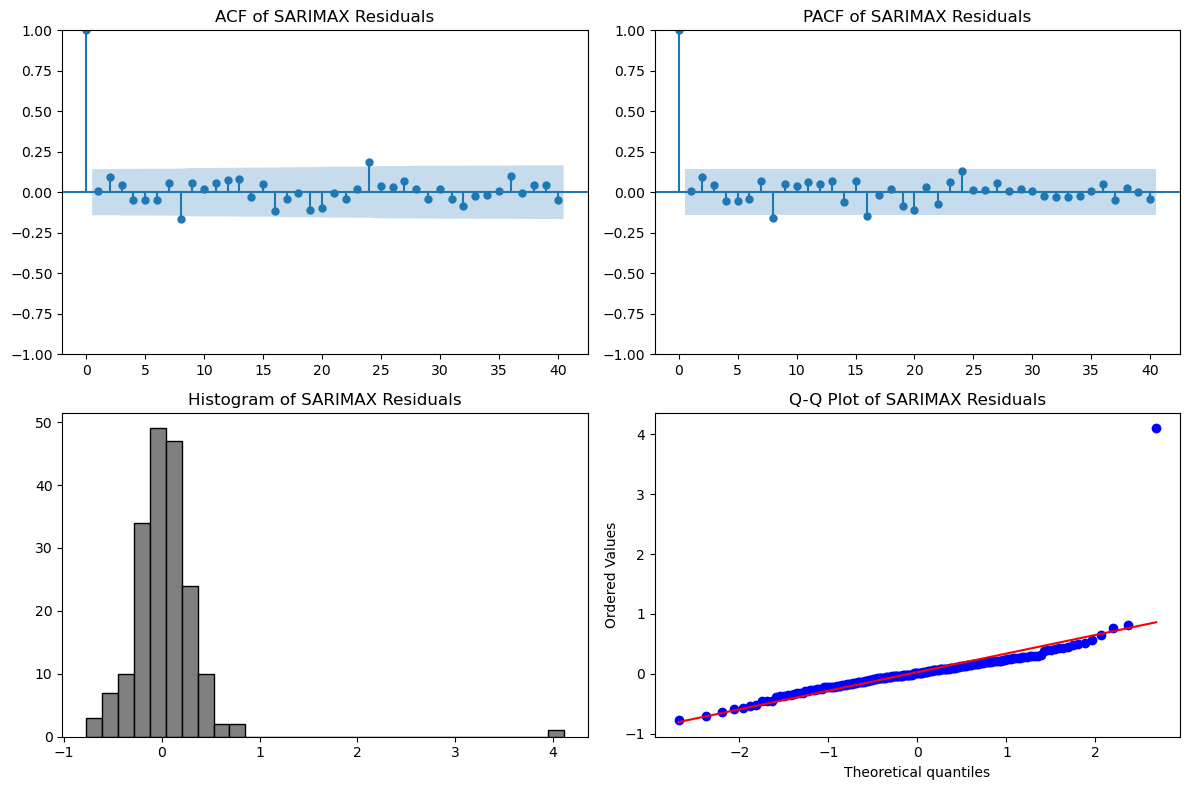

Ljung-Box test p-values (no autocorrelation if > 0.05):
      lb_stat  lb_pvalue
10  10.348455   0.410472
20  22.155801   0.332117
30  32.289264   0.354198


In [ ]:
# warnings.filterwarnings("ignore", category=ValueWarning)
# warnings.filterwarnings("ignore", category=ConvergenceWarning)
# warnings.filterwarnings("ignore", category=FutureWarning)

# # ─── 1. Prepare data ───────────────────────────────────────────────────────────
# car_tax_bc = boxcox_all['Company car tax rate (%)']
# target_bc  = boxcox_all[target]

# history_y   = list(target_bc[:train_end])
# history_tax = list(car_tax_bc[:train_end])

# val_y   = target_bc[train_end:val_end]
# val_tax = car_tax_bc[train_end:val_end]

# horizon = 3
# lag     = 3  # chosen exogenous lag

# predictions_bc = []
# conf_int_80    = []
# conf_int_95    = []

# # ─── 2. Rolling loop ────────────────────────────────────────────────────────────
# for t in range(len(val_y) - horizon + 1):
#     # 2a) Build a DataFrame of history + lagged car tax
#     df_hist = pd.DataFrame({
#         'y': history_y,
#         'tax': history_tax
#     })
#     df_hist['tax_lag3'] = df_hist['tax'].shift(lag)
#     df_hist = df_hist.dropna()

#     y_hist    = df_hist['y']
#     exog_hist = df_hist['tax_lag3'].values.reshape(-1, 1)

#     # 2b) Fit SARIMAX on history
#     model = SARIMAX(
#         y_hist,
#         exog=exog_hist,
#         order=(1, 0, 2),
#         seasonal_order=(0, 0, 1, 12),
#         enforce_stationarity=False,
#         enforce_invertibility=False
#     )
#     fitted = model.fit(disp=False)

#     # 2c) Construct future exogenous inputs **only** from history_tax
#     tax_future_lags = [
#         history_tax[-lag + (i+1)]
#         for i in range(horizon)
#     ]
#     exog_future = np.array(tax_future_lags).reshape(horizon, 1)

#     # 2d) Multi-step forecast with exog
#     fc = fitted.get_forecast(steps=horizon, exog=exog_future)

#     # pull out the 3rd step’s point forecast + intervals
#     yhat      = fc.predicted_mean.iloc[-1]
#     ci80, ci80_u = fc.conf_int(alpha=0.20).iloc[-1].values
#     ci95, ci95_u = fc.conf_int(alpha=0.05).iloc[-1].values

#     predictions_bc.append(yhat)
#     conf_int_80.append((ci80, ci80_u))
#     conf_int_95.append((ci95, ci95_u))

#     # 2e) Now that we’ve “observed” time t, append the actuals to history
#     history_y.append(val_y[t])
#     history_tax.append(val_tax[t])

# # ─── 3. Invert Box–Cox & compute metrics ────────────────────────────────────────
# lam, shift = boxcox_lambdas_all[target]
# def inv_boxcox(y, lam):
#     return np.exp(y) if lam == 0 else np.power(lam * y + 1, 1/lam)

# pred_bc = np.array(predictions_bc)
# pred_orig  = inv_boxcox(pred_bc, lam) - shift
# actuals    = y_val.values[horizon-1:]

# # intervals
# ci80_arr = np.array(conf_int_80)
# ci95_arr = np.array(conf_int_95)

# ci80_lower = inv_boxcox(ci80_arr[:,0], lam) - shift
# ci80_upper = inv_boxcox(ci80_arr[:,1], lam) - shift
# ci95_lower = inv_boxcox(ci95_arr[:,0], lam) - shift
# ci95_upper = inv_boxcox(ci95_arr[:,1], lam) - shift

# # metrics
# rmse = np.sqrt(mean_squared_error(actuals, pred_orig))
# mape = mean_absolute_percentage_error(actuals, pred_orig)

# print(f"Rolling 3-step RMSE: {rmse:.2f}")
# print(f"Rolling 3-step MAPE: {mape:.2%}")

# # ─── 4. Plot results ────────────────────────────────────────────────────────────
# x_dates = df["Time Period (T)"][train_end+horizon-1:val_end]

# plt.figure(figsize=(12,5))
# plt.plot(x_dates, actuals, marker='o', color='black', label='Actual')
# plt.plot(x_dates, pred_orig, marker='x', color='blue', label='Forecast')
# plt.fill_between(x_dates, ci80_lower, ci80_upper, color='blue', alpha=0.2, label='80% PI')
# plt.fill_between(x_dates, ci95_lower, ci95_upper, color='blue', alpha=0.1, label='95% PI')
# plt.title('SARIMA(1,0,2)(0,0,1,12) + Car Tax lag 3 (Leak-free Rolling 3-step)')
# plt.xlabel('Date')
# plt.ylabel('Total vehicles sold')
# plt.legend()
# plt.tight_layout()
# plt.show()

# # ─── 5. Residual diagnostics ────────────────────────────────────────────────────


# # Get residuals from the last fitted SARIMAX model in the rolling loop
# residuals = fitted.resid

# fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# # ACF plot
# plot_acf(residuals, ax=axes[0, 0], lags=40)
# axes[0, 0].set_title("ACF of SARIMAX Residuals")

# # PACF plot
# plot_pacf(residuals, ax=axes[0, 1], lags=40, method='ywm')
# axes[0, 1].set_title("PACF of SARIMAX Residuals")

# # Histogram
# axes[1, 0].hist(residuals, bins=30, color='gray', edgecolor='black')
# axes[1, 0].set_title("Histogram of SARIMAX Residuals")

# # Q-Q plot
# stats.probplot(residuals, dist="norm", plot=axes[1, 1])
# axes[1, 1].set_title("Q-Q Plot of SARIMAX Residuals")

# plt.tight_layout()
# plt.show()

# # Ljung-Box test for autocorrelation (white noise)
# lb_test = acorr_ljungbox(residuals, lags=[10, 20, 30], return_df=True)
# print("Ljung-Box test p-values (no autocorrelation if > 0.05):")
# print(lb_test[['lb_stat', 'lb_pvalue']])

## 7c Google Home Charging

### Lag Selection

Optimal lags for Home charging (G) sorted by AIC:
Lag: 5, AIC: 120.82, BIC: 127.04
Lag: 4, AIC: 121.93, BIC: 128.17
Lag: 3, AIC: 123.11, BIC: 129.36
Lag: 6, AIC: 123.32, BIC: 129.54
Lag: 2, AIC: 124.16, BIC: 130.42
Lag: 1, AIC: 126.97, BIC: 133.25

Optimal lags for Home charging (G) sorted by BIC:
Lag: 5, AIC: 120.82, BIC: 127.04
Lag: 4, AIC: 121.93, BIC: 128.17
Lag: 3, AIC: 123.11, BIC: 129.36
Lag: 6, AIC: 123.32, BIC: 129.54
Lag: 2, AIC: 124.16, BIC: 130.42
Lag: 1, AIC: 126.97, BIC: 133.25


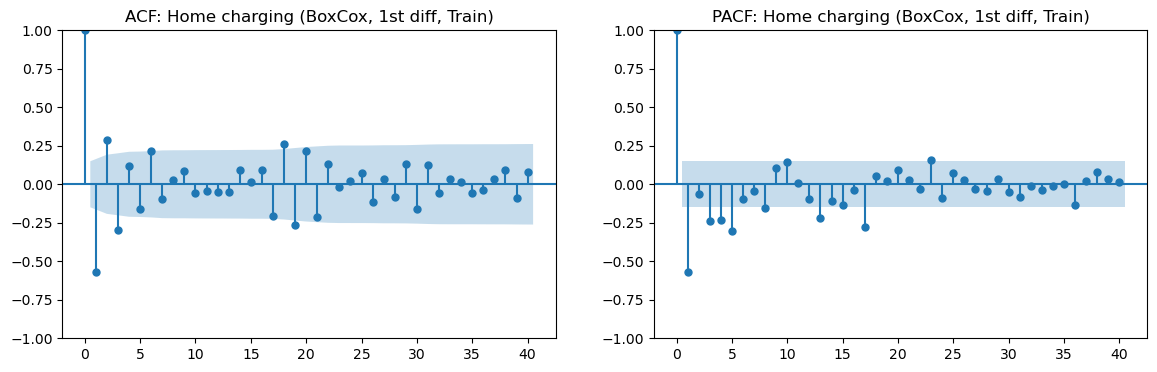

In [ ]:


# Use BoxCox-transformed, 1st-differenced train split for 'Home charging (G)'
exog_feature = diff_results['Home charging (G)']
target_diff = diff_results[target]

# Try lags 1 to 6 for exogenous variable
max_lag = 6

aic_bic_results_homechg = []

for lag in range(1, max_lag + 1):
    # Lag exogenous variable (align with target_diff)
    exog_lagged = np.roll(exog_feature, lag)
    exog_lagged[:lag] = np.nan  # first 'lag' values are invalid
    valid_idx = ~np.isnan(exog_lagged)
    y_valid = target_diff[valid_idx]
    exog_valid = exog_lagged[valid_idx].reshape(-1, 1)
    
    # Fit SARIMAX (ARIMA(0,0,0) since already differenced, no AR/MA terms)
    model = sm.tsa.SARIMAX(
        y_valid,
        order=(0, 0, 0),
        exog=exog_valid,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    res = model.fit(disp=False)
    aic_bic_results_homechg.append({
        'lag': lag,
        'AIC': res.aic,
        'BIC': res.bic
    })

# Sort by AIC and BIC
aic_sorted_homechg = sorted(aic_bic_results_homechg, key=lambda x: x['AIC'])
bic_sorted_homechg = sorted(aic_bic_results_homechg, key=lambda x: x['BIC'])

print("Optimal lags for Home charging (G) sorted by AIC:")
for r in aic_sorted_homechg:
    print(f"Lag: {r['lag']}, AIC: {r['AIC']:.2f}, BIC: {r['BIC']:.2f}")

print("\nOptimal lags for Home charging (G) sorted by BIC:")
for r in bic_sorted_homechg:
    print(f"Lag: {r['lag']}, AIC: {r['AIC']:.2f}, BIC: {r['BIC']:.2f}")

    # Plot ACF and PACF for the BoxCox-transformed, 1st-differenced Home charging (train split)
    homechg_bc_diff = exog_feature

plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plot_acf(homechg_bc_diff, ax=plt.gca(), lags=40)
plt.title('ACF: Home charging (BoxCox, 1st diff, Train)')

plt.subplot(1, 2, 2)
plot_pacf(homechg_bc_diff, ax=plt.gca(), lags=40, method='ywm')
plt.title('PACF: Home charging (BoxCox, 1st diff, Train)')

plt.show()

### Fit Sarimax and diagnose 

Rolling 3-step RMSE: 3711.92
Rolling 3-step MAPE: 18.84%


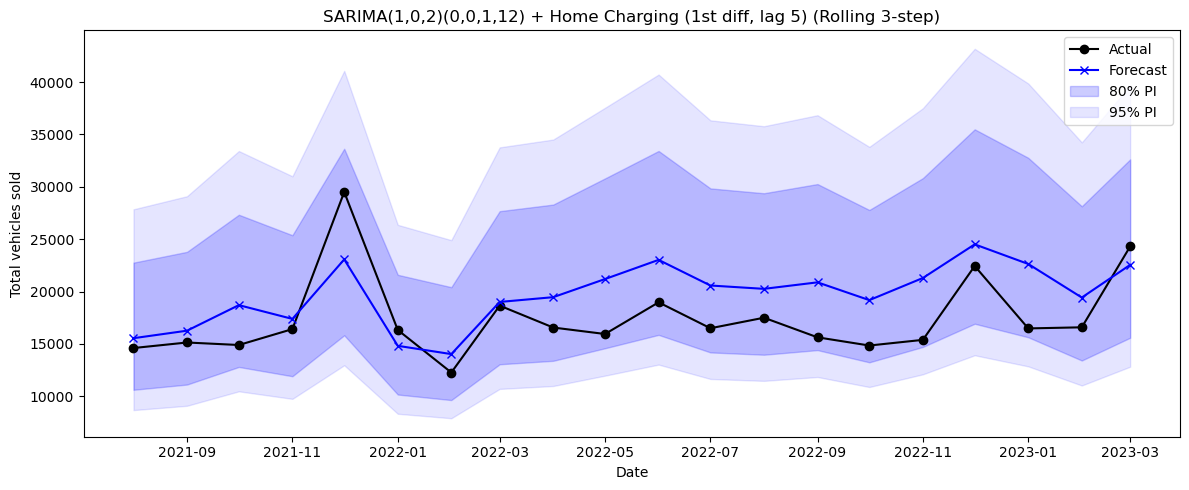

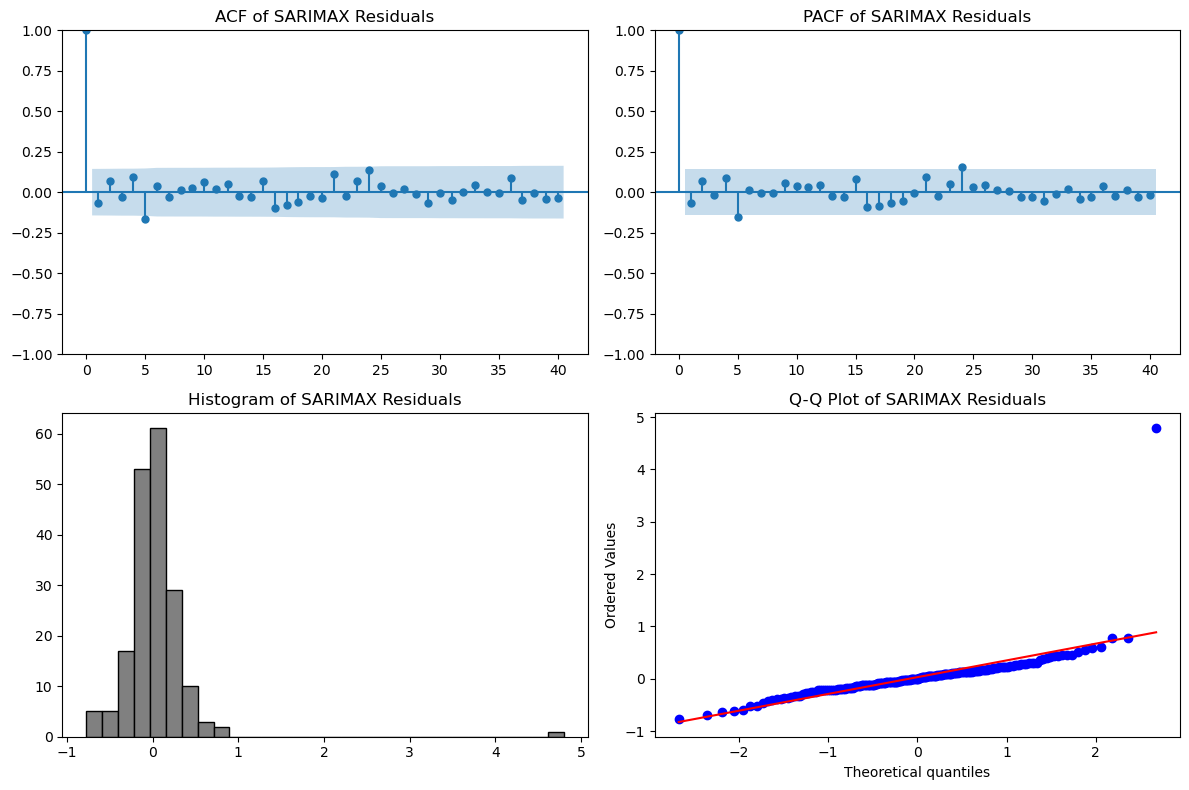

Ljung-Box test p-values (no autocorrelation if > 0.05):
      lb_stat  lb_pvalue
10  10.323041   0.412624
20  16.547528   0.682129
30  25.919836   0.679217


In [ ]:
### 3 step (, like gasoline/car tax)

warnings.filterwarnings("ignore", category=ValueWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
# ─── 1. Prepare data ───────────────────────────────────────────────────────────
homechg_bc_raw = boxcox_all['Home charging (G)']
homechg_bc = np.diff(homechg_bc_raw)  # FIRST DIFFERENCE
target_bc  = boxcox_all[target]

# Adjust indices for differencing
history_y        = list(target_bc[1:train_end])         # align with diffed homechg_bc
history_homechg  = list(homechg_bc[:train_end-1])

val_y        = target_bc[train_end:val_end]
val_homechg  = homechg_bc[train_end-1:val_end-1]

horizon = 3
lag     = 5  # chosen exogenous lag

predictions_bc = []
conf_int_80    = []
conf_int_95    = []

# ─── 2. Rolling loop ────────────────────────────────────────────────────────────
for t in range(len(val_y) - horizon + 1):
    # 2a) Build a DataFrame of history + lagged home charging
    df_hist = pd.DataFrame({
        'y': history_y,
        'homechg': history_homechg
    })
    df_hist['homechg_lag5'] = df_hist['homechg'].shift(lag)
    df_hist = df_hist.dropna()

    y_hist    = df_hist['y']
    exog_hist = df_hist['homechg_lag5'].values.reshape(-1, 1)

    # 2b) Fit SARIMAX on history
    model = SARIMAX(
        y_hist,
        exog=exog_hist,
        order=(1, 0, 2),
        seasonal_order=(0, 0, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fitted = model.fit(disp=False)

    # 2c) Construct future exogenous inputs **only** from history_homechg
    homechg_future_lags = [
        history_homechg[-lag + (i+1)]
        for i in range(horizon)
    ]
    exog_future = np.array(homechg_future_lags).reshape(horizon, 1)

    # 2d) Multi-step forecast with exog
    fc = fitted.get_forecast(steps=horizon, exog=exog_future)

    # pull out the 3rd step’s point forecast + intervals
    yhat      = fc.predicted_mean.iloc[-1]
    ci80, ci80_u = fc.conf_int(alpha=0.20).iloc[-1].values
    ci95, ci95_u = fc.conf_int(alpha=0.05).iloc[-1].values

    predictions_bc.append(yhat)
    conf_int_80.append((ci80, ci80_u))
    conf_int_95.append((ci95, ci95_u))

    # 2e) Now that we’ve “observed” time t, append the actuals to history
    history_y.append(val_y[t])
    history_homechg.append(val_homechg[t])

# ─── 3. Invert Box–Cox & compute metrics ────────────────────────────────────────
lam, shift = boxcox_lambdas_all[target]
def inv_boxcox(y, lam):
    return np.exp(y) if lam == 0 else np.power(lam * y + 1, 1/lam)

pred_bc = np.array(predictions_bc)
pred_orig  = inv_boxcox(pred_bc, lam) - shift
actuals    = y_val.values[horizon-1:]

# intervals
ci80_arr = np.array(conf_int_80)
ci95_arr = np.array(conf_int_95)

ci80_lower = inv_boxcox(ci80_arr[:,0], lam) - shift
ci80_upper = inv_boxcox(ci80_arr[:,1], lam) - shift
ci95_lower = inv_boxcox(ci95_arr[:,0], lam) - shift
ci95_upper = inv_boxcox(ci95_arr[:,1], lam) - shift

# metrics
rmse = np.sqrt(mean_squared_error(actuals, pred_orig))
mape = mean_absolute_percentage_error(actuals, pred_orig)

print(f"Rolling 3-step RMSE: {rmse:.2f}")
print(f"Rolling 3-step MAPE: {mape:.2%}")

# ─── 4. Plot results ────────────────────────────────────────────────────────────
x_dates = df["Time Period (T)"][train_end+horizon-1:val_end]

plt.figure(figsize=(12,5))
plt.plot(x_dates, actuals, marker='o', color='black', label='Actual')
plt.plot(x_dates, pred_orig, marker='x', color='blue', label='Forecast')
plt.fill_between(x_dates, ci80_lower, ci80_upper, color='blue', alpha=0.2, label='80% PI')
plt.fill_between(x_dates, ci95_lower, ci95_upper, color='blue', alpha=0.1, label='95% PI')
plt.title('SARIMA(1,0,2)(0,0,1,12) + Home Charging (1st diff, lag 5) (Rolling 3-step)')
plt.xlabel('Date')
plt.ylabel('Total vehicles sold')
plt.legend()
plt.tight_layout()
plt.show()

# ─── 5. Residual diagnostics ────────────────────────────────────────────────────

# Get residuals from the last fitted SARIMAX model in the rolling loop
residuals = fitted.resid

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# ACF plot
plot_acf(residuals, ax=axes[0, 0], lags=40)
axes[0, 0].set_title("ACF of SARIMAX Residuals")

# PACF plot
plot_pacf(residuals, ax=axes[0, 1], lags=40, method='ywm')
axes[0, 1].set_title("PACF of SARIMAX Residuals")

# Histogram
axes[1, 0].hist(residuals, bins=30, color='gray', edgecolor='black')
axes[1, 0].set_title("Histogram of SARIMAX Residuals")

# Q-Q plot
stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title("Q-Q Plot of SARIMAX Residuals")

plt.tight_layout()
plt.show()

# Ljung-Box test for autocorrelation (white noise)
lb_test = acorr_ljungbox(residuals, lags=[10, 20, 30], return_df=True)
print("Ljung-Box test p-values (no autocorrelation if > 0.05):")
print(lb_test[['lb_stat', 'lb_pvalue']])

Rolling 3-step RMSE: 3708.38
Rolling 3-step MAPE: 18.40%


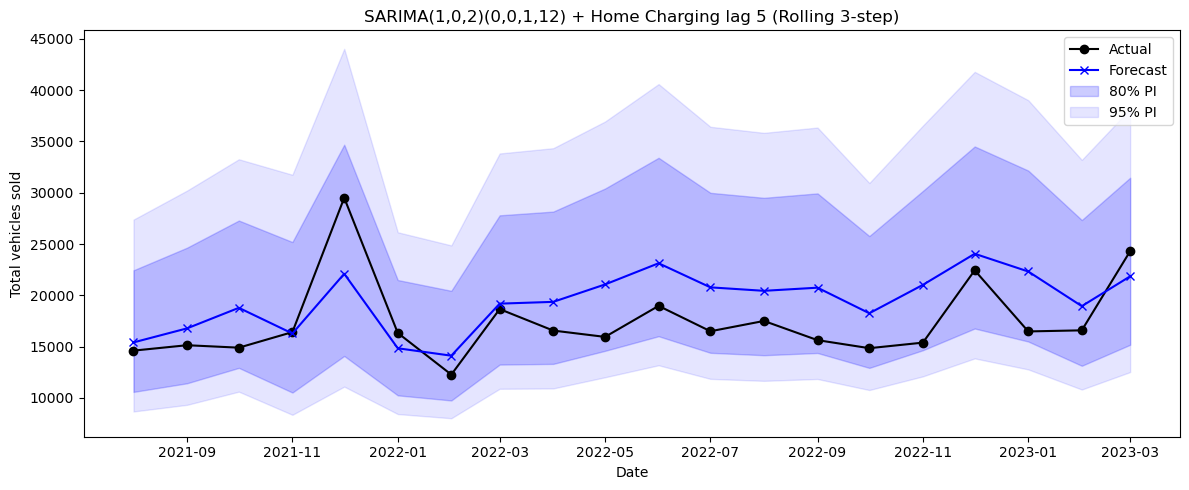

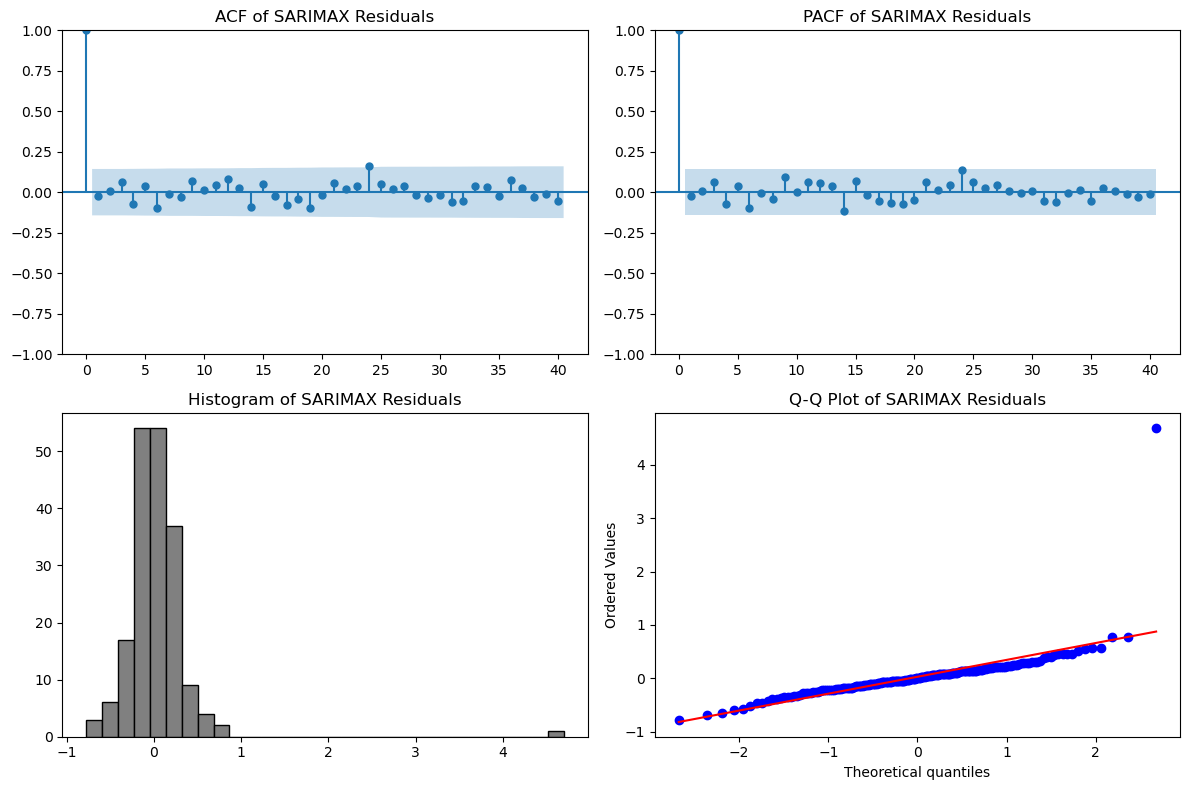

Ljung-Box test p-values (no autocorrelation if > 0.05):
      lb_stat  lb_pvalue
10   5.407992   0.862313
20  13.637585   0.848386
30  21.668346   0.865833


In [ ]:
# ### 3 step (, like gasoline/car tax)

# warnings.filterwarnings("ignore", category=ValueWarning)
# warnings.filterwarnings("ignore", category=ConvergenceWarning)
# warnings.filterwarnings("ignore", category=FutureWarning)
# # ─── 1. Prepare data ───────────────────────────────────────────────────────────
# homechg_bc = boxcox_all['Home charging (G)']
# target_bc  = boxcox_all[target]

# history_y      = list(target_bc[:train_end])
# history_homechg = list(homechg_bc[:train_end])

# val_y      = target_bc[train_end:val_end]
# val_homechg = homechg_bc[train_end:val_end]

# horizon = 3
# lag     = 5  # chosen exogenous lag

# predictions_bc = []
# conf_int_80    = []
# conf_int_95    = []

# # ─── 2. Rolling loop ────────────────────────────────────────────────────────────
# for t in range(len(val_y) - horizon + 1):
#     # 2a) Build a DataFrame of history + lagged home charging
#     df_hist = pd.DataFrame({
#         'y': history_y,
#         'homechg': history_homechg
#     })
#     df_hist['homechg_lag5'] = df_hist['homechg'].shift(lag)
#     df_hist = df_hist.dropna()

#     y_hist    = df_hist['y']
#     exog_hist = df_hist['homechg_lag5'].values.reshape(-1, 1)

#     # 2b) Fit SARIMAX on history
#     model = SARIMAX(
#         y_hist,
#         exog=exog_hist,
#         order=(1, 0, 2),
#         seasonal_order=(0, 0, 1, 12),
#         enforce_stationarity=False,
#         enforce_invertibility=False
#     )
#     fitted = model.fit(disp=False)

#     # 2c) Construct future exogenous inputs **only** from history_homechg
#     homechg_future_lags = [
#         history_homechg[-lag + (i+1)]
#         for i in range(horizon)
#     ]
#     exog_future = np.array(homechg_future_lags).reshape(horizon, 1)

#     # 2d) Multi-step forecast with exog
#     fc = fitted.get_forecast(steps=horizon, exog=exog_future)

#     # pull out the 3rd step’s point forecast + intervals
#     yhat      = fc.predicted_mean.iloc[-1]
#     ci80, ci80_u = fc.conf_int(alpha=0.20).iloc[-1].values
#     ci95, ci95_u = fc.conf_int(alpha=0.05).iloc[-1].values

#     predictions_bc.append(yhat)
#     conf_int_80.append((ci80, ci80_u))
#     conf_int_95.append((ci95, ci95_u))

#     # 2e) Now that we’ve “observed” time t, append the actuals to history
#     history_y.append(val_y[t])
#     history_homechg.append(val_homechg[t])

# # ─── 3. Invert Box–Cox & compute metrics ────────────────────────────────────────
# lam, shift = boxcox_lambdas_all[target]
# def inv_boxcox(y, lam):
#     return np.exp(y) if lam == 0 else np.power(lam * y + 1, 1/lam)

# pred_bc = np.array(predictions_bc)
# pred_orig  = inv_boxcox(pred_bc, lam) - shift
# actuals    = y_val.values[horizon-1:]

# # intervals
# ci80_arr = np.array(conf_int_80)
# ci95_arr = np.array(conf_int_95)

# ci80_lower = inv_boxcox(ci80_arr[:,0], lam) - shift
# ci80_upper = inv_boxcox(ci80_arr[:,1], lam) - shift
# ci95_lower = inv_boxcox(ci95_arr[:,0], lam) - shift
# ci95_upper = inv_boxcox(ci95_arr[:,1], lam) - shift

# # metrics
# rmse = np.sqrt(mean_squared_error(actuals, pred_orig))
# mape = mean_absolute_percentage_error(actuals, pred_orig)

# print(f"Rolling 3-step RMSE: {rmse:.2f}")
# print(f"Rolling 3-step MAPE: {mape:.2%}")

# # ─── 4. Plot results ────────────────────────────────────────────────────────────
# x_dates = df["Time Period (T)"][train_end+horizon-1:val_end]

# plt.figure(figsize=(12,5))
# plt.plot(x_dates, actuals, marker='o', color='black', label='Actual')
# plt.plot(x_dates, pred_orig, marker='x', color='blue', label='Forecast')
# plt.fill_between(x_dates, ci80_lower, ci80_upper, color='blue', alpha=0.2, label='80% PI')
# plt.fill_between(x_dates, ci95_lower, ci95_upper, color='blue', alpha=0.1, label='95% PI')
# plt.title('SARIMA(1,0,2)(0,0,1,12) + Home Charging lag 5 (Rolling 3-step)')
# plt.xlabel('Date')
# plt.ylabel('Total vehicles sold')
# plt.legend()
# plt.tight_layout()
# plt.show()

# # ─── 5. Residual diagnostics ────────────────────────────────────────────────────


# # Get residuals from the last fitted SARIMAX model in the rolling loop
# residuals = fitted.resid

# fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# # ACF plot
# plot_acf(residuals, ax=axes[0, 0], lags=40)
# axes[0, 0].set_title("ACF of SARIMAX Residuals")

# # PACF plot
# plot_pacf(residuals, ax=axes[0, 1], lags=40, method='ywm')
# axes[0, 1].set_title("PACF of SARIMAX Residuals")

# # Histogram
# axes[1, 0].hist(residuals, bins=30, color='gray', edgecolor='black')
# axes[1, 0].set_title("Histogram of SARIMAX Residuals")

# # Q-Q plot
# stats.probplot(residuals, dist="norm", plot=axes[1, 1])
# axes[1, 1].set_title("Q-Q Plot of SARIMAX Residuals")

# plt.tight_layout()
# plt.show()

# # Ljung-Box test for autocorrelation (white noise)
# lb_test = acorr_ljungbox(residuals, lags=[10, 20, 30], return_df=True)
# print("Ljung-Box test p-values (no autocorrelation if > 0.05):")
# print(lb_test[['lb_stat', 'lb_pvalue']])

## 7d Consumer confidence (E)

### Lag Selection

Optimal lags for Consumer confidence (E) sorted by AIC:
Lag: 6, AIC: 123.13, BIC: 129.34
Lag: 4, AIC: 123.38, BIC: 129.62
Lag: 3, AIC: 123.44, BIC: 129.69
Lag: 5, AIC: 123.55, BIC: 129.78
Lag: 2, AIC: 124.23, BIC: 130.49
Lag: 1, AIC: 127.64, BIC: 133.92

Optimal lags for Consumer confidence (E) sorted by BIC:
Lag: 6, AIC: 123.13, BIC: 129.34
Lag: 4, AIC: 123.38, BIC: 129.62
Lag: 3, AIC: 123.44, BIC: 129.69
Lag: 5, AIC: 123.55, BIC: 129.78
Lag: 2, AIC: 124.23, BIC: 130.49
Lag: 1, AIC: 127.64, BIC: 133.92


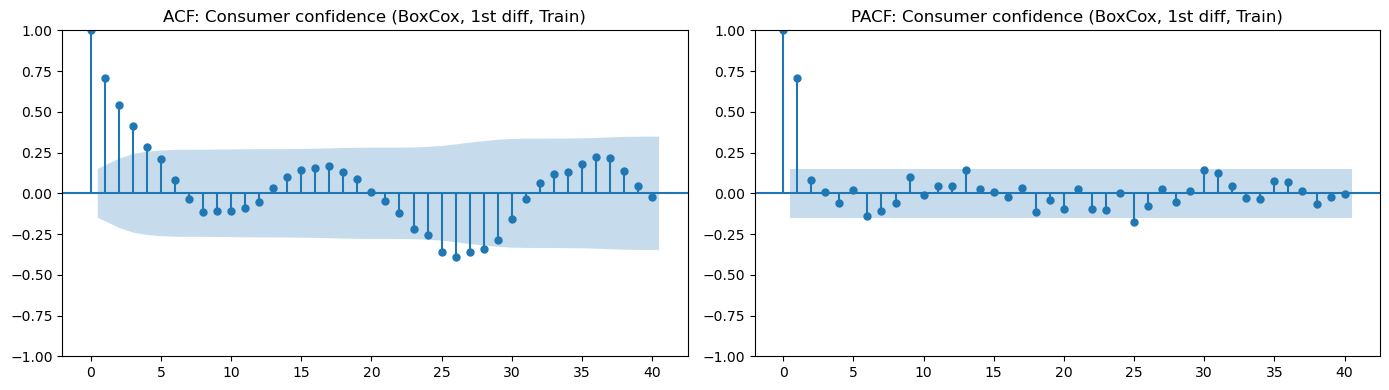

In [ ]:


# Use BoxCox-transformed, 1st-differenced train split for 'Consumer confidence (E)'
exog_feature_conf = np.diff(boxcox_all['Consumer confidence (E)'][:train_end], n=1)
target_diff = train_bc_diff

# Try lags 1 to 6 for exogenous variable
max_lag = 6

aic_bic_results_conf = []

for lag in range(1, max_lag + 1):
    # Lag exogenous variable (align with target_diff)
    exog_lagged = np.roll(exog_feature_conf, lag)
    exog_lagged[:lag] = np.nan  # first 'lag' values are invalid
    valid_idx = ~np.isnan(exog_lagged)
    y_valid = target_diff[valid_idx]
    exog_valid = exog_lagged[valid_idx].reshape(-1, 1)
    
    # Fit SARIMAX (ARIMA(0,0,0) since already differenced, no AR/MA terms)
    model = sm.tsa.SARIMAX(
        y_valid,
        order=(0, 0, 0),
        exog=exog_valid,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    res = model.fit(disp=False)
    aic_bic_results_conf.append({
        'lag': lag,
        'AIC': res.aic,
        'BIC': res.bic
    })

# Sort by AIC and BIC
aic_sorted_conf = sorted(aic_bic_results_conf, key=lambda x: x['AIC'])
bic_sorted_conf = sorted(aic_bic_results_conf, key=lambda x: x['BIC'])

print("Optimal lags for Consumer confidence (E) sorted by AIC:")
for r in aic_sorted_conf:
    print(f"Lag: {r['lag']}, AIC: {r['AIC']:.2f}, BIC: {r['BIC']:.2f}")

print("\nOptimal lags for Consumer confidence (E) sorted by BIC:")
for r in bic_sorted_conf:
    print(f"Lag: {r['lag']}, AIC: {r['AIC']:.2f}, BIC: {r['BIC']:.2f}")

    # Plot ACF and PACF for the BoxCox-transformed, 1st-differenced Consumer confidence (train split)
    conf_bc_diff = exog_feature_conf

plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plot_acf(conf_bc_diff, ax=plt.gca(), lags=40)
plt.title('ACF: Consumer confidence (BoxCox, 1st diff, Train)')

plt.subplot(1, 2, 2)
plot_pacf(conf_bc_diff, ax=plt.gca(), lags=40, method='ywm')
plt.title('PACF: Consumer confidence (BoxCox, 1st diff, Train)')

plt.tight_layout()
plt.show()

Rolling 3-step RMSE: 3447.04
Rolling 3-step MAPE: 17.32%


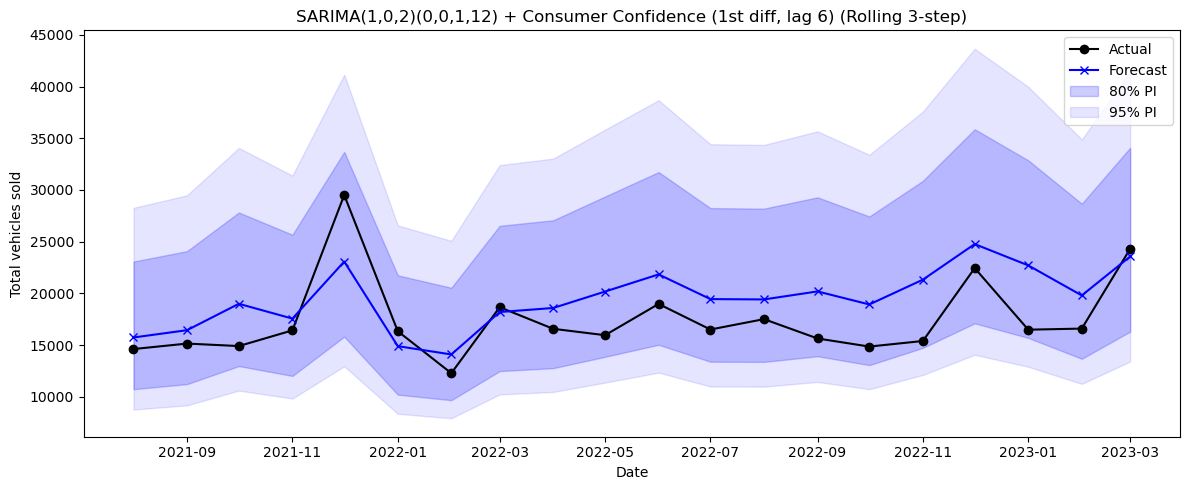

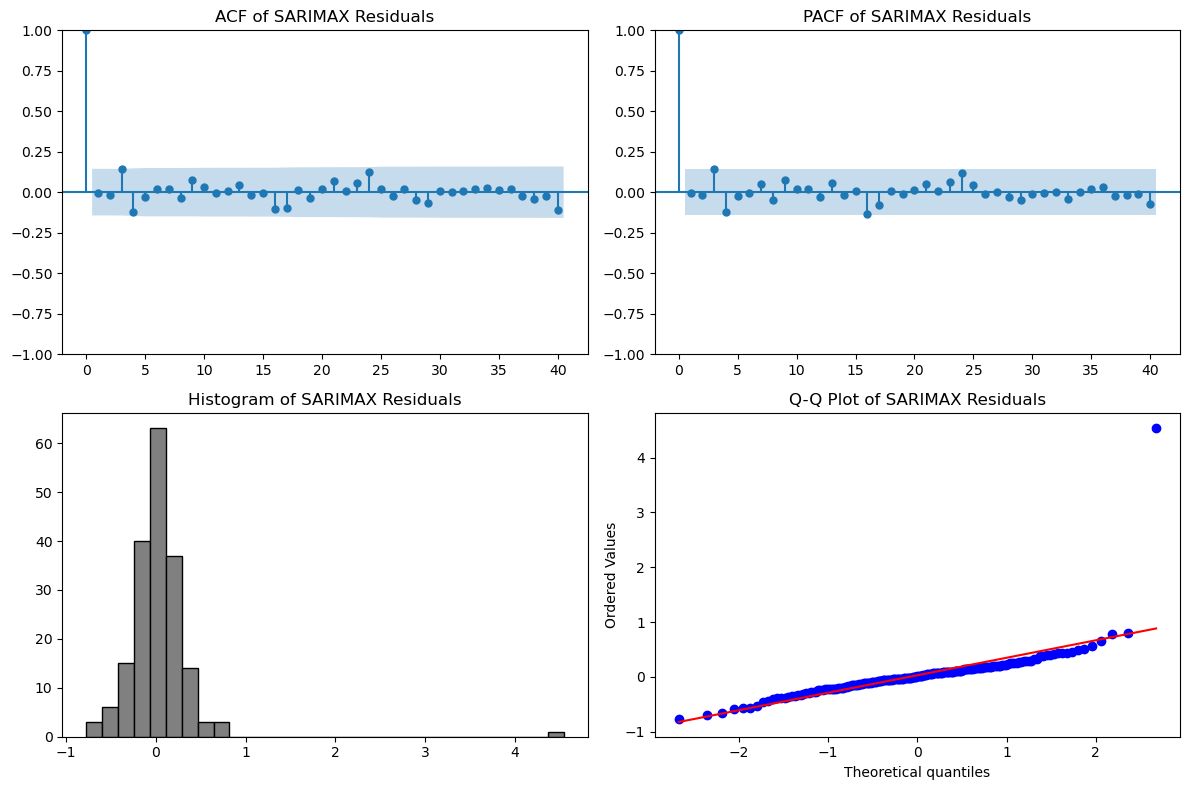

Ljung-Box test p-values (no autocorrelation if > 0.05):
      lb_stat  lb_pvalue
10   8.933602   0.538416
20  14.027982   0.829074
30  21.012899   0.887484


In [ ]:
# rolling 3-step SARIMA with Consumer Confidence (lag 6) + FIRST DIFFERENCING
warnings.filterwarnings("ignore", category=ValueWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# ─── 1. Prepare data ───────────────────────────────────────────────────────────
conf_bc_raw = boxcox_all['Consumer confidence (E)']
conf_bc = np.diff(conf_bc_raw)  # FIRST DIFFERENCE
target_bc = boxcox_all[target]

# Adjust indices for differencing
history_y = list(target_bc[1:train_end])  # align with diffed conf_bc
history_conf = list(conf_bc[:train_end-1])

val_y = target_bc[train_end:val_end]
val_conf = conf_bc[train_end-1:val_end-1]

horizon = 3
lag = 6  # chosen exogenous lag

predictions_bc = []
conf_int_80 = []
conf_int_95 = []

# ─── 2. Rolling loop ────────────────────────────────────────────────────────────
for t in range(len(val_y) - horizon + 1):
    # 2a) Build a DataFrame of history + lagged conf
    df_hist = pd.DataFrame({
        'y': history_y,
        'conf': history_conf
    })
    df_hist['conf_lag6'] = df_hist['conf'].shift(lag)
    df_hist = df_hist.dropna()

    y_hist = df_hist['y']
    exog_hist = df_hist['conf_lag6'].values.reshape(-1, 1)

    # 2b) Fit SARIMAX on history
    model = SARIMAX(
        y_hist,
        exog=exog_hist,
        order=(1, 0, 2),
        seasonal_order=(0, 0, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fitted = model.fit(disp=False)

    # 2c) Construct future exogenous inputs **only** from history_conf
    conf_future_lags = [
        history_conf[-lag + (i+1)]
        for i in range(horizon)
    ]
    exog_future = np.array(conf_future_lags).reshape(horizon, 1)

    # 2d) Multi-step forecast with exog
    fc = fitted.get_forecast(steps=horizon, exog=exog_future)

    # pull out the 3rd step’s point forecast + intervals
    yhat = fc.predicted_mean.iloc[-1]
    ci80, ci80_u = fc.conf_int(alpha=0.20).iloc[-1].values
    ci95, ci95_u = fc.conf_int(alpha=0.05).iloc[-1].values

    predictions_bc.append(yhat)
    conf_int_80.append((ci80, ci80_u))
    conf_int_95.append((ci95, ci95_u))

    # 2e) Now that we’ve “observed” time t, append the actuals to history
    history_y.append(val_y[t])
    history_conf.append(val_conf[t])

# ─── 3. Invert Box–Cox & compute metrics ────────────────────────────────────────
lam, shift = boxcox_lambdas_all[target]
def inv_boxcox(y, lam):
    return np.exp(y) if lam == 0 else np.power(lam * y + 1, 1/lam)

pred_bc = np.array(predictions_bc)
pred_orig = inv_boxcox(pred_bc, lam) - shift
actuals = y_val.values[horizon-1:]

# intervals
ci80_arr = np.array(conf_int_80)
ci95_arr = np.array(conf_int_95)

ci80_lower = inv_boxcox(ci80_arr[:,0], lam) - shift
ci80_upper = inv_boxcox(ci80_arr[:,1], lam) - shift
ci95_lower = inv_boxcox(ci95_arr[:,0], lam) - shift
ci95_upper = inv_boxcox(ci95_arr[:,1], lam) - shift

# metrics
rmse = np.sqrt(mean_squared_error(actuals, pred_orig))
mape = mean_absolute_percentage_error(actuals, pred_orig)

print(f"Rolling 3-step RMSE: {rmse:.2f}")
print(f"Rolling 3-step MAPE: {mape:.2%}")

# ─── 4. Plot results ────────────────────────────────────────────────────────────
x_dates = df["Time Period (T)"][train_end+horizon-1:val_end]

plt.figure(figsize=(12,5))
plt.plot(x_dates, actuals, marker='o', color='black', label='Actual')
plt.plot(x_dates, pred_orig, marker='x', color='blue', label='Forecast')
plt.fill_between(x_dates, ci80_lower, ci80_upper, color='blue', alpha=0.2, label='80% PI')
plt.fill_between(x_dates, ci95_lower, ci95_upper, color='blue', alpha=0.1, label='95% PI')
plt.title('SARIMA(1,0,2)(0,0,1,12) + Consumer Confidence (1st diff, lag 6) (Rolling 3-step)')
plt.xlabel('Date')
plt.ylabel('Total vehicles sold')
plt.legend()
plt.tight_layout()
plt.show()

# ─── 5. Residual diagnostics ────────────────────────────────────────────────────

# Get residuals from the last fitted SARIMAX model in the rolling loop
residuals = fitted.resid

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# ACF plot
plot_acf(residuals, ax=axes[0, 0], lags=40)
axes[0, 0].set_title("ACF of SARIMAX Residuals")

# PACF plot
plot_pacf(residuals, ax=axes[0, 1], lags=40, method='ywm')
axes[0, 1].set_title("PACF of SARIMAX Residuals")

# Histogram
axes[1, 0].hist(residuals, bins=30, color='gray', edgecolor='black')
axes[1, 0].set_title("Histogram of SARIMAX Residuals")

# Q-Q plot
stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title("Q-Q Plot of SARIMAX Residuals")

plt.tight_layout()
plt.show()

# Ljung-Box test for autocorrelation (white noise)
lb_test = acorr_ljungbox(residuals, lags=[10, 20, 30], return_df=True)
print("Ljung-Box test p-values (no autocorrelation if > 0.05):")
print(lb_test[['lb_stat', 'lb_pvalue']])

### Fit Sarimax and diagnose 

Rolling 3-step RMSE: 3801.21
Rolling 3-step MAPE: 18.87%


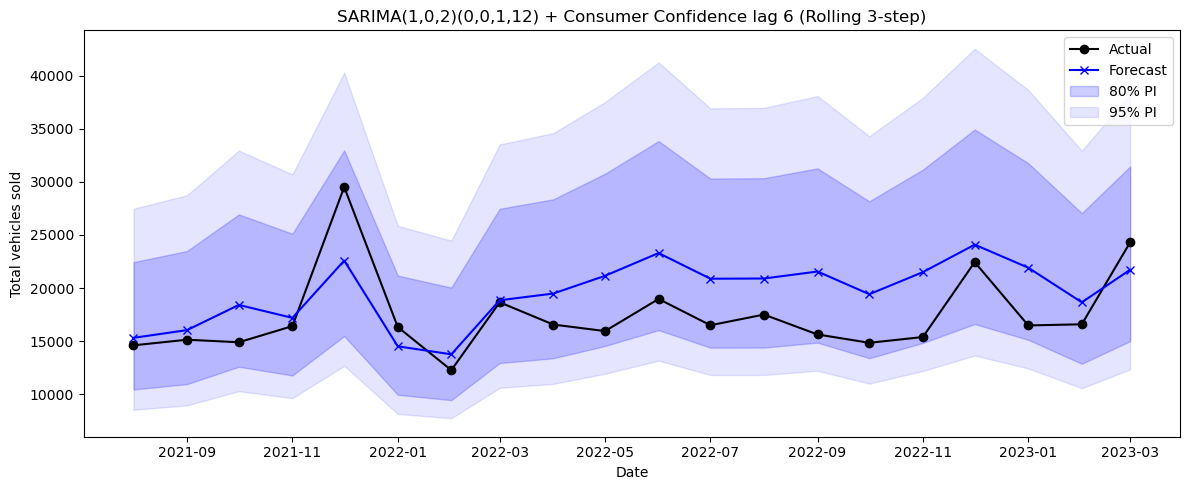

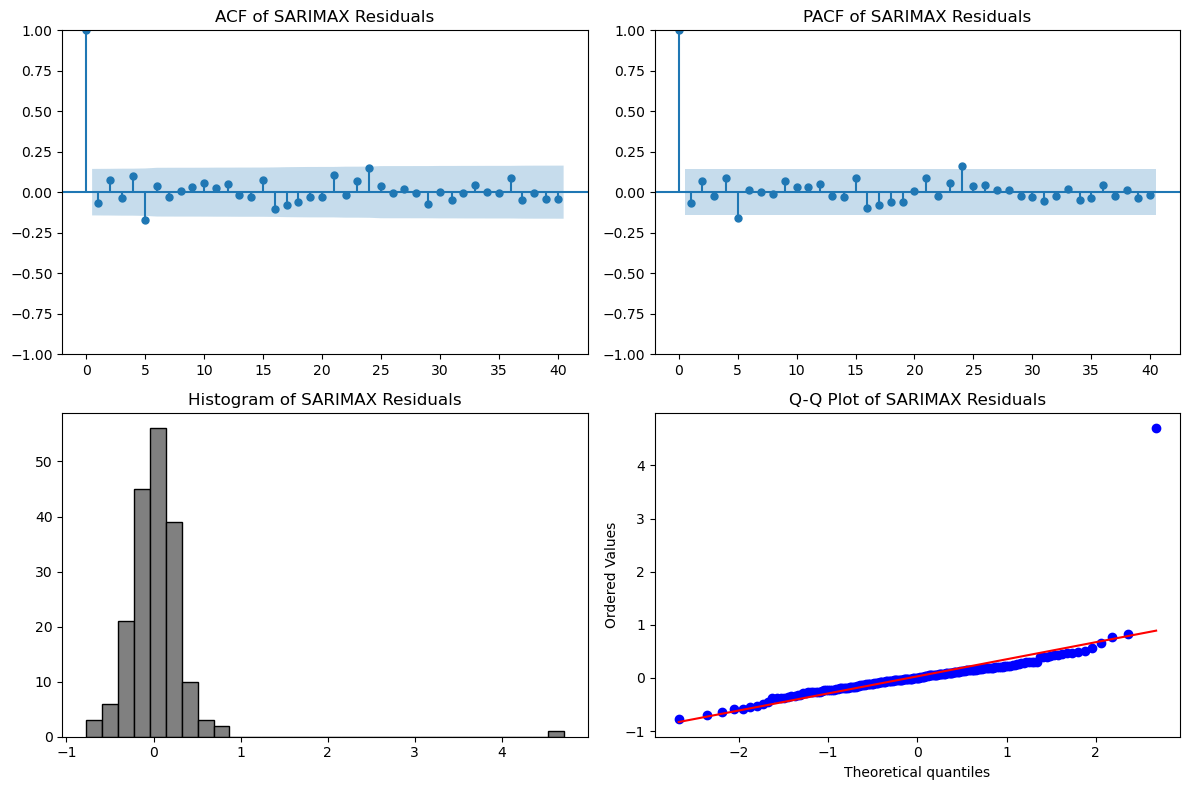

Ljung-Box test p-values (no autocorrelation if > 0.05):
      lb_stat  lb_pvalue
10  10.844671   0.369747
20  17.623895   0.612169
30  27.654469   0.588741


In [ ]:
# # rolling 3-step SARIMA with Consumer Confidence (lag 6)
# warnings.filterwarnings("ignore", category=ValueWarning)
# warnings.filterwarnings("ignore", category=ConvergenceWarning)
# warnings.filterwarnings("ignore", category=FutureWarning)

# # ─── 1. Prepare data ───────────────────────────────────────────────────────────
# conf_bc   = boxcox_all['Consumer confidence (E)']
# target_bc = boxcox_all[target]

# history_y   = list(target_bc[:train_end])
# history_conf = list(conf_bc[:train_end])

# val_y   = target_bc[train_end:val_end]
# val_conf = conf_bc[train_end:val_end]

# horizon = 3
# lag     = 6  # chosen exogenous lag

# predictions_bc = []
# conf_int_80    = []
# conf_int_95    = []

# # ─── 2. Rolling loop ────────────────────────────────────────────────────────────
# for t in range(len(val_y) - horizon + 1):
#     # 2a) Build a DataFrame of history + lagged conf
#     df_hist = pd.DataFrame({
#         'y': history_y,
#         'conf': history_conf
#     })
#     df_hist['conf_lag6'] = df_hist['conf'].shift(lag)
#     df_hist = df_hist.dropna()

#     y_hist    = df_hist['y']
#     exog_hist = df_hist['conf_lag6'].values.reshape(-1, 1)

#     # 2b) Fit SARIMAX on history
#     model = SARIMAX(
#         y_hist,
#         exog=exog_hist,
#         order=(1, 0, 2),
#         seasonal_order=(0, 0, 1, 12),
#         enforce_stationarity=False,
#         enforce_invertibility=False
#     )
#     fitted = model.fit(disp=False)

#     # 2c) Construct future exogenous inputs **only** from history_conf
#     conf_future_lags = [
#         history_conf[-lag + (i+1)]
#         for i in range(horizon)
#     ]
#     exog_future = np.array(conf_future_lags).reshape(horizon, 1)

#     # 2d) Multi-step forecast with exog
#     fc = fitted.get_forecast(steps=horizon, exog=exog_future)

#     # pull out the 3rd step’s point forecast + intervals
#     yhat      = fc.predicted_mean.iloc[-1]
#     ci80, ci80_u = fc.conf_int(alpha=0.20).iloc[-1].values
#     ci95, ci95_u = fc.conf_int(alpha=0.05).iloc[-1].values

#     predictions_bc.append(yhat)
#     conf_int_80.append((ci80, ci80_u))
#     conf_int_95.append((ci95, ci95_u))

#     # 2e) Now that we’ve “observed” time t, append the actuals to history
#     history_y.append(val_y[t])
#     history_conf.append(val_conf[t])

# # ─── 3. Invert Box–Cox & compute metrics ────────────────────────────────────────
# lam, shift = boxcox_lambdas_all[target]
# def inv_boxcox(y, lam):
#     return np.exp(y) if lam == 0 else np.power(lam * y + 1, 1/lam)

# pred_bc = np.array(predictions_bc)
# pred_orig  = inv_boxcox(pred_bc, lam) - shift
# actuals    = y_val.values[horizon-1:]

# # intervals
# ci80_arr = np.array(conf_int_80)
# ci95_arr = np.array(conf_int_95)

# ci80_lower = inv_boxcox(ci80_arr[:,0], lam) - shift
# ci80_upper = inv_boxcox(ci80_arr[:,1], lam) - shift
# ci95_lower = inv_boxcox(ci95_arr[:,0], lam) - shift
# ci95_upper = inv_boxcox(ci95_arr[:,1], lam) - shift

# # metrics
# rmse = np.sqrt(mean_squared_error(actuals, pred_orig))
# mape = mean_absolute_percentage_error(actuals, pred_orig)

# print(f"Rolling 3-step RMSE: {rmse:.2f}")
# print(f"Rolling 3-step MAPE: {mape:.2%}")

# # ─── 4. Plot results ────────────────────────────────────────────────────────────
# x_dates = df["Time Period (T)"][train_end+horizon-1:val_end]

# plt.figure(figsize=(12,5))
# plt.plot(x_dates, actuals, marker='o', color='black', label='Actual')
# plt.plot(x_dates, pred_orig, marker='x', color='blue', label='Forecast')
# plt.fill_between(x_dates, ci80_lower, ci80_upper, color='blue', alpha=0.2, label='80% PI')
# plt.fill_between(x_dates, ci95_lower, ci95_upper, color='blue', alpha=0.1, label='95% PI')
# plt.title('SARIMA(1,0,2)(0,0,1,12) + Consumer Confidence lag 6 (Rolling 3-step)')
# plt.xlabel('Date')
# plt.ylabel('Total vehicles sold')
# plt.legend()
# plt.tight_layout()
# plt.show()

# # ─── 5. Residual diagnostics ────────────────────────────────────────────────────


# # Get residuals from the last fitted SARIMAX model in the rolling loop
# residuals = fitted.resid

# fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# # ACF plot
# plot_acf(residuals, ax=axes[0, 0], lags=40)
# axes[0, 0].set_title("ACF of SARIMAX Residuals")

# # PACF plot
# plot_pacf(residuals, ax=axes[0, 1], lags=40, method='ywm')
# axes[0, 1].set_title("PACF of SARIMAX Residuals")

# # Histogram
# axes[1, 0].hist(residuals, bins=30, color='gray', edgecolor='black')
# axes[1, 0].set_title("Histogram of SARIMAX Residuals")

# # Q-Q plot
# stats.probplot(residuals, dist="norm", plot=axes[1, 1])
# axes[1, 1].set_title("Q-Q Plot of SARIMAX Residuals")

# plt.tight_layout()
# plt.show()

# # Ljung-Box test for autocorrelation (white noise)
# lb_test = acorr_ljungbox(residuals, lags=[10, 20, 30], return_df=True)
# print("Ljung-Box test p-values (no autocorrelation if > 0.05):")
# print(lb_test[['lb_stat', 'lb_pvalue']])

# 8 All features together/ turn this into top features together

| Model                       | Lag | RMSE        | MAPE       |
| --------------------------- | --- | ----------- | ---------- |
| **Baseline (no exogenous)** | –   | 4359.91     | 18.31%     |
| Gasoline price              | 6   | 3797.68     | **15.54%** |
| Company car tax rate (%)    | 3   | 3756.22     | 19.13%     |
| Home charging (G)           | 5   | **3708.38** | 18.40%     |
| Consumer confidence (E)     | 6   | 3801.21     | 18.87%     |


**Interpretation**
- Gasoline price (lag 6) delivers the strongest MAPE improvement, dropping MAPE from 18.31% to 15.54%.

- Home charging (lag 5) yields the largest RMSE drop, shaving almost 650 units off the baseline error.

- Company car tax and consumer confidence both improve RMSE but worsen MAPE, suggesting they may reduce large errors but introduce relative bias.

Feature Combinations
- Option 1: Gasoline + Home Charging
    Captures both economic and behavioral signals from two uncorrelated sources. This is likely the most complementary and effective two-feature combination.

- Option 2: Gasoline + Company Car Tax
    Combines economic cost and policy incentives. This pair balances market behavior and government regulation.

- Optional third variable: Consumer Confidence
    This can be considered if residual diagnostics remain acceptable (no strong multicollinearity or autocorrelation). It captures macroeconomic perception but may be noisier.

**Next Steps**
- Test the performance of each combination using 3-step rolling validation.

- Check residuals (ACF, PACF, Ljung-Box test) to confirm no model misspecification.

- Evaluate combined models on both RMSE and MAPE.

- Select the final model based on predictive accuracy and diagnostic performance.

### Option 1 Gasoline + Home Charging

Validation RMSE (3-step rolling): 4582.25
Validation MAPE (3-step rolling): 17.73%


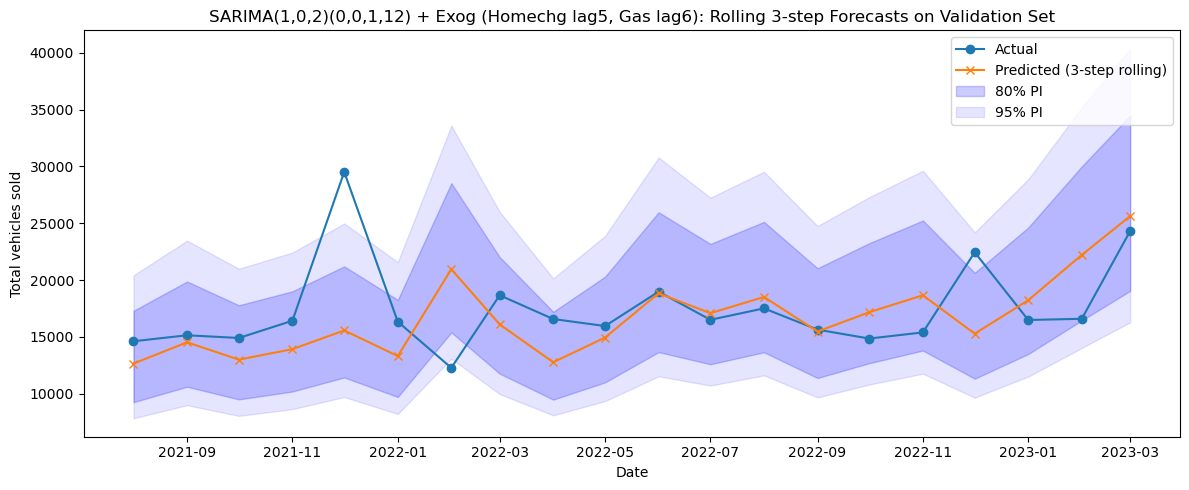

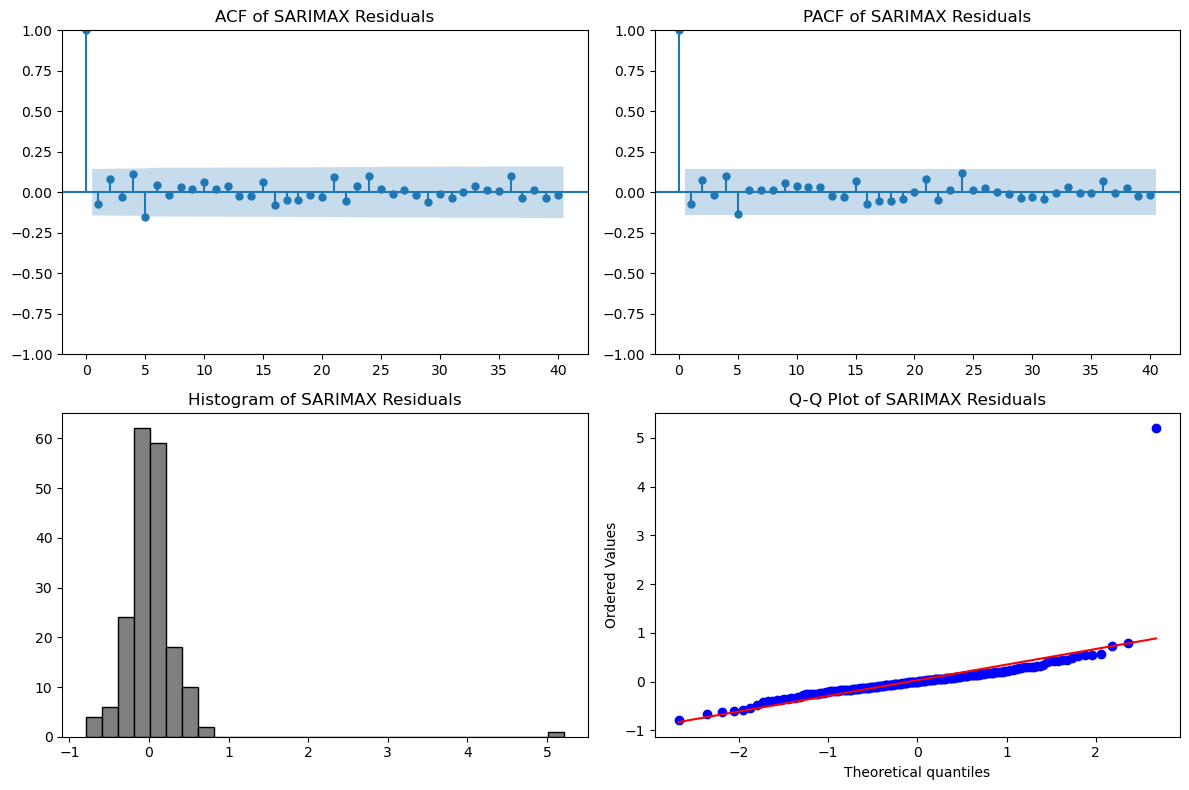

Ljung-Box test p-values (no autocorrelation if > 0.05):
      lb_stat  lb_pvalue
10  10.828920   0.371001
20  14.647518   0.796209
30  20.558511   0.901184


In [ ]:
# ─── 1. Prepare data ───────────────────────────────────────────────────────────
homechg_bc = boxcox_all['Home charging (G)']
gas_bc     = boxcox_all['Gasoline (Euro95) - Average price (F)']
target_bc  = boxcox_all[target]

history_y        = list(target_bc[:train_end])
history_homechg  = list(homechg_bc[:train_end])
history_gas      = list(gas_bc[:train_end])

val_y        = target_bc[train_end:val_end]
val_homechg  = homechg_bc[train_end:val_end]
val_gas      = gas_bc[train_end:val_end]

horizon = 3
lags    = [5, 6]  # lags for homechg, gas

predictions_bc = []
conf_int_80    = []
conf_int_95    = []

# ─── 2. Rolling loop ────────────────────────────────────────────────────────────
for t in range(len(val_y) - horizon + 1):
    # Lag exogenous variables
    homechg_hist = np.array(history_homechg)
    gas_hist     = np.array(history_gas)

    homechg_hist_lag5 = np.roll(homechg_hist, lags[0]); homechg_hist_lag5[:lags[0]] = np.nan
    gas_hist_lag6     = np.roll(gas_hist, lags[1]); gas_hist_lag6[:lags[1]] = np.nan

    # Align all (drop first 6 for max lag)
    y_hist = np.array(history_y)[lags[1]:]
    exog_hist = np.column_stack([
        homechg_hist_lag5[lags[1]:], gas_hist_lag6[lags[1]:]
    ])

    # Fit SARIMAX on history
    model = SARIMAX(
        y_hist,
        exog=exog_hist,
        order=(1, 0, 2),
        seasonal_order=(0, 0, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fitted = model.fit(disp=False)

    # Recursive 3-step forecast with intervals
    temp_history_y        = history_y.copy()
    temp_history_homechg  = history_homechg.copy()
    temp_history_gas      = history_gas.copy()
    for step in range(horizon):
        idx = t + step
        homechg_exog_full = np.concatenate([np.array(temp_history_homechg)[-lags[0]:], [val_homechg[idx]]])
        gas_exog_full     = np.concatenate([np.array(temp_history_gas)[-lags[1]:], [val_gas[idx]]])
        homechg_exog_lag5 = np.roll(homechg_exog_full, lags[0])[lags[0]:]
        gas_exog_lag6     = np.roll(gas_exog_full, lags[1])[lags[1]:]
        exog_next = np.column_stack([
            homechg_exog_lag5, gas_exog_lag6
        ])
        res = fitted.get_forecast(steps=1, exog=exog_next)
        yhat = res.predicted_mean[0]
        ci_80 = res.conf_int(alpha=0.20)[0]
        ci_95 = res.conf_int(alpha=0.05)[0]
        temp_history_y.append(yhat)
        temp_history_homechg.append(val_homechg[idx])
        temp_history_gas.append(val_gas[idx])
    predictions_bc.append(yhat)
    conf_int_80.append(ci_80)
    conf_int_95.append(ci_95)

    # Update rolling history with actuals for next window
    history_y.append(val_y[t])
    history_homechg.append(val_homechg[t])
    history_gas.append(val_gas[t])

# ─── 3. Invert Box–Cox & compute metrics ────────────────────────────────────────
lam, shift = boxcox_lambdas_all[target]
def inv_boxcox(y, lam):
    return np.exp(y) if lam == 0 else np.power(lam * y + 1, 1/lam)

pred_bc = np.array(predictions_bc)
pred_orig  = inv_boxcox(pred_bc, lam) - shift
actuals    = y_val.values[horizon-1:]

conf_int_80 = np.array(conf_int_80)
conf_int_95 = np.array(conf_int_95)
ci_80_lower = inv_boxcox(conf_int_80[:, 0], lam) - shift
ci_80_upper = inv_boxcox(conf_int_80[:, 1], lam) - shift
ci_95_lower = inv_boxcox(conf_int_95[:, 0], lam) - shift
ci_95_upper = inv_boxcox(conf_int_95[:, 1], lam) - shift

rmse_rolling = np.sqrt(mean_squared_error(actuals, pred_orig))
mape_rolling = mean_absolute_percentage_error(actuals, pred_orig)
print(f"Validation RMSE (3-step rolling): {rmse_rolling:.2f}")
print(f"Validation MAPE (3-step rolling): {mape_rolling:.2%}")

# ─── 4. Plot results ────────────────────────────────────────────────────────────
x_dates = df["Time Period (T)"][train_end+horizon-1:val_end]
plt.figure(figsize=(12, 5))
plt.plot(x_dates, actuals, label='Actual', marker='o')
plt.plot(x_dates, pred_orig, label='Predicted (3-step rolling)', marker='x')
plt.fill_between(x_dates, ci_80_lower, ci_80_upper, color='blue', alpha=0.2, label='80% PI')
plt.fill_between(x_dates, ci_95_lower, ci_95_upper, color='blue', alpha=0.1, label='95% PI')
plt.title('SARIMA(1,0,2)(0,0,1,12) + Exog (Homechg lag5, Gas lag6): Rolling 3-step Forecasts on Validation Set')
plt.xlabel('Date')
plt.ylabel('Total vehicles sold')
plt.legend()
plt.tight_layout()
plt.show()

# ─── 5. Residual diagnostics ────────────────────────────────────────────────────
import scipy.stats as stats

# Get residuals from the last fitted SARIMAX model in the rolling loop
residuals = fitted.resid

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# ACF plot
plot_acf(residuals, ax=axes[0, 0], lags=40)
axes[0, 0].set_title("ACF of SARIMAX Residuals")

# PACF plot
plot_pacf(residuals, ax=axes[0, 1], lags=40, method='ywm')
axes[0, 1].set_title("PACF of SARIMAX Residuals")

# Histogram
axes[1, 0].hist(residuals, bins=30, color='gray', edgecolor='black')
axes[1, 0].set_title("Histogram of SARIMAX Residuals")

# Q-Q plot
stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title("Q-Q Plot of SARIMAX Residuals")

plt.tight_layout()
plt.show()

# Ljung-Box test for autocorrelation (white noise)
lb_test = acorr_ljungbox(residuals, lags=[10, 20, 30], return_df=True)
print("Ljung-Box test p-values (no autocorrelation if > 0.05):")
print(lb_test[['lb_stat', 'lb_pvalue']])

### Option 2 Gasoline + Company Car Tax

Validation RMSE (3-step rolling): 4721.88
Validation MAPE (3-step rolling): 18.73%


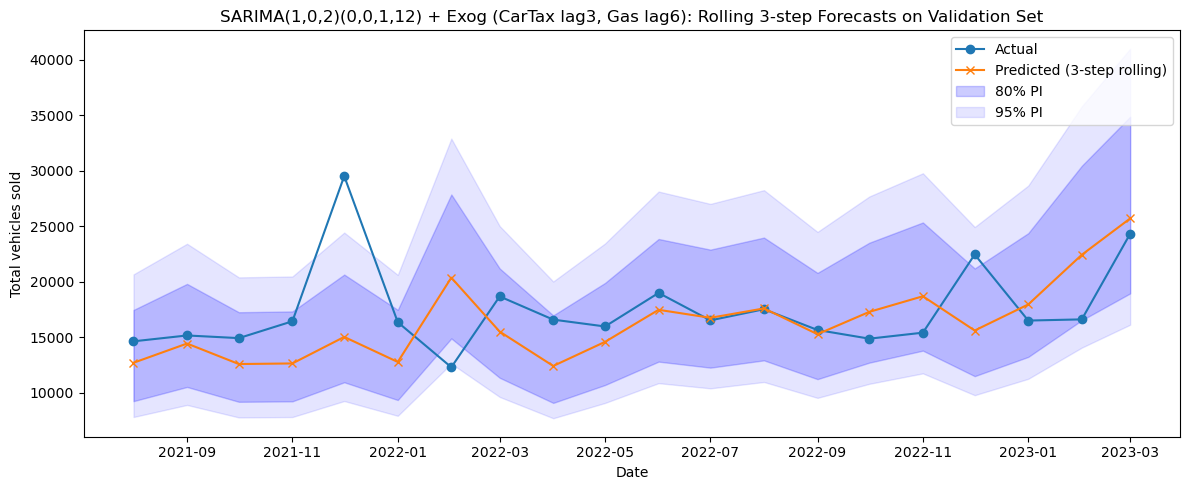

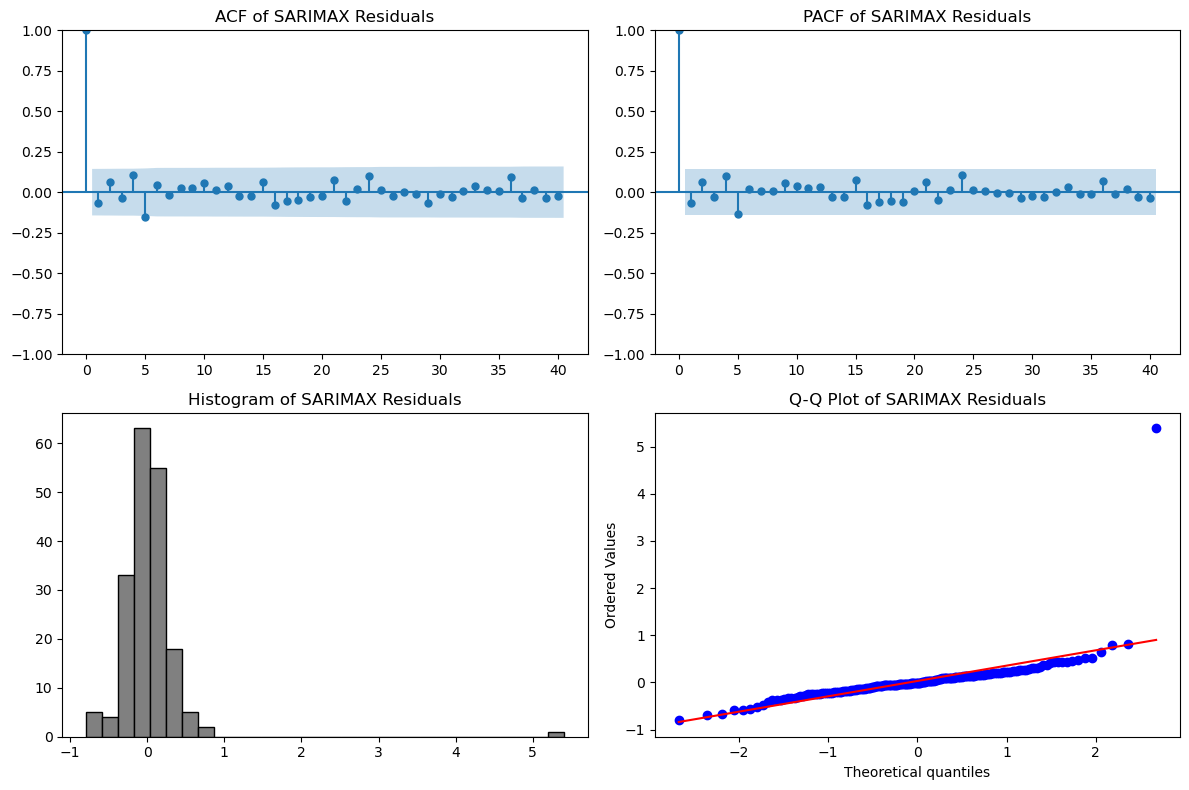

Ljung-Box test p-values (no autocorrelation if > 0.05):
      lb_stat  lb_pvalue
10   9.819138   0.456502
20  14.042439   0.828338
30  19.337241   0.932663


In [ ]:
# ─── 1. Prepare data ───────────────────────────────────────────────────────────
car_tax_bc = boxcox_all['Company car tax rate (%)']
gas_bc     = boxcox_all['Gasoline (Euro95) - Average price (F)']
target_bc  = boxcox_all[target]

history_y      = list(target_bc[:train_end])
history_tax    = list(car_tax_bc[:train_end])
history_gas    = list(gas_bc[:train_end])

val_y      = target_bc[train_end:val_end]
val_tax    = car_tax_bc[train_end:val_end]
val_gas    = gas_bc[train_end:val_end]

horizon = 3
lags    = [3, 6]  # lags for car tax, gas

predictions_bc = []
conf_int_80    = []
conf_int_95    = []

# ─── 2. Rolling loop ────────────────────────────────────────────────────────────
for t in range(len(val_y) - horizon + 1):
    # Lag exogenous variables
    tax_hist = np.array(history_tax)
    gas_hist = np.array(history_gas)

    tax_hist_lag3 = np.roll(tax_hist, lags[0]); tax_hist_lag3[:lags[0]] = np.nan
    gas_hist_lag6 = np.roll(gas_hist, lags[1]); gas_hist_lag6[:lags[1]] = np.nan

    # Align all (drop first 6 for max lag)
    y_hist = np.array(history_y)[lags[1]:]
    exog_hist = np.column_stack([
        tax_hist_lag3[lags[1]:], gas_hist_lag6[lags[1]:]
    ])

    # Fit SARIMAX on history
    model = SARIMAX(
        y_hist,
        exog=exog_hist,
        order=(1, 0, 2),
        seasonal_order=(0, 0, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fitted = model.fit(disp=False)

    # Recursive 3-step forecast with intervals
    temp_history_y      = history_y.copy()
    temp_history_tax    = history_tax.copy()
    temp_history_gas    = history_gas.copy()
    for step in range(horizon):
        idx = t + step
        tax_exog_full = np.concatenate([np.array(temp_history_tax)[-lags[0]:], [val_tax[idx]]])
        gas_exog_full = np.concatenate([np.array(temp_history_gas)[-lags[1]:], [val_gas[idx]]])
        tax_exog_lag3 = np.roll(tax_exog_full, lags[0])[lags[0]:]
        gas_exog_lag6 = np.roll(gas_exog_full, lags[1])[lags[1]:]
        exog_next = np.column_stack([
            tax_exog_lag3, gas_exog_lag6
        ])
        res = fitted.get_forecast(steps=1, exog=exog_next)
        yhat = res.predicted_mean[0]
        ci_80 = res.conf_int(alpha=0.20)[0]
        ci_95 = res.conf_int(alpha=0.05)[0]
        temp_history_y.append(yhat)
        temp_history_tax.append(val_tax[idx])
        temp_history_gas.append(val_gas[idx])
    predictions_bc.append(yhat)
    conf_int_80.append(ci_80)
    conf_int_95.append(ci_95)

    # Update rolling history with actuals for next window
    history_y.append(val_y[t])
    history_tax.append(val_tax[t])
    history_gas.append(val_gas[t])

# ─── 3. Invert Box–Cox & compute metrics ────────────────────────────────────────
lam, shift = boxcox_lambdas_all[target]
def inv_boxcox(y, lam):
    return np.exp(y) if lam == 0 else np.power(lam * y + 1, 1/lam)

pred_bc = np.array(predictions_bc)
pred_orig  = inv_boxcox(pred_bc, lam) - shift
actuals    = y_val.values[horizon-1:]

conf_int_80 = np.array(conf_int_80)
conf_int_95 = np.array(conf_int_95)
ci_80_lower = inv_boxcox(conf_int_80[:, 0], lam) - shift
ci_80_upper = inv_boxcox(conf_int_80[:, 1], lam) - shift
ci_95_lower = inv_boxcox(conf_int_95[:, 0], lam) - shift
ci_95_upper = inv_boxcox(conf_int_95[:, 1], lam) - shift

rmse_rolling = np.sqrt(mean_squared_error(actuals, pred_orig))
mape_rolling = mean_absolute_percentage_error(actuals, pred_orig)
print(f"Validation RMSE (3-step rolling): {rmse_rolling:.2f}")
print(f"Validation MAPE (3-step rolling): {mape_rolling:.2%}")

# ─── 4. Plot results ────────────────────────────────────────────────────────────
x_dates = df["Time Period (T)"][train_end+horizon-1:val_end]
plt.figure(figsize=(12, 5))
plt.plot(x_dates, actuals, label='Actual', marker='o')
plt.plot(x_dates, pred_orig, label='Predicted (3-step rolling)', marker='x')
plt.fill_between(x_dates, ci_80_lower, ci_80_upper, color='blue', alpha=0.2, label='80% PI')
plt.fill_between(x_dates, ci_95_lower, ci_95_upper, color='blue', alpha=0.1, label='95% PI')
plt.title('SARIMA(1,0,2)(0,0,1,12) + Exog (CarTax lag3, Gas lag6): Rolling 3-step Forecasts on Validation Set')
plt.xlabel('Date')
plt.ylabel('Total vehicles sold')
plt.legend()
plt.tight_layout()
plt.show()

# ─── 5. Residual diagnostics ────────────────────────────────────────────────────
import scipy.stats as stats

# Get residuals from the last fitted SARIMAX model in the rolling loop
residuals = fitted.resid

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# ACF plot
plot_acf(residuals, ax=axes[0, 0], lags=40)
axes[0, 0].set_title("ACF of SARIMAX Residuals")

# PACF plot
plot_pacf(residuals, ax=axes[0, 1], lags=40, method='ywm')
axes[0, 1].set_title("PACF of SARIMAX Residuals")

# Histogram
axes[1, 0].hist(residuals, bins=30, color='gray', edgecolor='black')
axes[1, 0].set_title("Histogram of SARIMAX Residuals")

# Q-Q plot
stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title("Q-Q Plot of SARIMAX Residuals")

plt.tight_layout()
plt.show()

# Ljung-Box test for autocorrelation (white noise)
lb_test = acorr_ljungbox(residuals, lags=[10, 20, 30], return_df=True)
print("Ljung-Box test p-values (no autocorrelation if > 0.05):")
print(lb_test[['lb_stat', 'lb_pvalue']])

### option 3 all features

Validation RMSE (3-step rolling): 4541.29
Validation MAPE (3-step rolling): 16.70%


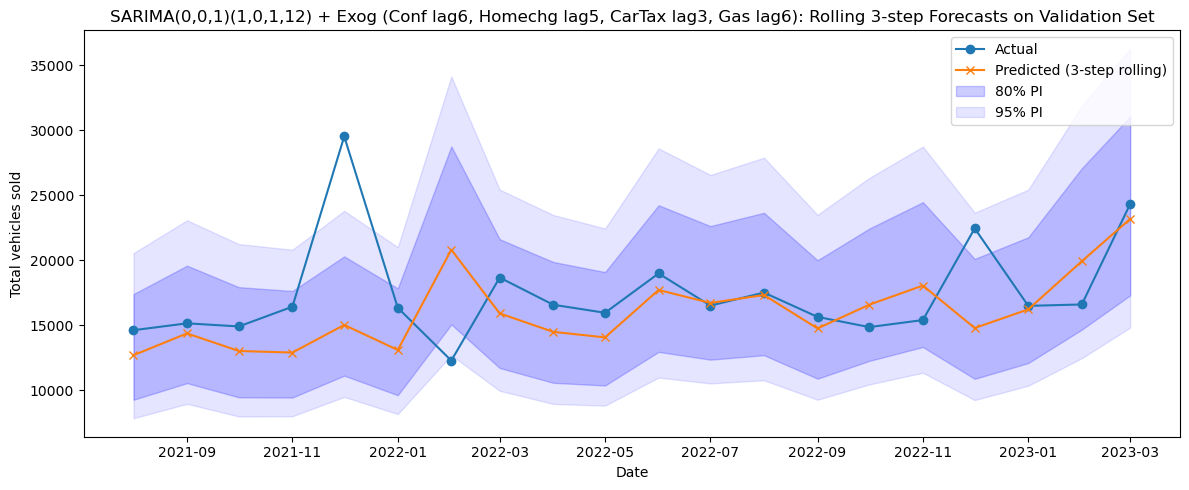

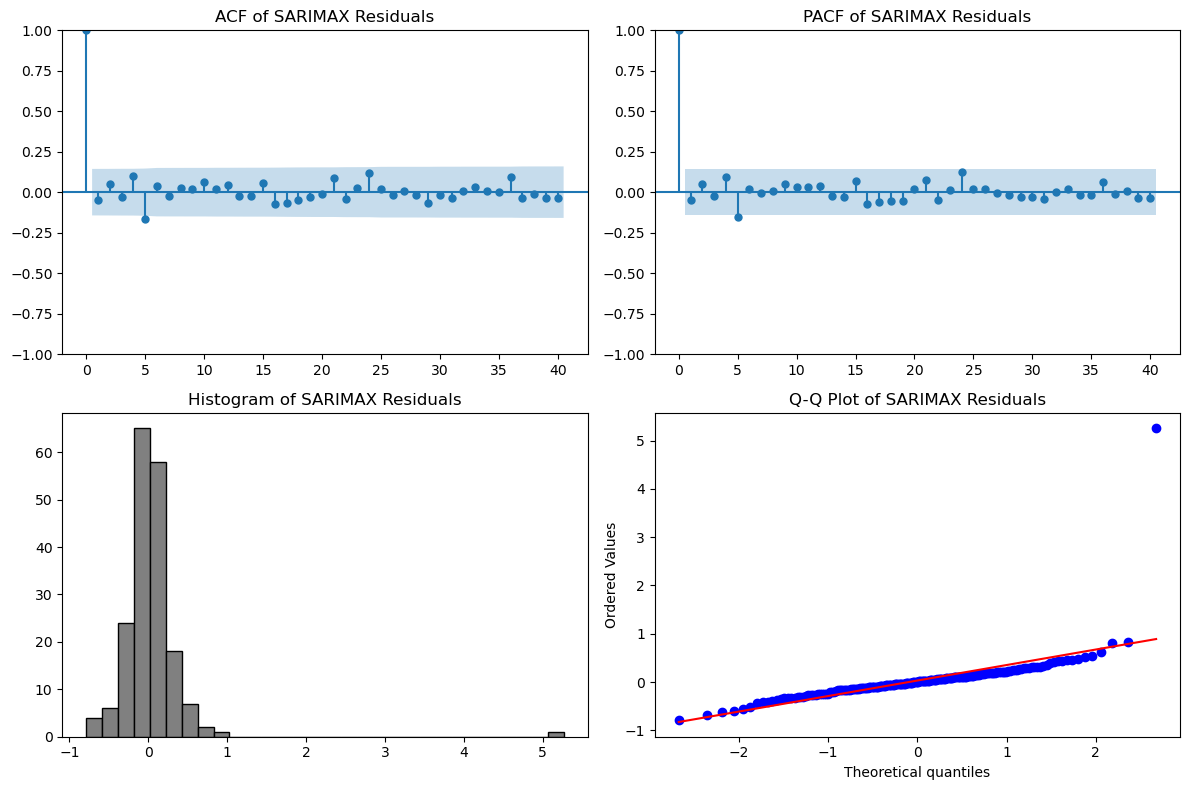

Ljung-Box test p-values (no autocorrelation if > 0.05):
      lb_stat  lb_pvalue
10   9.615913   0.474811
20  13.649981   0.847790
30  20.076234   0.914541


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

# ─── 1. Prepare data ───────────────────────────────────────────────────────────
conf_bc    = boxcox_all['Consumer confidence (E)']
homechg_bc = boxcox_all['Home charging (G)']
car_tax_bc = boxcox_all['Company car tax rate (%)']
gas_bc     = boxcox_all['Gasoline (Euro95) - Average price (F)']
target_bc  = boxcox_all[target]

history_y        = list(target_bc[:train_end])
history_conf     = list(conf_bc[:train_end])
history_homechg  = list(homechg_bc[:train_end])
history_tax      = list(car_tax_bc[:train_end])
history_gas      = list(gas_bc[:train_end])

val_y        = target_bc[train_end:val_end]
val_conf     = conf_bc[train_end:val_end]
val_homechg  = homechg_bc[train_end:val_end]
val_tax      = car_tax_bc[train_end:val_end]
val_gas      = gas_bc[train_end:val_end]

horizon = 3
lags    = [6, 5, 3, 6]  # lags for conf, homechg, tax, gas

predictions_bc = []
conf_int_80    = []
conf_int_95    = []

# ─── 2. Rolling loop ────────────────────────────────────────────────────────────
for t in range(len(val_y) - horizon + 1):
    # Lag all exogenous variables
    conf_hist    = np.array(history_conf)
    homechg_hist = np.array(history_homechg)
    tax_hist     = np.array(history_tax)
    gas_hist     = np.array(history_gas)

    conf_hist_lag6    = np.roll(conf_hist, lags[0]); conf_hist_lag6[:lags[0]] = np.nan
    homechg_hist_lag5 = np.roll(homechg_hist, lags[1]); homechg_hist_lag5[:lags[1]] = np.nan
    tax_hist_lag3     = np.roll(tax_hist, lags[2]); tax_hist_lag3[:lags[2]] = np.nan
    gas_hist_lag6     = np.roll(gas_hist, lags[3]); gas_hist_lag6[:lags[3]] = np.nan

    # Align all (drop first 6)
    y_hist = np.array(history_y)[6:]
    exog_hist = np.column_stack([
        conf_hist_lag6[6:], homechg_hist_lag5[6:], tax_hist_lag3[6:], gas_hist_lag6[6:]
    ])

    # Fit SARIMAX on history
    model = SARIMAX(
        y_hist,
        exog=exog_hist,
        order=(1, 0, 2),
        seasonal_order=(0, 0, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fitted = model.fit(disp=False)

    # Recursive 3-step forecast with intervals
    temp_history_y        = history_y.copy()
    temp_history_conf     = history_conf.copy()
    temp_history_homechg  = history_homechg.copy()
    temp_history_tax      = history_tax.copy()
    temp_history_gas      = history_gas.copy()
    for step in range(horizon):
        idx = t + step
        conf_exog_full    = np.concatenate([np.array(temp_history_conf)[-lags[0]:], [val_conf[idx]]])
        homechg_exog_full = np.concatenate([np.array(temp_history_homechg)[-lags[1]:], [val_homechg[idx]]])
        tax_exog_full     = np.concatenate([np.array(temp_history_tax)[-lags[2]:], [val_tax[idx]]])
        gas_exog_full     = np.concatenate([np.array(temp_history_gas)[-lags[3]:], [val_gas[idx]]])
        conf_exog_lag6    = np.roll(conf_exog_full, lags[0])[lags[0]:]
        homechg_exog_lag5 = np.roll(homechg_exog_full, lags[1])[lags[1]:]
        tax_exog_lag3     = np.roll(tax_exog_full, lags[2])[lags[2]:]
        gas_exog_lag6     = np.roll(gas_exog_full, lags[3])[lags[3]:]
        exog_next = np.column_stack([
            conf_exog_lag6, homechg_exog_lag5, tax_exog_lag3, gas_exog_lag6
        ])
        res = fitted.get_forecast(steps=1, exog=exog_next)
        yhat = res.predicted_mean[0]
        ci_80 = res.conf_int(alpha=0.20)[0]
        ci_95 = res.conf_int(alpha=0.05)[0]
        temp_history_y.append(yhat)
        temp_history_conf.append(val_conf[idx])
        temp_history_homechg.append(val_homechg[idx])
        temp_history_tax.append(val_tax[idx])
        temp_history_gas.append(val_gas[idx])
    predictions_bc.append(yhat)
    conf_int_80.append(ci_80)
    conf_int_95.append(ci_95)

    # Update rolling history with actuals for next window
    history_y.append(val_y[t])
    history_conf.append(val_conf[t])
    history_homechg.append(val_homechg[t])
    history_tax.append(val_tax[t])
    history_gas.append(val_gas[t])

# ─── 3. Invert Box–Cox & compute metrics ────────────────────────────────────────
lam, shift = boxcox_lambdas_all[target]
def inv_boxcox(y, lam):
    return np.exp(y) if lam == 0 else np.power(lam * y + 1, 1/lam)

pred_bc = np.array(predictions_bc)
pred_orig  = inv_boxcox(pred_bc, lam) - shift
actuals    = y_val.values[horizon-1:]

conf_int_80 = np.array(conf_int_80)
conf_int_95 = np.array(conf_int_95)
ci_80_lower = inv_boxcox(conf_int_80[:, 0], lam) - shift
ci_80_upper = inv_boxcox(conf_int_80[:, 1], lam) - shift
ci_95_lower = inv_boxcox(conf_int_95[:, 0], lam) - shift
ci_95_upper = inv_boxcox(conf_int_95[:, 1], lam) - shift

rmse_rolling = np.sqrt(mean_squared_error(actuals, pred_orig))
mape_rolling = mean_absolute_percentage_error(actuals, pred_orig)
print(f"Validation RMSE (3-step rolling): {rmse_rolling:.2f}")
print(f"Validation MAPE (3-step rolling): {mape_rolling:.2%}")

# ─── 4. Plot results ────────────────────────────────────────────────────────────
x_dates = df["Time Period (T)"][train_end+horizon-1:val_end]
plt.figure(figsize=(12, 5))
plt.plot(x_dates, actuals, label='Actual', marker='o')
plt.plot(x_dates, pred_orig, label='Predicted (3-step rolling)', marker='x')
plt.fill_between(x_dates, ci_80_lower, ci_80_upper, color='blue', alpha=0.2, label='80% PI')
plt.fill_between(x_dates, ci_95_lower, ci_95_upper, color='blue', alpha=0.1, label='95% PI')
plt.title('SARIMA(0,0,1)(1,0,1,12) + Exog (Conf lag6, Homechg lag5, CarTax lag3, Gas lag6): Rolling 3-step Forecasts on Validation Set')
plt.xlabel('Date')
plt.ylabel('Total vehicles sold')
plt.legend()
plt.tight_layout()
plt.show()

# ─── 5. Residual diagnostics ────────────────────────────────────────────────────
import scipy.stats as stats

# Get residuals from the last fitted SARIMAX model in the rolling loop
residuals = fitted.resid

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# ACF plot
plot_acf(residuals, ax=axes[0, 0], lags=40)
axes[0, 0].set_title("ACF of SARIMAX Residuals")

# PACF plot
plot_pacf(residuals, ax=axes[0, 1], lags=40, method='ywm')
axes[0, 1].set_title("PACF of SARIMAX Residuals")

# Histogram
axes[1, 0].hist(residuals, bins=30, color='gray', edgecolor='black')
axes[1, 0].set_title("Histogram of SARIMAX Residuals")

# Q-Q plot
stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title("Q-Q Plot of SARIMAX Residuals")

plt.tight_layout()
plt.show()

# Ljung-Box test for autocorrelation (white noise)
lb_test = acorr_ljungbox(residuals, lags=[10, 20, 30], return_df=True)
print("Ljung-Box test p-values (no autocorrelation if > 0.05):")
print(lb_test[['lb_stat', 'lb_pvalue']])

# 6 Plot/evaluate with target value

### Gas oline + Home Charging on test 

Test RMSE (3-step rolling): 4645.30
Test MAPE (3-step rolling): 13.06%


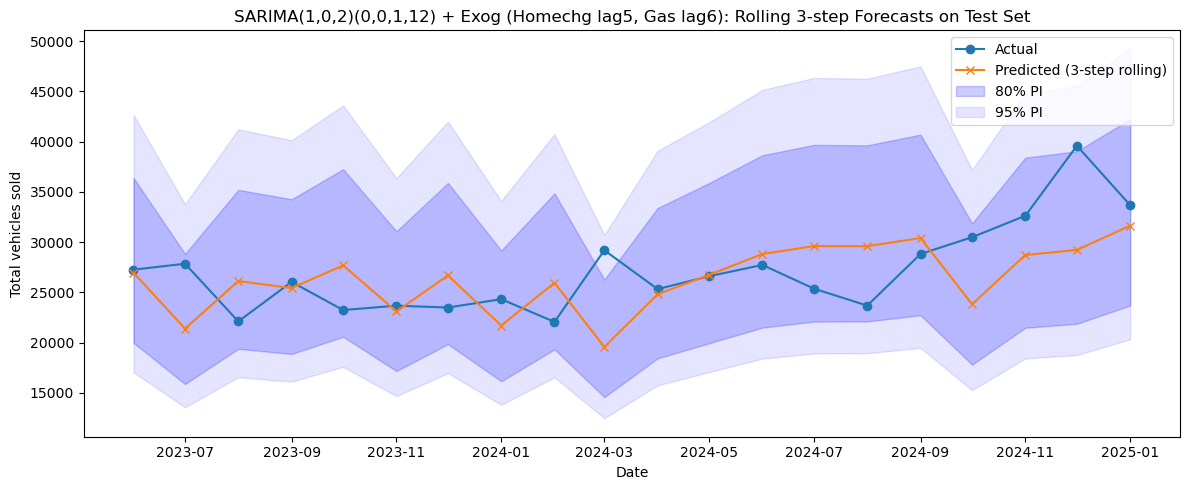

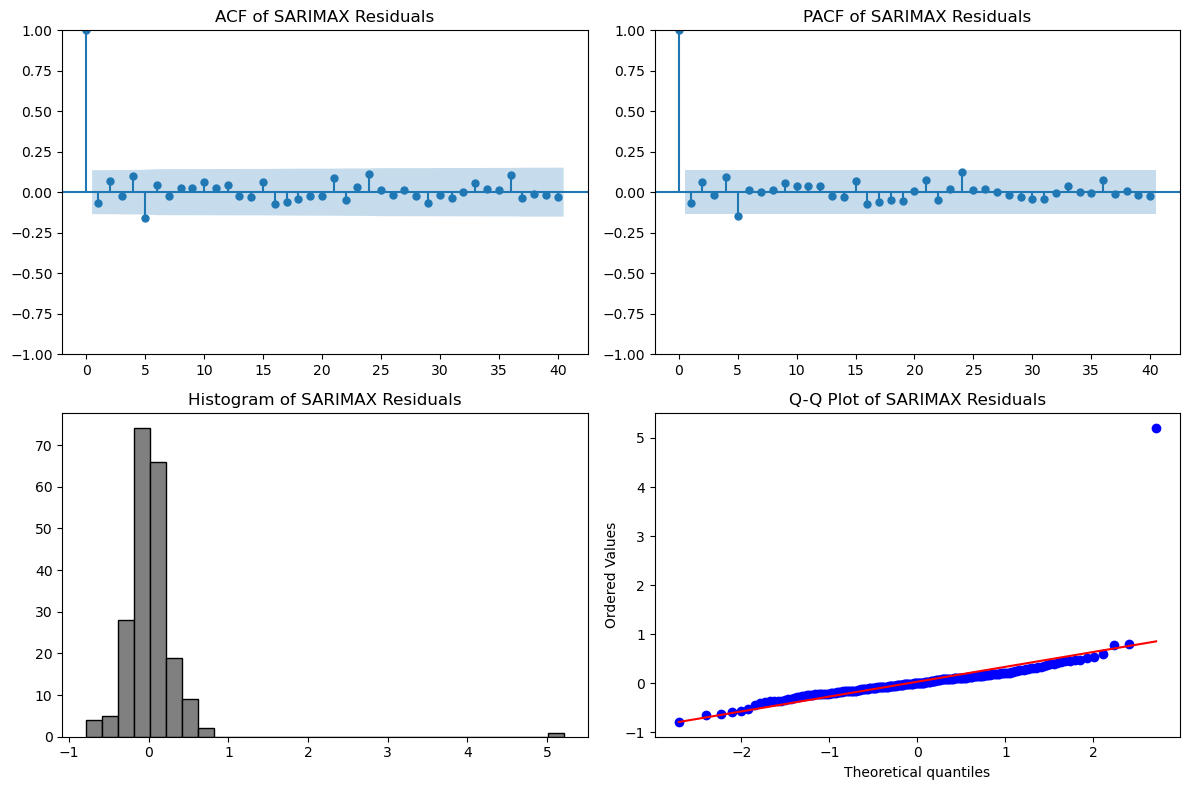

Ljung-Box test p-values (no autocorrelation if > 0.05):


In [ ]:
# --- Evaluate SARIMAX (Homechg lag5, Gas lag6) on TEST SET ---

homechg_bc = boxcox_all['Home charging (G)']
gas_bc     = boxcox_all['Gasoline (Euro95) - Average price (F)']
target_bc  = boxcox_all[target]

# Use all data up to end of validation as history, test as hold-out
history_y        = list(target_bc[:val_end])
history_homechg  = list(homechg_bc[:val_end])
history_gas      = list(gas_bc[:val_end])

test_y        = target_bc[val_end:]
test_homechg  = homechg_bc[val_end:]
test_gas      = gas_bc[val_end:]

horizon = 3
lags    = [5, 6]  # lags for homechg, gas

predictions_bc = []
conf_int_80    = []
conf_int_95    = []

for t in range(len(test_y) - horizon + 1):
    # Lag exogenous variables
    homechg_hist = np.array(history_homechg)
    gas_hist     = np.array(history_gas)

    homechg_hist_lag5 = np.roll(homechg_hist, lags[0]); homechg_hist_lag5[:lags[0]] = np.nan
    gas_hist_lag6     = np.roll(gas_hist, lags[1]); gas_hist_lag6[:lags[1]] = np.nan

    # Align all (drop first 6 for max lag)
    y_hist = np.array(history_y)[lags[1]:]
    exog_hist = np.column_stack([
        homechg_hist_lag5[lags[1]:], gas_hist_lag6[lags[1]:]
    ])

    # Fit SARIMAX on history
    model = SARIMAX(
        y_hist,
        exog=exog_hist,
        order=(1, 0, 2),
        seasonal_order=(0, 0, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fitted = model.fit(disp=False)

    # Recursive 3-step forecast with intervals
    temp_history_y        = history_y.copy()
    temp_history_homechg  = history_homechg.copy()
    temp_history_gas      = history_gas.copy()
    for step in range(horizon):
        idx = t + step
        homechg_exog_full = np.concatenate([np.array(temp_history_homechg)[-lags[0]:], [test_homechg[idx]]])
        gas_exog_full     = np.concatenate([np.array(temp_history_gas)[-lags[1]:], [test_gas[idx]]])
        homechg_exog_lag5 = np.roll(homechg_exog_full, lags[0])[lags[0]:]
        gas_exog_lag6     = np.roll(gas_exog_full, lags[1])[lags[1]:]
        exog_next = np.column_stack([
            homechg_exog_lag5, gas_exog_lag6
        ])
        res = fitted.get_forecast(steps=1, exog=exog_next)
        yhat = res.predicted_mean[0]
        ci_80 = res.conf_int(alpha=0.20)[0]
        ci_95 = res.conf_int(alpha=0.05)[0]
        temp_history_y.append(yhat)
        temp_history_homechg.append(test_homechg[idx])
        temp_history_gas.append(test_gas[idx])
    predictions_bc.append(yhat)
    conf_int_80.append(ci_80)
    conf_int_95.append(ci_95)

    # Update rolling history with actuals for next window
    history_y.append(test_y[t])
    history_homechg.append(test_homechg[t])
    history_gas.append(test_gas[t])

# --- Invert Box–Cox & compute metrics ---
lam, shift = boxcox_lambdas_all[target]
def inv_boxcox(y, lam):
    return np.exp(y) if lam == 0 else np.power(lam * y + 1, 1/lam)

pred_bc = np.array(predictions_bc)
pred_orig  = inv_boxcox(pred_bc, lam) - shift
actuals    = y_test.values[horizon-1:]

conf_int_80 = np.array(conf_int_80)
conf_int_95 = np.array(conf_int_95)
ci_80_lower = inv_boxcox(conf_int_80[:, 0], lam) - shift
ci_80_upper = inv_boxcox(conf_int_80[:, 1], lam) - shift
ci_95_lower = inv_boxcox(conf_int_95[:, 0], lam) - shift
ci_95_upper = inv_boxcox(conf_int_95[:, 1], lam) - shift

rmse_rolling = np.sqrt(mean_squared_error(actuals, pred_orig))
mape_rolling = mean_absolute_percentage_error(actuals, pred_orig)
print(f"Test RMSE (3-step rolling): {rmse_rolling:.2f}")
print(f"Test MAPE (3-step rolling): {mape_rolling:.2%}")

# --- Plot results ---
x_dates = df["Time Period (T)"][val_end+horizon-1:]
plt.figure(figsize=(12, 5))
plt.plot(x_dates, actuals, label='Actual', marker='o')
plt.plot(x_dates, pred_orig, label='Predicted (3-step rolling)', marker='x')
plt.fill_between(x_dates, ci_80_lower, ci_80_upper, color='blue', alpha=0.2, label='80% PI')
plt.fill_between(x_dates, ci_95_lower, ci_95_upper, color='blue', alpha=0.1, label='95% PI')
plt.title('SARIMA(1,0,2)(0,0,1,12) + Exog (Homechg lag5, Gas lag6): Rolling 3-step Forecasts on Test Set')
plt.xlabel('Date')
plt.ylabel('Total vehicles sold')
plt.legend()
plt.tight_layout()
plt.show()

# --- Residual diagnostics ---
import scipy.stats as stats

residuals = fitted.resid

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plot_acf(residuals, ax=axes[0, 0], lags=40)
axes[0, 0].set_title("ACF of SARIMAX Residuals")
plot_pacf(residuals, ax=axes[0, 1], lags=40, method='ywm')
axes[0, 1].set_title("PACF of SARIMAX Residuals")
axes[1, 0].hist(residuals, bins=30, color='gray', edgecolor='black')
axes[1, 0].set_title("Histogram of SARIMAX Residuals")
stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title("Q-Q Plot of SARIMAX Residuals")
plt.tight_layout()
plt.show()

lb_test = acorr_ljungbox(residuals, lags=[10, 20, 30], return_df=True)
print("Ljung-Box test p-values (no autocorrelation if > 0.05):")

### Cartax and gas on test

Test RMSE (3-step rolling): 4618.95
Test MAPE (3-step rolling): 12.58%


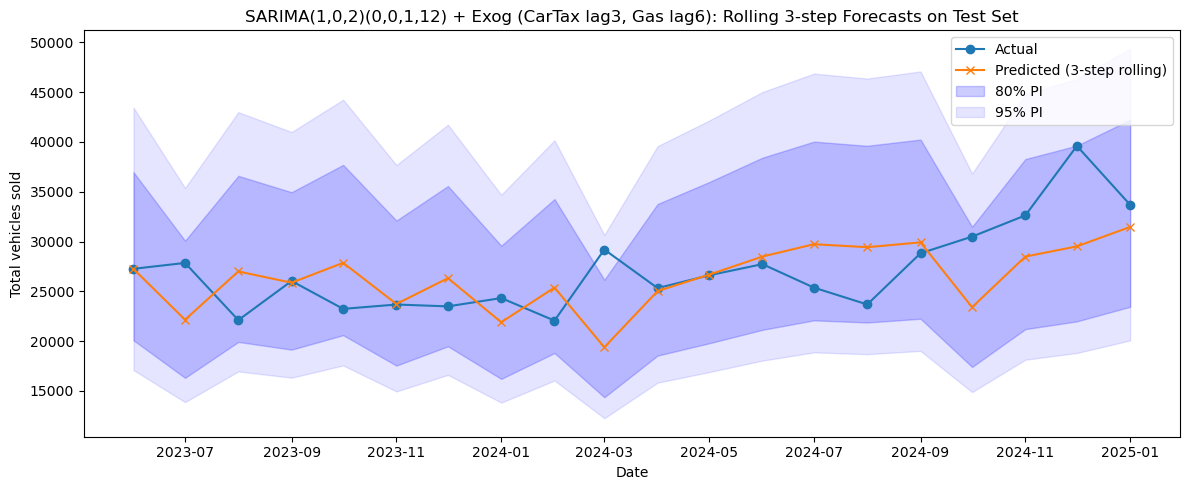

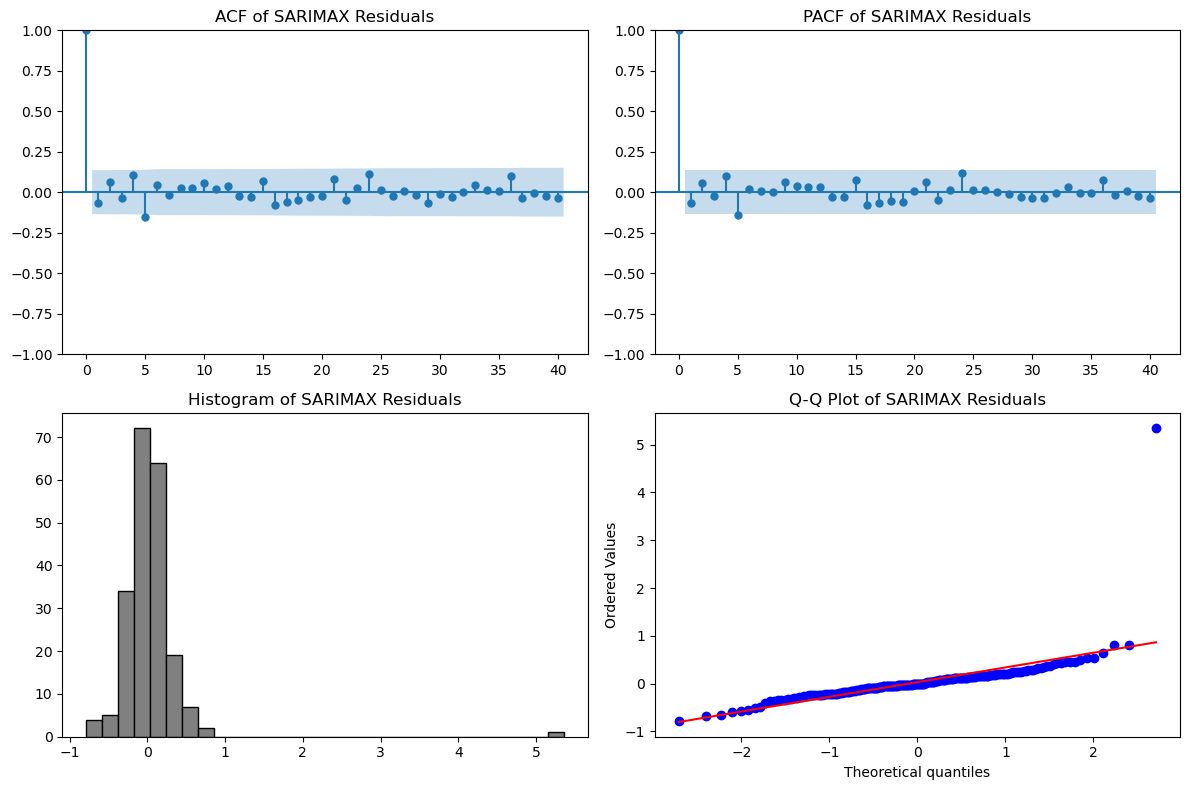

Ljung-Box test p-values (no autocorrelation if > 0.05):
      lb_stat  lb_pvalue
10  11.026582   0.355451
20  16.017983   0.715508
30  22.312504   0.842436


In [ ]:
# --- Evaluate SARIMAX (CarTax lag3, Gas lag6) on TEST SET ---

car_tax_bc = boxcox_all['Company car tax rate (%)']
gas_bc     = boxcox_all['Gasoline (Euro95) - Average price (F)']
target_bc  = boxcox_all[target]

# Use all data up to end of validation as history, test as hold-out
history_y      = list(target_bc[:val_end])
history_tax    = list(car_tax_bc[:val_end])
history_gas    = list(gas_bc[:val_end])

test_y      = target_bc[val_end:]
test_tax    = car_tax_bc[val_end:]
test_gas    = gas_bc[val_end:]

horizon = 3
lags    = [3, 6]  # lags for car tax, gas

predictions_bc = []
conf_int_80    = []
conf_int_95    = []

for t in range(len(test_y) - horizon + 1):
    # Lag exogenous variables
    tax_hist = np.array(history_tax)
    gas_hist = np.array(history_gas)

    tax_hist_lag3 = np.roll(tax_hist, lags[0]); tax_hist_lag3[:lags[0]] = np.nan
    gas_hist_lag6 = np.roll(gas_hist, lags[1]); gas_hist_lag6[:lags[1]] = np.nan

    # Align all (drop first 6 for max lag)
    y_hist = np.array(history_y)[lags[1]:]
    exog_hist = np.column_stack([
        tax_hist_lag3[lags[1]:], gas_hist_lag6[lags[1]:]
    ])

    # Fit SARIMAX on history
    model = SARIMAX(
        y_hist,
        exog=exog_hist,
        order=(1, 0, 2),
        seasonal_order=(0, 0, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fitted = model.fit(disp=False)

    # Recursive 3-step forecast with intervals
    temp_history_y      = history_y.copy()
    temp_history_tax    = history_tax.copy()
    temp_history_gas    = history_gas.copy()
    for step in range(horizon):
        idx = t + step
        tax_exog_full = np.concatenate([np.array(temp_history_tax)[-lags[0]:], [test_tax[idx]]])
        gas_exog_full = np.concatenate([np.array(temp_history_gas)[-lags[1]:], [test_gas[idx]]])
        tax_exog_lag3 = np.roll(tax_exog_full, lags[0])[lags[0]:]
        gas_exog_lag6 = np.roll(gas_exog_full, lags[1])[lags[1]:]
        exog_next = np.column_stack([
            tax_exog_lag3, gas_exog_lag6
        ])
        res = fitted.get_forecast(steps=1, exog=exog_next)
        yhat = res.predicted_mean[0]
        ci_80 = res.conf_int(alpha=0.20)[0]
        ci_95 = res.conf_int(alpha=0.05)[0]
        temp_history_y.append(yhat)
        temp_history_tax.append(test_tax[idx])
        temp_history_gas.append(test_gas[idx])
    predictions_bc.append(yhat)
    conf_int_80.append(ci_80)
    conf_int_95.append(ci_95)

    # Update rolling history with actuals for next window
    history_y.append(test_y[t])
    history_tax.append(test_tax[t])
    history_gas.append(test_gas[t])

# --- Invert Box–Cox & compute metrics ---
lam, shift = boxcox_lambdas_all[target]
def inv_boxcox(y, lam):
    return np.exp(y) if lam == 0 else np.power(lam * y + 1, 1/lam)

pred_bc = np.array(predictions_bc)
pred_orig  = inv_boxcox(pred_bc, lam) - shift
actuals    = y_test.values[horizon-1:]

conf_int_80 = np.array(conf_int_80)
conf_int_95 = np.array(conf_int_95)
ci_80_lower = inv_boxcox(conf_int_80[:, 0], lam) - shift
ci_80_upper = inv_boxcox(conf_int_80[:, 1], lam) - shift
ci_95_lower = inv_boxcox(conf_int_95[:, 0], lam) - shift
ci_95_upper = inv_boxcox(conf_int_95[:, 1], lam) - shift

rmse_rolling = np.sqrt(mean_squared_error(actuals, pred_orig))
mape_rolling = mean_absolute_percentage_error(actuals, pred_orig)
print(f"Test RMSE (3-step rolling): {rmse_rolling:.2f}")
print(f"Test MAPE (3-step rolling): {mape_rolling:.2%}")

# --- Plot results ---
x_dates = df["Time Period (T)"][val_end+horizon-1:]
plt.figure(figsize=(12, 5))
plt.plot(x_dates, actuals, label='Actual', marker='o')
plt.plot(x_dates, pred_orig, label='Predicted (3-step rolling)', marker='x')
plt.fill_between(x_dates, ci_80_lower, ci_80_upper, color='blue', alpha=0.2, label='80% PI')
plt.fill_between(x_dates, ci_95_lower, ci_95_upper, color='blue', alpha=0.1, label='95% PI')
plt.title('SARIMA(1,0,2)(0,0,1,12) + Exog (CarTax lag3, Gas lag6): Rolling 3-step Forecasts on Test Set')
plt.xlabel('Date')
plt.ylabel('Total vehicles sold')
plt.legend()
plt.tight_layout()
plt.show()

# --- Residual diagnostics ---
import scipy.stats as stats

residuals = fitted.resid

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plot_acf(residuals, ax=axes[0, 0], lags=40)
axes[0, 0].set_title("ACF of SARIMAX Residuals")
plot_pacf(residuals, ax=axes[0, 1], lags=40, method='ywm')
axes[0, 1].set_title("PACF of SARIMAX Residuals")
axes[1, 0].hist(residuals, bins=30, color='gray', edgecolor='black')
axes[1, 0].set_title("Histogram of SARIMAX Residuals")
stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title("Q-Q Plot of SARIMAX Residuals")
plt.tight_layout()
plt.show()

lb_test = acorr_ljungbox(residuals, lags=[10, 20, 30], return_df=True)
print("Ljung-Box test p-values (no autocorrelation if > 0.05):")
print(lb_test[['lb_stat', 'lb_pvalue']])

### All features on test 


Test RMSE (3-step rolling): 5172.46
Test MAPE (3-step rolling): 15.84%


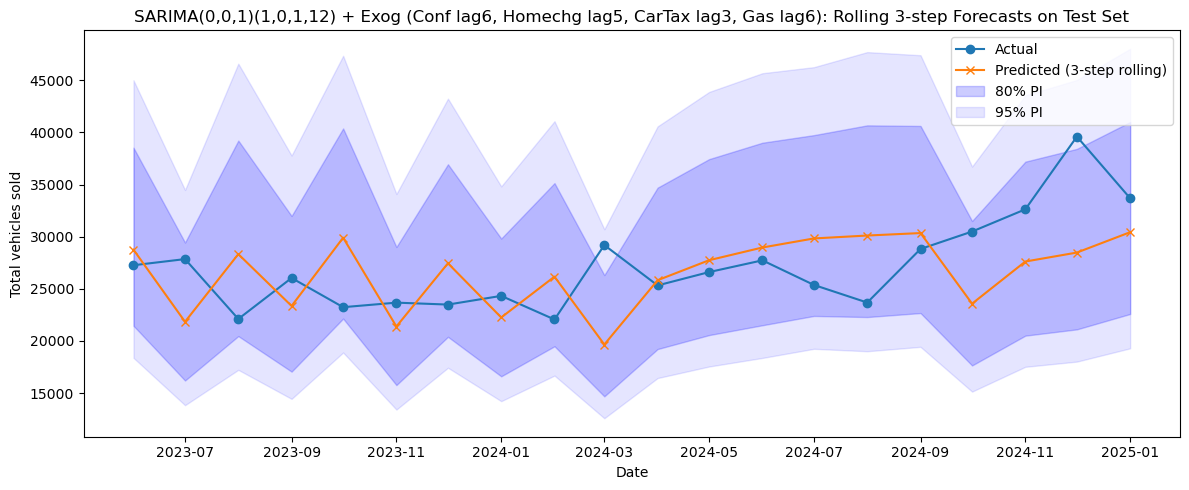

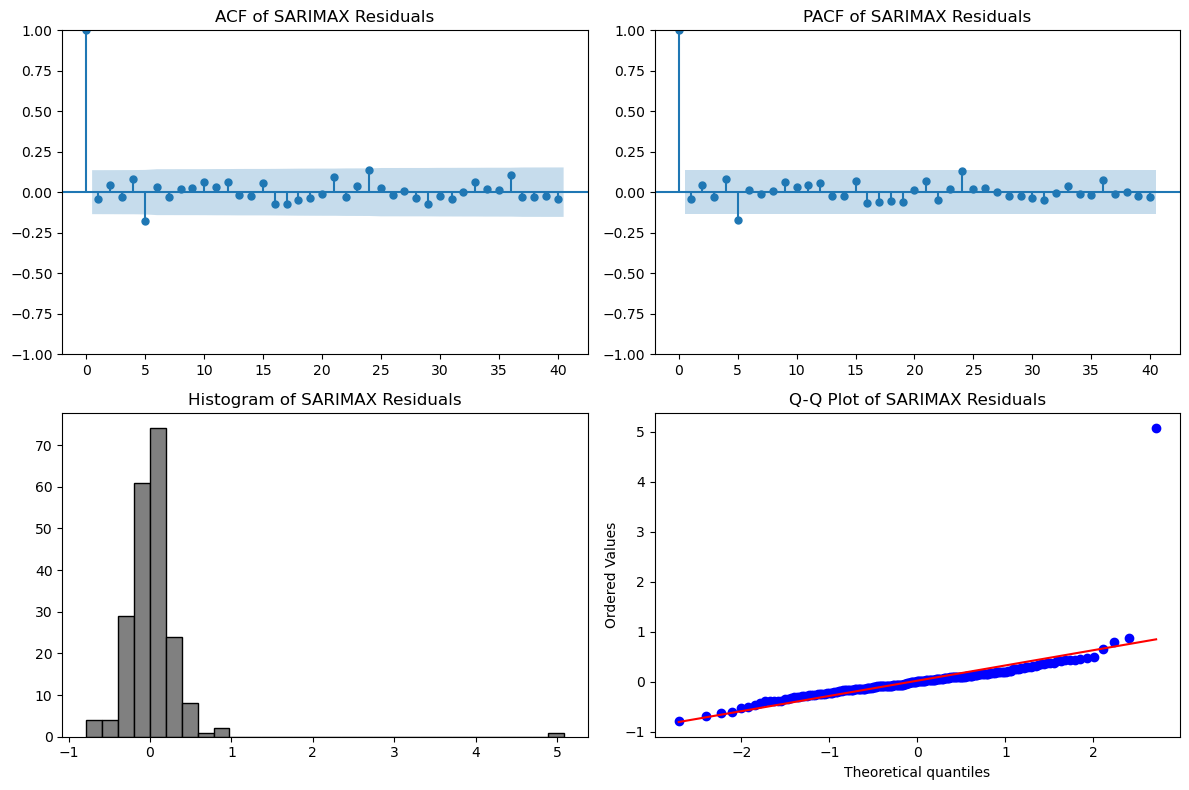

Ljung-Box test p-values (no autocorrelation if > 0.05):
      lb_stat  lb_pvalue
10  11.191649   0.342783
20  16.522554   0.683723
30  25.139298   0.718234


In [ ]:


# ─── 1. Prepare data ───────────────────────────────────────────────────────────
conf_bc    = boxcox_all['Consumer confidence (E)']
homechg_bc = boxcox_all['Home charging (G)']
car_tax_bc = boxcox_all['Company car tax rate (%)']
gas_bc     = boxcox_all['Gasoline (Euro95) - Average price (F)']
target_bc  = boxcox_all[target]

history_y        = list(target_bc[:val_end])
history_conf     = list(conf_bc[:val_end])
history_homechg  = list(homechg_bc[:val_end])
history_tax      = list(car_tax_bc[:val_end])
history_gas      = list(gas_bc[:val_end])

test_y        = target_bc[val_end:]
test_conf     = conf_bc[val_end:]
test_homechg  = homechg_bc[val_end:]
test_tax      = car_tax_bc[val_end:]
test_gas      = gas_bc[val_end:]

horizon = 3
lags    = [6, 5, 3, 6]  # lags for conf, homechg, tax, gas

predictions_bc = []
conf_int_80    = []
conf_int_95    = []

# ─── 2. Rolling loop ────────────────────────────────────────────────────────────
for t in range(len(test_y) - horizon + 1):
    # Lag all exogenous variables
    conf_hist    = np.array(history_conf)
    homechg_hist = np.array(history_homechg)
    tax_hist     = np.array(history_tax)
    gas_hist     = np.array(history_gas)

    conf_hist_lag6    = np.roll(conf_hist, lags[0]); conf_hist_lag6[:lags[0]] = np.nan
    homechg_hist_lag5 = np.roll(homechg_hist, lags[1]); homechg_hist_lag5[:lags[1]] = np.nan
    tax_hist_lag3     = np.roll(tax_hist, lags[2]); tax_hist_lag3[:lags[2]] = np.nan
    gas_hist_lag6     = np.roll(gas_hist, lags[3]); gas_hist_lag6[:lags[3]] = np.nan

    # Align all (drop first 6)
    y_hist = np.array(history_y)[6:]
    exog_hist = np.column_stack([
        conf_hist_lag6[6:], homechg_hist_lag5[6:], tax_hist_lag3[6:], gas_hist_lag6[6:]
    ])

    # Fit SARIMAX on history
    model = SARIMAX(
        y_hist,
        exog=exog_hist,
        order=(1, 0, 2),
        seasonal_order=(0, 0, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fitted = model.fit(disp=False)

    # Recursive 3-step forecast with intervals
    temp_history_y        = history_y.copy()
    temp_history_conf     = history_conf.copy()
    temp_history_homechg  = history_homechg.copy()
    temp_history_tax      = history_tax.copy()
    temp_history_gas      = history_gas.copy()
    for step in range(horizon):
        idx = t + step
        conf_exog_full    = np.concatenate([np.array(temp_history_conf)[-lags[0]:], [test_conf[idx]]])
        homechg_exog_full = np.concatenate([np.array(temp_history_homechg)[-lags[1]:], [test_homechg[idx]]])
        tax_exog_full     = np.concatenate([np.array(temp_history_tax)[-lags[2]:], [test_tax[idx]]])
        gas_exog_full     = np.concatenate([np.array(temp_history_gas)[-lags[3]:], [test_gas[idx]]])
        conf_exog_lag6    = np.roll(conf_exog_full, lags[0])[lags[0]:]
        homechg_exog_lag5 = np.roll(homechg_exog_full, lags[1])[lags[1]:]
        tax_exog_lag3     = np.roll(tax_exog_full, lags[2])[lags[2]:]
        gas_exog_lag6     = np.roll(gas_exog_full, lags[3])[lags[3]:]
        exog_next = np.column_stack([
            conf_exog_lag6, homechg_exog_lag5, tax_exog_lag3, gas_exog_lag6
        ])
        res = fitted.get_forecast(steps=1, exog=exog_next)
        yhat = res.predicted_mean[0]
        ci_80 = res.conf_int(alpha=0.20)[0]
        ci_95 = res.conf_int(alpha=0.05)[0]
        temp_history_y.append(yhat)
        temp_history_conf.append(test_conf[idx])
        temp_history_homechg.append(test_homechg[idx])
        temp_history_tax.append(test_tax[idx])
        temp_history_gas.append(test_gas[idx])
    predictions_bc.append(yhat)
    conf_int_80.append(ci_80)
    conf_int_95.append(ci_95)

    # Update rolling history with actuals for next window
    history_y.append(test_y[t])
    history_conf.append(test_conf[t])
    history_homechg.append(test_homechg[t])
    history_tax.append(test_tax[t])
    history_gas.append(test_gas[t])

# ─── 3. Invert Box–Cox & compute metrics ────────────────────────────────────────
lam, shift = boxcox_lambdas_all[target]
def inv_boxcox(y, lam):
    return np.exp(y) if lam == 0 else np.power(lam * y + 1, 1/lam)

pred_bc = np.array(predictions_bc)
pred_orig  = inv_boxcox(pred_bc, lam) - shift
actuals    = y_test.values[horizon-1:]

conf_int_80 = np.array(conf_int_80)
conf_int_95 = np.array(conf_int_95)
ci_80_lower = inv_boxcox(conf_int_80[:, 0], lam) - shift
ci_80_upper = inv_boxcox(conf_int_80[:, 1], lam) - shift
ci_95_lower = inv_boxcox(conf_int_95[:, 0], lam) - shift
ci_95_upper = inv_boxcox(conf_int_95[:, 1], lam) - shift

rmse_rolling = np.sqrt(mean_squared_error(actuals, pred_orig))
mape_rolling = mean_absolute_percentage_error(actuals, pred_orig)
print(f"Test RMSE (3-step rolling): {rmse_rolling:.2f}")
print(f"Test MAPE (3-step rolling): {mape_rolling:.2%}")

# ─── 4. Plot results ────────────────────────────────────────────────────────────
x_dates = df["Time Period (T)"][val_end+horizon-1:]
plt.figure(figsize=(12, 5))
plt.plot(x_dates, actuals, label='Actual', marker='o')
plt.plot(x_dates, pred_orig, label='Predicted (3-step rolling)', marker='x')
plt.fill_between(x_dates, ci_80_lower, ci_80_upper, color='blue', alpha=0.2, label='80% PI')
plt.fill_between(x_dates, ci_95_lower, ci_95_upper, color='blue', alpha=0.1, label='95% PI')
plt.title('SARIMA(0,0,1)(1,0,1,12) + Exog (Conf lag6, Homechg lag5, CarTax lag3, Gas lag6): Rolling 3-step Forecasts on Test Set')
plt.xlabel('Date')
plt.ylabel('Total vehicles sold')
plt.legend()
plt.tight_layout()
plt.show()

# ─── 5. Residual diagnostics ────────────────────────────────────────────────────
import scipy.stats as stats

# Get residuals from the last fitted SARIMAX model in the rolling loop
residuals = fitted.resid

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# ACF plot
plot_acf(residuals, ax=axes[0, 0], lags=40)
axes[0, 0].set_title("ACF of SARIMAX Residuals")

# PACF plot
plot_pacf(residuals, ax=axes[0, 1], lags=40, method='ywm')
axes[0, 1].set_title("PACF of SARIMAX Residuals")

# Histogram
axes[1, 0].hist(residuals, bins=30, color='gray', edgecolor='black')
axes[1, 0].set_title("Histogram of SARIMAX Residuals")

# Q-Q plot
stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title("Q-Q Plot of SARIMAX Residuals")

plt.tight_layout()
plt.show()

# Ljung-Box test for autocorrelation (white noise)
lb_test = acorr_ljungbox(residuals, lags=[10, 20, 30], return_df=True)
print("Ljung-Box test p-values (no autocorrelation if > 0.05):")
print(lb_test[['lb_stat', 'lb_pvalue']])

MAPE values are all in a similar range (15–18%), which suggests no feature is dramatically improving or worsening the forecast.
RMSE for "All on test" is higher than for "All" on validation, which is expected due to test set uncertainty, but the drop in MAPE (to 15.84%) is a bit unusual—typically, RMSE and MAPE move together. This could be due to outliers or a shift in the test set distribution.
Adding exogenous features does not drastically improve RMSE/MAPE compared to baseline, which may indicate:
The target is mostly explained by its own lags.
Exogenous features are not strongly predictive, or lag choices could be further optimized.
No negative RMSE/MAPE or extreme values, so the model is numerically stable.